In [1]:
import os 
import random
import shutil
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

from PIL import Image

import numpy as np
import pickle
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import utils

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

BATCH_SIZE=4
MAX_SEQUENCE_LENGTH=150
MANUAL_SEED = 1
HIDDEN_SIZE = 256
INPUT_SIZE=14

utils.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
utils.INPUT_SIZE = INPUT_SIZE


In [2]:


transform = transforms.Compose(
    [transforms.Resize((150,150)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder('../dataset/augmented/full_scanpath_dataset/', transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)



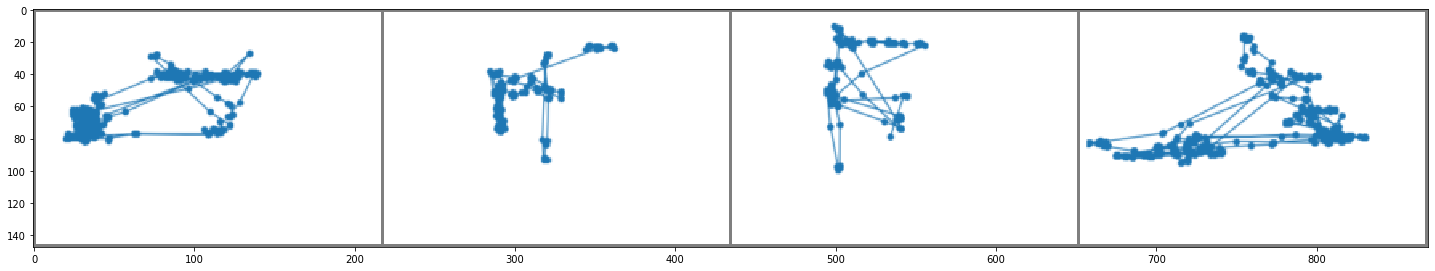

not_confused-not_confused-not_confused-not_confused


In [3]:
classes = ('confused', 'not_confused')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

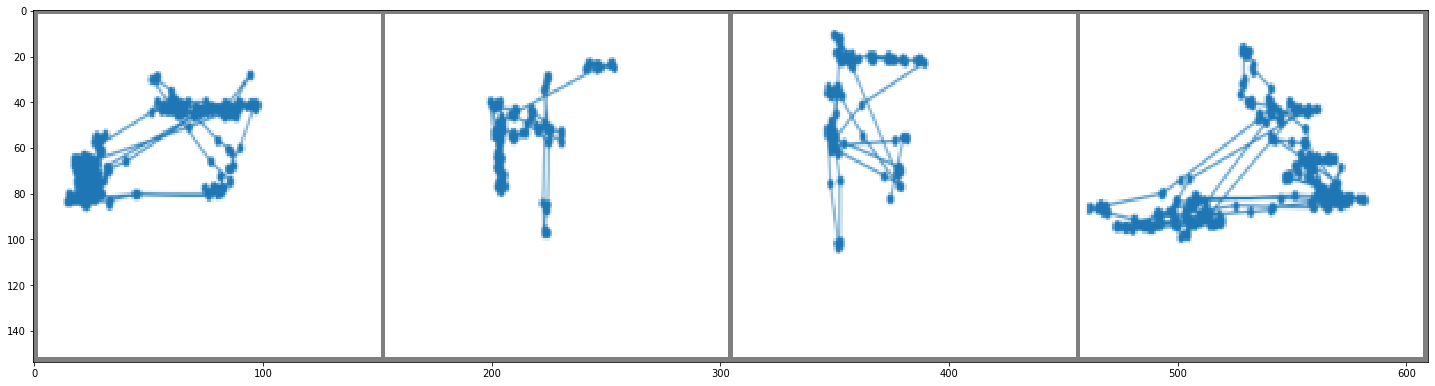

not_confused-not_confused-not_confused-not_confused


In [3]:
classes = ('confused', 'not_confused')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

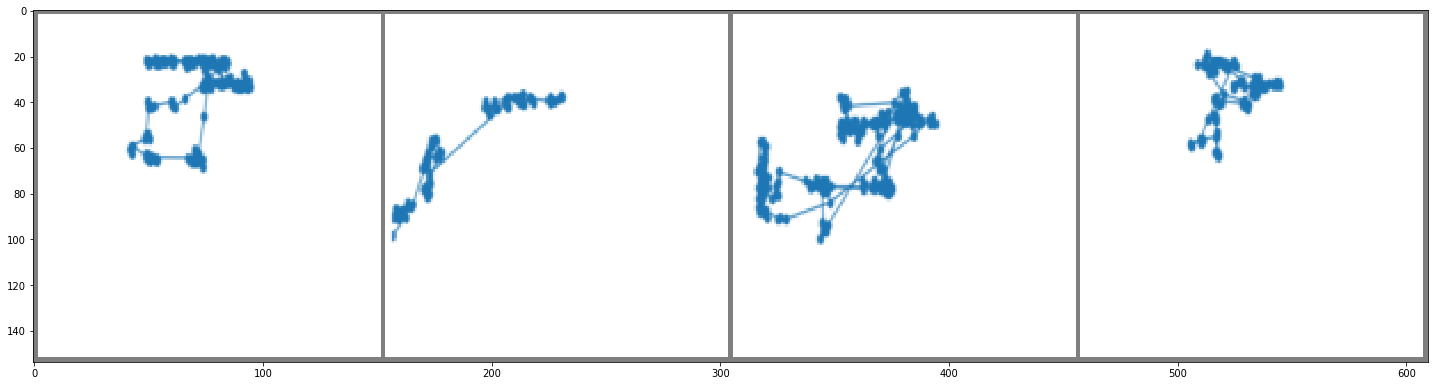

not_confused-not_confused-not_confused-not_confused


In [4]:
classes = ('confused', 'not_confused')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

Relevant cues are fixations, saccades, and the temporal development thereof. Model architecture needs to capture this. Thus we need a large receptive
field, but a hierarchy of parts is likely not as important as in vision applications.
We use one image channel because colour has no meaning.
We use images instead of a matrix of x,y gaze coordinates because we want the connections that come with a
scatter plot, as this encodes saccadic magnitude information, however coarsely.

In [46]:
class VTNet(nn.Module):
    def __init__(self,
                 input_size=2,
                 rnn_hidden_size=256,
                 output_size=2,
                 batch_size=4,
                 rnn_type='gru',
                 rnn_num_layers=1,
                 n_channels_1=6,
                 kernel_size_1=5,
                 n_channels_2=16,
                 kernel_size_2=5,
                 img_n_vert=150,
                 img_n_hor=150):
        """

        Args:
            input_size (int):
            hidden_size (int):
            output_size (int):
            batch_size (int):
            rnn_type (int):
            num_layers (int):
        """
        super(VTNet, self).__init__()

        self.n_channels_2 = n_channels_2


        # CNN portion
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_channels_1, kernel_size=kernel_size_1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_channels_1, out_channels=n_channels_2, kernel_size=kernel_size_2, stride=1)
        # output size calculations
        self.conv1_out_vert = img_n_vert - kernel_size_1 + 1
        self.conv1_out_hor = img_n_hor - kernel_size_1 + 1
        self.mp1_out_vert = int(np.floor((self.conv1_out_vert - 2)/2) + 1)
        self.mp1_out_hor = int(np.floor((self.conv1_out_hor - 2) / 2) + 1)
        self.conv2_out_vert = self.mp1_out_vert - kernel_size_2 + 1
        self.conv2_out_hor = self.mp1_out_hor - kernel_size_2 + 1
        self.mp2_out_vert = int(np.floor((self.conv2_out_vert - 2)/2) + 1)
        self.mp2_out_hor = int(np.floor((self.conv2_out_hor - 2) / 2) + 1)
        self.fc1 = nn.Linear(n_channels_2 * self.mp2_out_hor * self.mp2_out_vert, 50)
        self.fc2 = nn.Linear(rnn_hidden_size + 50, 20)
        self.fc3 = nn.Linear(20, output_size)

        # RNN portion
        self.rnn_type = rnn_type
        self.input_size = input_size
        self.rnn_hidden_size = rnn_hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.rnn_num_layers = rnn_num_layers



        if rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
                               num_layers=rnn_num_layers)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers)

        self.out = nn.Linear(rnn_hidden_size, output_size)

    def forward(self, scan_path, time_series, hidden):
        """
            Args:
                scan_path (torch.Tensor): must be 349x231 for now
                time_series (torch.Tensor):
            Returns:
                x (float): logit for confusion prediction - requires cross entropy loss
        """
        x1 = self.pool(F.relu(self.conv1(scan_path)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(-1, self.n_channels_2 * self.mp2_out_hor * self.mp2_out_vert)
        x1 = F.relu(self.fc1(x1))

        # change input shape to (max_seq_size, batch_size, input_features):
        x2 = time_series.permute(1, 0, 2)
        x2, hidden = self.rnn(x2, hidden)
        x2 = x2[-1, :, :]  # take only the last output

        x = torch.cat((x1, x2), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        if self.rnn_type == 'lstm':
            return (autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device),
                    autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device))
        else:
            return autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device)

    
def st_pickle_loader(input_file_path, max_length=150):
    """ Processes a raw data item into a scan path image and a time series
        for input into a STNet. Takes only gaze information into consideration.

        Args:
            input_file_name (string): the name of the data item to be loaded
            max_length (int): max number of samples to use for a given item.
                If -1, use all samples
        Returns:
            item (numpy.ndarray): the fully processed data item for RNN input
            item_sp (PIL Image): 

    """
    transform = transforms.Compose([transforms.Resize((150,150)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])
    
    file = open(input_file_path, 'rb')
    item = pickle.load(file)
    item = item.values
    item[:,0] = (item[:,0] + item[:,7])/2 #column 0 is now ave Gx
    item[:,1] = (item[:,1] + item[:,8])/2 #column 1 is now ave Gy
    item = item[item[:,0] > 0]
    item = abs(item)
    item[item == 1.0] = -1.0
    
    #determine if item was done in horizontal or vertical layout:
    item_name = input_file_path.split('/')[-1]
    orientation = item_name.split('-')[0][-1]
    # remove any glances to 'I'm Confused' button
    if orientation == 'H':
        item = item[(item[:,0] < 775.0) | (item[:,0] > 880.0) | (item[:,1] < 334.0) | (item[:,1] > 419.0)]
    elif orientation == 'V':
        item = item[(item[:,0] < 928.0) | (item[:,0] > 1034.0) | (item[:,1] < 226.0) | (item[:,1] > 312.0)]
    else:
        print("ERROR: didn't extract orientation from file name")
        return
    
    item = item[:,[0,1]] # drop all but Gx, Gy
    
    if max_length != -1:
        item = item[-max_length:,:]
        if len(item) < max_length:
            num_zeros_to_pad = (max_length)-len(item)
            item = np.append(np.zeros((num_zeros_to_pad, 2)), item, axis=0)
    file.close()
    
    path_to_sp = '../dataset/augmented/full_scanpath_dataset/' + '/'.join(input_file_path.split('/')[4:])[:-4] + ".png"
    im = Image.open(path_to_sp)
    item_sp = transform(im)[0:3,:,:]
    #print("item_sp shape: ", item_sp.shape)
    #item_sp = np.array(im)
    
    return item, item_sp   

In [47]:
net = STNet(rnn_type='rnn').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(net)

STNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=50, bias=True)
  (fc2): Linear(in_features=306, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (rnn): RNN(2, 256)
  (out): Linear(in_features=256, out_features=2, bias=True)
)


In [48]:
# base model - was 1422278
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
num_params

1000678

In [49]:
def cross_validate( model_type, 
                    folds,
                    epochs,
                    criterion_type,
                    optimizer_type,
                    confused_path,
                    not_confused_path,
                    print_every,
                    plot_every,
                    hidden_size,
                    num_layers,
                    down_sample_training=True,
                    learning_rate=0.0001,
                    path_to_data_split='../dataset/grouped_10_fold_split_list.pickle',
                    verbose=False):
    """
        Perform Cross Validation of the model using k-folds.
        
        Args:
            model_type (string): the type of RNN to use. Must be 'lstm', 'gru', or 'rnn'
            epochs (int): the max number of epochs to train the model for each fold
            criterion_type (string): the name loss function to use for training. Currently must be 'NLLLoss'
            optimizer_type (string): the name of learning algorithm to use for training. ex 'Adam'
            confused_path (string): the path to the folder containing the confused data samples
            not_confused_path (string): the path to the folder containing the not_confused data samples
            print_every (int): the number of batches to train for before printing relevant stats
            plot_every (int): the number of batches to train for before recording relevant stats, which
                will be plotted after each fold
            hidden_size (int): the number of hidden units for each layer of the RNN
            num_layers (int): the number of hidden_unit sized layers of the RNN
            down_sample_training (boolean): if True training set will be balanced by down sampling not_confused
            learning_rate (float): the first learning rate to be used by the optimizer
            path_to_data_split (string): relative path to the file containing the item names for each CV fold
            verbose (boolean): if True, function will print additional stats

        Returns: (list,list,list,list,list)
            cv_val_sens (list): list containing the validation sensitivity for each fold
            cv_val_spec (list): list containing the validation specificity for each fold
            cv_test_combined (list): list containing the combined test accuracy for each fold
    """

    
    confused_file_names = os.listdir(confused_path)
    not_confused_file_names = os.listdir(not_confused_path)
    if '.DS_Store' in confused_file_names:
        confused_file_names.remove('.DS_Store')
    if '.DS_Store' in not_confused_file_names:
        not_confused_file_names.remove('.DS_Store')
    
    #ensure same items appear in folds, for reproducibility:
    infile = open(path_to_data_split,'rb') 
    split = pickle.load(infile)
    infile.close()
    
    train_confused_splits = split[0]
    test_confused_splits = split[1]
    train_not_confused_splits = split[2]
    test_not_confused_splits = split[3]
    
    
    cv_test_sens = []
    cv_test_spec = []
    cv_test_combined = []
    cv_auc = []
    
    for k in range(folds):
        print("\nFold ", k+1)
        
        # Get data item file names for this fold and downsample not_confused to balance training set

        train_confused, \
        train_not_confused, \
        val_confused, \
        val_not_confused = \
        utils.get_train_val_split(train_confused_splits[k], train_not_confused_splits[k], percent_val_set=0.2)

        if down_sample_training:
            train_not_confused = random.sample(train_not_confused, k=(len(train_confused)))
        
        test_confused = test_confused_splits[k]
        test_not_confused = test_not_confused_splits[k]

        if verbose:
            print("confused items in training set: ", len(train_confused))
            print("not_confused items in training set: ", len(train_not_confused))
            print("confused items in validation set: ", len(val_confused))
            print("not_confused items in validation set: ", len(val_not_confused))
        
        if verbose:
            print("\nTest confused items:\n")
            print(test_confused)

            
            
        local_train_confused_path = '../dataset/augmented/train2/confused/'
        local_val_confused_path = '../dataset/augmented/val2/confused/'
        local_test_confused_path = '../dataset/augmented/test2/confused/'
        local_train_not_confused_path = '../dataset/augmented/train2/not_confused/'
        local_val_not_confused_path = '../dataset/augmented/val2/not_confused/'
        local_test_not_confused_path = '../dataset/augmented/test2/not_confused/'

        # Remove any old directories
        if os.path.exists(local_train_confused_path):
            shutil.rmtree(local_train_confused_path)
        if os.path.exists(local_val_confused_path):
            shutil.rmtree(local_val_confused_path)
        if os.path.exists(local_test_confused_path):
            shutil.rmtree(local_test_confused_path)
            
        if os.path.exists(local_train_not_confused_path):
            shutil.rmtree(local_train_not_confused_path)
        if os.path.exists(local_val_not_confused_path):
            shutil.rmtree(local_val_not_confused_path)
        if os.path.exists(local_test_not_confused_path):
            shutil.rmtree(local_test_not_confused_path)
            
        # Make new temp directories
        os.makedirs(local_train_confused_path)
        for i in train_confused:
            shutil.copy(src=confused_path+i,dst=local_train_confused_path+i)
        
        os.makedirs(local_val_confused_path)
        for i in val_confused:
            shutil.copy(src=confused_path+i,dst=local_val_confused_path+i)
        
        os.makedirs(local_test_confused_path)
        for i in test_confused:
            shutil.copy(src=confused_path+i,dst=local_test_confused_path+i)
        
        os.makedirs(local_train_not_confused_path)
        for i in train_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_train_not_confused_path+i)
            
        os.makedirs(local_val_not_confused_path)
        for i in val_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_val_not_confused_path+i)
        
        os.makedirs(local_test_not_confused_path)
        for i in test_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_test_not_confused_path+i)

        # Prepare training and validation data
        trainset = datasets.DatasetFolder('../dataset/augmented/train2/', 
                                               loader=st_pickle_loader, 
                                               extensions='.pkl')

        valset = datasets.DatasetFolder('../dataset/augmented/val2/', 
                                                 loader=st_pickle_loader, 
                                                 extensions='.pkl')
        
        testset = datasets.DatasetFolder('../dataset/augmented/test2/', 
                                                 loader=st_pickle_loader, 
                                                 extensions='.pkl')
    
        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)


        testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)


        valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=True)

        print("Training data: ", trainset)
        print("Validation data: ", valset)
        print("Test data: ", testset)
        
        torch.manual_seed(MANUAL_SEED)
        if model_type == 'gru':
            model = VTNet(rnn_type='gru', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        elif model_type == 'lstm':
            model = VTNet(rnn_type='lstm', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        else:
            model = VTNet(rnn_type='rnn', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        #save fresh model to clear any old ones out
        torch.save(model.state_dict(), './best_STNet_fold_'+str(k) +'.pt')
        best_val_combined = 0.0
        #Train model 
        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            epoch_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                item, item_sp = inputs[0].double(), inputs[1].double()
                item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                hidden = model.init_hidden(BATCH_SIZE)
                # forward + backward + optimize
                outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()
                if i % 10 == 0:
                    print('[%d, %5d] loss: %.5f' %
                          (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
            print('epoch %d average training loss: %.5f' % (epoch + 1, epoch_loss/ len(trainloader)))

            #check validation set metrics
            running_val_loss = 0.0
            y_true = torch.zeros((len(valloader)*4))
            y_scores = torch.zeros((len(valloader)*4, 2))
            with torch.no_grad():

                for i, data in enumerate(valloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    item, item_sp = inputs[0].double(), inputs[1].double()
                    item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    hidden = model.init_hidden(BATCH_SIZE)
                    # forward + backward + optimize
                    outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()
                    #keep track of predictions
                    num_items = outputs.shape[0]
                    y_true[i*num_items: i*num_items + num_items] = labels
                    y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

                val_loss = running_val_loss/ len(valloader)
                print('epoch %d average val loss: %.5f' % (epoch + 1, val_loss))

                #check metrics:
                # no option to specify positive label, so flipping for confused=1
                y_true_flipped = np.array(y_true.numpy(), copy=True)
                y_true_flipped[y_true == 1] = 0
                y_true_flipped[y_true == 0] = 1
                #auc = roc_auc_score(y_true_flipped, y_scores.numpy()[:,0])
                # roc_curve expects y_scores to be probability values of the positive class
                fpr, tpr, thresholds = roc_curve(y_true, y_scores.numpy()[:,0], pos_label=0)

                sensitivity, specificity, \
                accuracy = utils.optimal_threshold_sensitivity_specificity(thresholds[1:],
                                                                           tpr[1:],
                                                                           fpr[1:],
                                                                           y_true,
                                                                           y_scores.numpy()[:,0])
                combined = (sensitivity + specificity ) / 2.0
                print("epoch %d validation sens. : %.5f, spec. : %.5f; combined: %.5f"
                      % (epoch + 1, sensitivity, specificity, combined))
                if combined > best_val_combined:
                    print("New best validation combined accuracy found. Saving model...")
                    best_val_combined = combined
                    torch.save(model.state_dict(), './best_base_STNet_fold_'+str(k) +'.pt')
            

        with torch.no_grad():
            model.load_state_dict(torch.load('./best_base_STNet_fold_'+str(k) +'.pt'))
            for i, data in enumerate(testloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                item, item_sp = inputs[0].double(), inputs[1].double()
                item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                hidden = model.init_hidden(BATCH_SIZE)
                # forward + backward + optimize
                outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                #keep track of predictions
                num_items = outputs.shape[0]
                y_true[i*num_items: i*num_items + num_items] = labels
                y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

            #y_pred = torch.argmax(y_scores, axis=1)
            
            #check metrics:
            # no option to specify positive label, so flipping for confused=1
            y_true_flipped = np.array(y_true.numpy(), copy=True)
            y_true_flipped[y_true == 1] = 0
            y_true_flipped[y_true == 0] = 1
            auc = roc_auc_score(y_true_flipped, y_scores.numpy()[:,0])
            # roc_curve expects y_scores to be probability values of the positive class
            fpr, tpr, thresholds = roc_curve(y_true, y_scores.numpy()[:,0], pos_label=0)
            
            sensitivity, specificity, \
            accuracy = utils.optimal_threshold_sensitivity_specificity(thresholds[1:],
                                                                       tpr[1:],
                                                                       fpr[1:],
                                                                       y_true,
                                                                       y_scores.numpy()[:,0])
            combined = (sensitivity + specificity ) / 2.0

            
            
            
            
            print("Test set sens. : %.5f, spec. : %.5f, combined: %.5f, auc: %.5f" % (sensitivity, specificity, combined, auc))
            cv_test_sens.append(sensitivity)
            cv_test_spec.append(specificity)
            cv_test_combined.append(combined)
            cv_auc.append(auc)
            
    print("\n Average 10-fold CV test sensitivity: %.5f, specificity: %.5f, combined: %.5f, AUC: %.5f" % 
          ((sum(cv_test_sens)/len(cv_test_sens)), 
           (sum(cv_test_spec)/len(cv_test_spec)), 
           (sum(cv_test_combined)/len(cv_test_combined)),
           (sum(cv_auc)/len(cv_auc))))
    return cv_test_sens, cv_test_spec, cv_test_combined, cv_auc        


In [9]:
# compute for 10 different seeds
sens = []
spec = []
comb = []
auc = []


for i in range(10):
# baseline 10-fold CV with GRU
    np.random.seed(MANUAL_SEED+i)
    random.seed(MANUAL_SEED+i)
    torch.manual_seed(MANUAL_SEED+i)

    sens_list, spec_list, comb_list, auc_list = cross_validate(model_type='gru',
                                               folds=10,
                                               epochs=30,
                                               criterion_type='NLLLoss',
                                               optimizer_type='Adam',
                                               confused_path='../dataset/augmented/confused_highly_valid_new/',
                                               not_confused_path='../dataset/augmented/not_confused_highly_valid_new/',
                                               print_every=1,
                                               plot_every=1,
                                               hidden_size=HIDDEN_SIZE,
                                               down_sample_training=True,
                                               num_layers=1,
                                               learning_rate=0.0001,
                                               verbose=True)
    # add mean of each measure for 10-fold CV to list
    sens.append(np.mean(sens_list))
    spec.append(np.mean(spec_list))
    comb.append(np.mean(comb_list))
    auc.append(np.mean(auc_list))
    
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)

print("average sensitivity: ", np.mean(sens))
print("average specificity: ", np.mean(spec))
print("average combined: ", np.mean(comb))
print("average auc: ", np.mean(auc))


Fold  1
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  68
not_confused items in validation set:  2236

Test confused items:

['35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '141a_H-SortTwoFactors-22-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '55b_V-CDV-11-2.pkl', '55b_V-CDV-11-3.pkl', '48a_V-SortTwoFactors-12-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-1.pkl', '141a_H-SortTwoFactors-22-1.pkl', '55b_V-CDV-11-1.pkl', '48a_V-SortTwoFactors-12-1.pkl', '35a_H-SortTwoFactors-4-4.pkl', '141a_H-SortTwoFactors-22-4.pkl', '55b_V-CDV-11-4.pkl', '48a_V-SortTwoFactors-12-4.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-4.pkl', '141a_H-RV-18-4.pkl', '35a_H-SortTwoFactors-15-4.pkl', '141a_H-RV-18-1.pkl', '35a_H-SortTwoFactors-

[15,    61] loss: 0.02436
[15,    71] loss: 0.01967
[15,    81] loss: 0.02849
[15,    91] loss: 0.01073
[15,   101] loss: 0.01542
[15,   111] loss: 0.01561
epoch 15 average training loss: 0.01755
epoch 15 average val loss: 0.26258
epoch 15 validation sens. : 0.73529, spec. : 0.84436; combined: 0.78983
[16,     1] loss: 0.00069
[16,    11] loss: 0.01746
[16,    21] loss: 0.01674
[16,    31] loss: 0.01806
[16,    41] loss: 0.00848
[16,    51] loss: 0.01679
[16,    61] loss: 0.01089
[16,    71] loss: 0.00644
[16,    81] loss: 0.01084
[16,    91] loss: 0.00796
[16,   101] loss: 0.01449
[16,   111] loss: 0.00787
epoch 16 average training loss: 0.01197
epoch 16 average val loss: 0.34473
epoch 16 validation sens. : 0.70588, spec. : 0.88059; combined: 0.79324
[17,     1] loss: 0.00011
[17,    11] loss: 0.00711
[17,    21] loss: 0.01437
[17,    31] loss: 0.00948
[17,    41] loss: 0.00587
[17,    51] loss: 0.00366
[17,    61] loss: 0.01135
[17,    71] loss: 0.01036
[17,    81] loss: 0.00995
[17,

[1,    11] loss: 0.68618
[1,    21] loss: 0.64053
[1,    31] loss: 0.64481
[1,    41] loss: 0.64229
[1,    51] loss: 0.60784
[1,    61] loss: 0.64460
[1,    71] loss: 0.61755
[1,    81] loss: 0.60412
[1,    91] loss: 0.61918
[1,   101] loss: 0.58302
[1,   111] loss: 0.59383
[1,   121] loss: 0.62045
[1,   131] loss: 0.57303
[1,   141] loss: 0.51725
epoch 1 average training loss: 0.61243
epoch 1 average val loss: 0.51109
epoch 1 validation sens. : 0.90000, spec. : 0.74219; combined: 0.82109
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06012
[2,    11] loss: 0.51273
[2,    21] loss: 0.53616
[2,    31] loss: 0.61965
[2,    41] loss: 0.58367
[2,    51] loss: 0.57514
[2,    61] loss: 0.49253
[2,    71] loss: 0.50852
[2,    81] loss: 0.51489
[2,    91] loss: 0.46962
[2,   101] loss: 0.56352
[2,   111] loss: 0.52030
[2,   121] loss: 0.45652
[2,   131] loss: 0.50265
[2,   141] loss: 0.43670
epoch 2 average training loss: 0.52195
epoch 2 average val loss: 0.554

[16,    61] loss: 0.04175
[16,    71] loss: 0.02221
[16,    81] loss: 0.01509
[16,    91] loss: 0.01095
[16,   101] loss: 0.01331
[16,   111] loss: 0.01279
[16,   121] loss: 0.03261
[16,   131] loss: 0.03311
[16,   141] loss: 0.04090
epoch 16 average training loss: 0.02150
epoch 16 average val loss: 0.20015
epoch 16 validation sens. : 0.87500, spec. : 0.87708; combined: 0.87604
[17,     1] loss: 0.00021
[17,    11] loss: 0.01056
[17,    21] loss: 0.01816
[17,    31] loss: 0.00657
[17,    41] loss: 0.02707
[17,    51] loss: 0.01665
[17,    61] loss: 0.01575
[17,    71] loss: 0.01240
[17,    81] loss: 0.00828
[17,    91] loss: 0.00613
[17,   101] loss: 0.01473
[17,   111] loss: 0.01554
[17,   121] loss: 0.04642
[17,   131] loss: 0.01505
[17,   141] loss: 0.01993
epoch 17 average training loss: 0.01658
epoch 17 average val loss: 0.22364
epoch 17 validation sens. : 0.85000, spec. : 0.90052; combined: 0.87526
[18,     1] loss: 0.00090
[18,    11] loss: 0.01912
[18,    21] loss: 0.01610
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2100
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06369
[1,    11] loss: 0.67989
[1,    21] loss: 0.63869
[1,    31] loss: 0.61222
[1,    41] loss: 0.61251
[1,    51] loss: 0.63845
[1,    61] loss: 0.60654
[1,    71] loss: 0.63552
[1,    81] loss: 0.58232
[1,    91] loss: 0.58806
[1,   101] loss: 0.61809
[1,   111] loss: 0.60032
[1,   121] loss: 0.54973
[1,   131] loss: 0.57588
epoch 1 average training loss: 0.60934
epoch 1 average val loss: 0.56432
epoch 1 validation sens. : 0.81250, spec. : 0.83772; combined: 0.82511
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06255
[2,    11] loss: 0.54756
[2,    21] loss: 0.47042
[2,    31] loss: 0.54376


[16,    41] loss: 0.00617
[16,    51] loss: 0.00507
[16,    61] loss: 0.01063
[16,    71] loss: 0.00548
[16,    81] loss: 0.00890
[16,    91] loss: 0.00715
[16,   101] loss: 0.00738
[16,   111] loss: 0.01072
[16,   121] loss: 0.00916
[16,   131] loss: 0.00813
epoch 16 average training loss: 0.00813
epoch 16 average val loss: 0.41444
epoch 16 validation sens. : 0.66667, spec. : 0.95712; combined: 0.81189
[17,     1] loss: 0.00001
[17,    11] loss: 0.00516
[17,    21] loss: 0.00630
[17,    31] loss: 0.00344
[17,    41] loss: 0.00563
[17,    51] loss: 0.00573
[17,    61] loss: 0.00563
[17,    71] loss: 0.00816
[17,    81] loss: 0.00797
[17,    91] loss: 0.00362
[17,   101] loss: 0.00575
[17,   111] loss: 0.00468
[17,   121] loss: 0.00400
[17,   131] loss: 0.01045
epoch 17 average training loss: 0.00610
epoch 17 average val loss: 0.43634
epoch 17 validation sens. : 0.66667, spec. : 0.95029; combined: 0.80848
[18,     1] loss: 0.00024
[18,    11] loss: 0.00443
[18,    21] loss: 0.00570
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06832
[1,    11] loss: 0.69529
[1,    21] loss: 0.65512
[1,    31] loss: 0.63572
[1,    41] loss: 0.70541
[1,    51] loss: 0.62173
[1,    61] loss: 0.64199
[1,    71] loss: 0.63526
[1,    81] loss: 0.61694
[1,    91] loss: 0.60781
[1,   101] loss: 0.59443
[1,   111] loss: 0.58903
[1,   121] loss: 0.63611
[1,   131] loss: 0.54623
epoch 1 average training loss: 0.62601
epoch 1 average val loss: 0.54190
epoch 1 validation sens. : 0.88889, spec. : 0.74149; combined: 0.81519
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.04427
[2,    11] loss: 0.53449
[2,    21] loss: 0.48856
[2,    31] loss: 0.55487


[16,    11] loss: 0.01949
[16,    21] loss: 0.03407
[16,    31] loss: 0.01746
[16,    41] loss: 0.02421
[16,    51] loss: 0.03137
[16,    61] loss: 0.02326
[16,    71] loss: 0.02467
[16,    81] loss: 0.02432
[16,    91] loss: 0.01431
[16,   101] loss: 0.01588
[16,   111] loss: 0.01747
[16,   121] loss: 0.02777
[16,   131] loss: 0.03179
epoch 16 average training loss: 0.02441
epoch 16 average val loss: 0.30555
epoch 16 validation sens. : 0.75000, spec. : 0.84453; combined: 0.79727
[17,     1] loss: 0.00287
[17,    11] loss: 0.01560
[17,    21] loss: 0.01332
[17,    31] loss: 0.02518
[17,    41] loss: 0.03498
[17,    51] loss: 0.01076
[17,    61] loss: 0.01056
[17,    71] loss: 0.01908
[17,    81] loss: 0.02690
[17,    91] loss: 0.00889
[17,   101] loss: 0.01797
[17,   111] loss: 0.01443
[17,   121] loss: 0.02218
[17,   131] loss: 0.01315
epoch 17 average training loss: 0.01771
epoch 17 average val loss: 0.26703
epoch 17 validation sens. : 0.75000, spec. : 0.83289; combined: 0.79144
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06203
[1,    11] loss: 0.60881
[1,    21] loss: 0.65645
[1,    31] loss: 0.64754
[1,    41] loss: 0.64401
[1,    51] loss: 0.61156
[1,    61] loss: 0.60274
[1,    71] loss: 0.60306
[1,    81] loss: 0.59867
[1,    91] loss: 0.64795
[1,   101] loss: 0.57258
[1,   111] loss: 0.56893
[1,   121] loss: 0.56566
[1,   131] loss: 0.53074
[1,   141] loss: 0.53593
epoch 1 average training loss: 0.59656
epoch 1 average val loss: 0.55276
epoch 1 validation sens. : 0.78125, spec. : 0.64632; combined: 0.71378
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.08191
[2,    11] loss: 0.47889
[2,    21] loss: 0.55720


[15,   121] loss: 0.02955
[15,   131] loss: 0.03962
[15,   141] loss: 0.04016
epoch 15 average training loss: 0.02462
epoch 15 average val loss: 0.29857
epoch 15 validation sens. : 0.78125, spec. : 0.78876; combined: 0.78500
[16,     1] loss: 0.00332
[16,    11] loss: 0.01896
[16,    21] loss: 0.01147
[16,    31] loss: 0.01566
[16,    41] loss: 0.02543
[16,    51] loss: 0.01362
[16,    61] loss: 0.02549
[16,    71] loss: 0.01255
[16,    81] loss: 0.01791
[16,    91] loss: 0.02384
[16,   101] loss: 0.02067
[16,   111] loss: 0.01024
[16,   121] loss: 0.01257
[16,   131] loss: 0.01230
[16,   141] loss: 0.02034
epoch 16 average training loss: 0.01717
epoch 16 average val loss: 0.31586
epoch 16 validation sens. : 0.78125, spec. : 0.84448; combined: 0.81286
[17,     1] loss: 0.00163
[17,    11] loss: 0.01106
[17,    21] loss: 0.01422
[17,    31] loss: 0.01872
[17,    41] loss: 0.01728
[17,    51] loss: 0.01307
[17,    61] loss: 0.00693
[17,    71] loss: 0.02160
[17,    81] loss: 0.01344
[17,

Test set sens. : 0.91176, spec. : 0.84578, combined: 0.87877, auc: 0.85468

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused items in validation set:  2124

Test confused items:

['137b_V-FE-20-3.pkl', '114a_V-SortTwoFactors-12-1.pkl', '12b_H-CDV-5-4.pkl', '137b_V-FE-20-2.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '137b_V-FE-20-1.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-2.pkl', '137b_V-FE-20-4.pkl', '114a_V-SortTwoFactors-12-4.pkl', '12b_H-CDV-5-1.pkl', '37a_H-SortTwoFactors-12-3.pkl', '37a_H-SortTwoFactors-5-1.pkl', '37a_H-SortTwoFactors-14-4.pkl', '37a_H-SortTwoFactors-12-2.pkl', '37a_H-SortTwoFactors-5-2.pkl', '137a_H-SortTwoFactors-2-4.pkl', '37a_H-SortTwoFactors-5-3.pkl', '37a_H-SortTwoFactors-12-1.pkl', '137a_H-SortTwoFactors-2-1.pkl', '37a_H-SortTwoFactors-14-3.pkl', '37a_H-SortTwoFactors-14-2.pkl', '37a_H-SortTwoFactors-12-4.pkl', '37a_H-SortTwoFactors-5-4.pkl',

epoch 14 average training loss: 0.02626
epoch 14 average val loss: 0.33711
epoch 14 validation sens. : 0.78333, spec. : 0.89407; combined: 0.83870
[15,     1] loss: 0.00034
[15,    11] loss: 0.01470
[15,    21] loss: 0.02013
[15,    31] loss: 0.01053
[15,    41] loss: 0.02530
[15,    51] loss: 0.02568
[15,    61] loss: 0.02178
[15,    71] loss: 0.01481
[15,    81] loss: 0.01774
[15,    91] loss: 0.02705
[15,   101] loss: 0.01700
[15,   111] loss: 0.01274
epoch 15 average training loss: 0.01834
epoch 15 average val loss: 0.35083
epoch 15 validation sens. : 0.78333, spec. : 0.88465; combined: 0.83399
[16,     1] loss: 0.00035
[16,    11] loss: 0.01185
[16,    21] loss: 0.01523
[16,    31] loss: 0.01176
[16,    41] loss: 0.00446
[16,    51] loss: 0.01364
[16,    61] loss: 0.01575
[16,    71] loss: 0.02087
[16,    81] loss: 0.02091
[16,    91] loss: 0.01676
[16,   101] loss: 0.01810
[16,   111] loss: 0.01227
epoch 16 average training loss: 0.01388
epoch 16 average val loss: 0.47690
epoch 1

Training data:  Dataset DatasetFolder
    Number of datapoints: 600
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2004
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.07075
[1,    11] loss: 0.69302
[1,    21] loss: 0.67993
[1,    31] loss: 0.65053
[1,    41] loss: 0.63636
[1,    51] loss: 0.63141
[1,    61] loss: 0.65200
[1,    71] loss: 0.59950
[1,    81] loss: 0.62018
[1,    91] loss: 0.60176
[1,   101] loss: 0.56252
[1,   111] loss: 0.56921
[1,   121] loss: 0.59551
[1,   131] loss: 0.61264
[1,   141] loss: 0.56214
epoch 1 average training loss: 0.61129
epoch 1 average val loss: 0.54051
epoch 1 validation sens. : 0.90000, spec. : 0.70212; combined: 0.80106
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05324
[2,    11] loss: 0.52410
[2,    21] loss: 0.54509


epoch 14 average val loss: 0.28073
epoch 14 validation sens. : 0.95000, spec. : 0.93196; combined: 0.94098
[15,     1] loss: 0.00064
[15,    11] loss: 0.03899
[15,    21] loss: 0.04933
[15,    31] loss: 0.03414
[15,    41] loss: 0.01659
[15,    51] loss: 0.06927
[15,    61] loss: 0.03409
[15,    71] loss: 0.03001
[15,    81] loss: 0.04020
[15,    91] loss: 0.02751
[15,   101] loss: 0.02963
[15,   111] loss: 0.04775
[15,   121] loss: 0.05927
[15,   131] loss: 0.06166
[15,   141] loss: 0.06308
epoch 15 average training loss: 0.04284
epoch 15 average val loss: 0.31239
epoch 15 validation sens. : 0.95000, spec. : 0.91482; combined: 0.93241
[16,     1] loss: 0.00086
[16,    11] loss: 0.04320
[16,    21] loss: 0.03448
[16,    31] loss: 0.02784
[16,    41] loss: 0.06215
[16,    51] loss: 0.03492
[16,    61] loss: 0.03091
[16,    71] loss: 0.03850
[16,    81] loss: 0.03166
[16,    91] loss: 0.01712
[16,   101] loss: 0.03184
[16,   111] loss: 0.04373
[16,   121] loss: 0.01997
[16,   131] loss: 

[30,    21] loss: 0.00143
[30,    31] loss: 0.00393
[30,    41] loss: 0.00120
[30,    51] loss: 0.00200
[30,    61] loss: 0.00130
[30,    71] loss: 0.00111
[30,    81] loss: 0.00185
[30,    91] loss: 0.00201
[30,   101] loss: 0.00155
[30,   111] loss: 0.00108
[30,   121] loss: 0.00090
[30,   131] loss: 0.00211
[30,   141] loss: 0.00145
epoch 30 average training loss: 0.00166
epoch 30 average val loss: 0.32333
epoch 30 validation sens. : 0.90000, spec. : 0.93548; combined: 0.91774
Test set sens. : 0.96000, spec. : 0.90652, combined: 0.93326, auc: 0.96720

Fold  8
confused items in training set:  216
not_confused items in training set:  216
confused items in validation set:  80
not_confused items in validation set:  2292

Test confused items:

['63a_H-SortTwoFactors-5-4.pkl', '105a_H-RV-8-4.pkl', '50a_V-SortTwoFactors-22-4.pkl', '63a_H-SortTwoFactors-5-2.pkl', '105a_H-RV-8-2.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '105a_H-RV-8-3.pkl', '63a_H-SortTwoFactors

[14,    91] loss: 0.00965
[14,   101] loss: 0.01777
epoch 14 average training loss: 0.02343
epoch 14 average val loss: 0.30340
epoch 14 validation sens. : 0.82500, spec. : 0.85166; combined: 0.83833
[15,     1] loss: 0.00311
[15,    11] loss: 0.01304
[15,    21] loss: 0.01639
[15,    31] loss: 0.03953
[15,    41] loss: 0.02567
[15,    51] loss: 0.01794
[15,    61] loss: 0.02820
[15,    71] loss: 0.01815
[15,    81] loss: 0.00676
[15,    91] loss: 0.00971
[15,   101] loss: 0.01450
epoch 15 average training loss: 0.01874
epoch 15 average val loss: 0.33743
epoch 15 validation sens. : 0.82500, spec. : 0.85689; combined: 0.84095
[16,     1] loss: 0.00083
[16,    11] loss: 0.01052
[16,    21] loss: 0.02243
[16,    31] loss: 0.03533
[16,    41] loss: 0.01141
[16,    51] loss: 0.01088
[16,    61] loss: 0.01025
[16,    71] loss: 0.02134
[16,    81] loss: 0.00994
[16,    91] loss: 0.00999
[16,   101] loss: 0.01414
epoch 16 average training loss: 0.01531
epoch 16 average val loss: 0.40184
epoch 1

Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2140
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06147
[1,    11] loss: 0.65244
[1,    21] loss: 0.72732
[1,    31] loss: 0.66376
[1,    41] loss: 0.63479
[1,    51] loss: 0.62727
[1,    61] loss: 0.62942
[1,    71] loss: 0.61170
[1,    81] loss: 0.56899
[1,    91] loss: 0.61396
[1,   101] loss: 0.58876
[1,   111] loss: 0.60733
epoch 1 average training loss: 0.62826
epoch 1 average val loss: 0.56568
epoch 1 validation sens. : 0.84091, spec. : 0.80916; combined: 0.82503
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06225
[2,    11] loss: 0.56831
[2,    21] loss: 0.68302
[2,    31] loss: 0.59722
[2,    41] loss: 0.48950
[2,    51] loss: 0.54237


epoch 17 average val loss: 0.33427
epoch 17 validation sens. : 0.72727, spec. : 0.78674; combined: 0.75700
[18,     1] loss: 0.00047
[18,    11] loss: 0.02886
[18,    21] loss: 0.03352
[18,    31] loss: 0.02231
[18,    41] loss: 0.02497
[18,    51] loss: 0.04669
[18,    61] loss: 0.01537
[18,    71] loss: 0.01818
[18,    81] loss: 0.01876
[18,    91] loss: 0.03483
[18,   101] loss: 0.03133
[18,   111] loss: 0.03390
epoch 18 average training loss: 0.02873
epoch 18 average val loss: 0.29184
epoch 18 validation sens. : 0.65909, spec. : 0.85830; combined: 0.75870
[19,     1] loss: 0.00090
[19,    11] loss: 0.00699
[19,    21] loss: 0.01175
[19,    31] loss: 0.02077
[19,    41] loss: 0.02336
[19,    51] loss: 0.03737
[19,    61] loss: 0.01444
[19,    71] loss: 0.02517
[19,    81] loss: 0.03089
[19,    91] loss: 0.02468
[19,   101] loss: 0.03859
[19,   111] loss: 0.02608
epoch 19 average training loss: 0.02322
epoch 19 average val loss: 0.32049
epoch 19 validation sens. : 0.72727, spec. : 0.

[1,     1] loss: 0.07084
[1,    11] loss: 0.68521
[1,    21] loss: 0.65578
[1,    31] loss: 0.65859
[1,    41] loss: 0.63774
[1,    51] loss: 0.61772
[1,    61] loss: 0.61570
[1,    71] loss: 0.57770
[1,    81] loss: 0.60324
[1,    91] loss: 0.59665
[1,   101] loss: 0.61626
[1,   111] loss: 0.64328
epoch 1 average training loss: 0.62635
epoch 1 average val loss: 0.59276
epoch 1 validation sens. : 0.73077, spec. : 0.78519; combined: 0.75798
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05769
[2,    11] loss: 0.55014
[2,    21] loss: 0.57461
[2,    31] loss: 0.51933
[2,    41] loss: 0.55372
[2,    51] loss: 0.59204
[2,    61] loss: 0.54332
[2,    71] loss: 0.53173
[2,    81] loss: 0.55878
[2,    91] loss: 0.53996
[2,   101] loss: 0.45611
[2,   111] loss: 0.50741
epoch 2 average training loss: 0.54259
epoch 2 average val loss: 0.49073
epoch 2 validation sens. : 0.92308, spec. : 0.74909; combined: 0.83608
New best validation combined accuracy found. Saving

[18,    91] loss: 0.00931
[18,   101] loss: 0.00832
[18,   111] loss: 0.00802
epoch 18 average training loss: 0.00819
epoch 18 average val loss: 0.30812
epoch 18 validation sens. : 0.78846, spec. : 0.89534; combined: 0.84190
[19,     1] loss: 0.00002
[19,    11] loss: 0.00315
[19,    21] loss: 0.00376
[19,    31] loss: 0.00469
[19,    41] loss: 0.00712
[19,    51] loss: 0.00866
[19,    61] loss: 0.00645
[19,    71] loss: 0.00628
[19,    81] loss: 0.00824
[19,    91] loss: 0.00828
[19,   101] loss: 0.00872
[19,   111] loss: 0.00767
epoch 19 average training loss: 0.00657
epoch 19 average val loss: 0.27524
epoch 19 validation sens. : 0.78846, spec. : 0.89260; combined: 0.84053
[20,     1] loss: 0.00069
[20,    11] loss: 0.00419
[20,    21] loss: 0.00650
[20,    31] loss: 0.00320
[20,    41] loss: 0.00775
[20,    51] loss: 0.00550
[20,    61] loss: 0.00343
[20,    71] loss: 0.00491
[20,    81] loss: 0.00461
[20,    91] loss: 0.00514
[20,   101] loss: 0.00415
[20,   111] loss: 0.00519
epoc

epoch 2 average val loss: 0.65394
epoch 2 validation sens. : 0.79412, spec. : 0.79472; combined: 0.79442
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.02552
[3,    11] loss: 0.53187
[3,    21] loss: 0.53350
[3,    31] loss: 0.53726
[3,    41] loss: 0.44110
[3,    51] loss: 0.47811
[3,    61] loss: 0.53246
[3,    71] loss: 0.36543
[3,    81] loss: 0.42038
[3,    91] loss: 0.49049
[3,   101] loss: 0.46583
[3,   111] loss: 0.55215
epoch 3 average training loss: 0.47108
epoch 3 average val loss: 0.49590
epoch 3 validation sens. : 0.77941, spec. : 0.80590; combined: 0.79266
[4,     1] loss: 0.02891
[4,    11] loss: 0.54667
[4,    21] loss: 0.54835
[4,    31] loss: 0.33497
[4,    41] loss: 0.42960
[4,    51] loss: 0.36961
[4,    61] loss: 0.41531
[4,    71] loss: 0.32916
[4,    81] loss: 0.40715
[4,    91] loss: 0.34695
[4,   101] loss: 0.50199
[4,   111] loss: 0.41003
epoch 4 average training loss: 0.41966
epoch 4 average val loss: 0.57367
epoch 4 validatio

[20,    61] loss: 0.00583
[20,    71] loss: 0.00462
[20,    81] loss: 0.00584
[20,    91] loss: 0.00624
[20,   101] loss: 0.00427
[20,   111] loss: 0.00486
epoch 20 average training loss: 0.00546
epoch 20 average val loss: 0.49750
epoch 20 validation sens. : 0.73529, spec. : 0.90474; combined: 0.82002
[21,     1] loss: 0.00124
[21,    11] loss: 0.00619
[21,    21] loss: 0.00804
[21,    31] loss: 0.00482
[21,    41] loss: 0.00523
[21,    51] loss: 0.00670
[21,    61] loss: 0.00354
[21,    71] loss: 0.00259
[21,    81] loss: 0.00336
[21,    91] loss: 0.00689
[21,   101] loss: 0.00164
[21,   111] loss: 0.00369
epoch 21 average training loss: 0.00482
epoch 21 average val loss: 0.44123
epoch 21 validation sens. : 0.73529, spec. : 0.89580; combined: 0.81555
[22,     1] loss: 0.00003
[22,    11] loss: 0.00532
[22,    21] loss: 0.00238
[22,    31] loss: 0.00722
[22,    41] loss: 0.00256
[22,    51] loss: 0.00308
[22,    61] loss: 0.00434
[22,    71] loss: 0.00313
[22,    81] loss: 0.00309
[22,

[5,    11] loss: 0.50316
[5,    21] loss: 0.31850
[5,    31] loss: 0.29975
[5,    41] loss: 0.54096
[5,    51] loss: 0.21730
[5,    61] loss: 0.28659
[5,    71] loss: 0.29688
[5,    81] loss: 0.35750
[5,    91] loss: 0.22010
[5,   101] loss: 0.20582
[5,   111] loss: 0.30903
[5,   121] loss: 0.24898
[5,   131] loss: 0.41513
[5,   141] loss: 0.54696
epoch 5 average training loss: 0.33822
epoch 5 average val loss: 0.38782
epoch 5 validation sens. : 0.87500, spec. : 0.92552; combined: 0.90026
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.01927
[6,    11] loss: 0.27702
[6,    21] loss: 0.34415
[6,    31] loss: 0.33405
[6,    41] loss: 0.30222
[6,    51] loss: 0.35484
[6,    61] loss: 0.34212
[6,    71] loss: 0.29875
[6,    81] loss: 0.41837
[6,    91] loss: 0.25349
[6,   101] loss: 0.22777
[6,   111] loss: 0.24263
[6,   121] loss: 0.27022
[6,   131] loss: 0.19288
[6,   141] loss: 0.21085
epoch 6 average training loss: 0.28822
epoch 6 average val loss: 0.199

[20,    61] loss: 0.00498
[20,    71] loss: 0.00568
[20,    81] loss: 0.00802
[20,    91] loss: 0.00447
[20,   101] loss: 0.00146
[20,   111] loss: 0.00444
[20,   121] loss: 0.00705
[20,   131] loss: 0.00477
[20,   141] loss: 0.00606
epoch 20 average training loss: 0.00538
epoch 20 average val loss: 0.20929
epoch 20 validation sens. : 0.85000, spec. : 0.90990; combined: 0.87995
[21,     1] loss: 0.00071
[21,    11] loss: 0.00326
[21,    21] loss: 0.00293
[21,    31] loss: 0.00594
[21,    41] loss: 0.00305
[21,    51] loss: 0.00278
[21,    61] loss: 0.00312
[21,    71] loss: 0.00379
[21,    81] loss: 0.00791
[21,    91] loss: 0.01227
[21,   101] loss: 0.00224
[21,   111] loss: 0.00312
[21,   121] loss: 0.00346
[21,   131] loss: 0.00439
[21,   141] loss: 0.00254
epoch 21 average training loss: 0.00434
epoch 21 average val loss: 0.28343
epoch 21 validation sens. : 0.85000, spec. : 0.90417; combined: 0.87708
[22,     1] loss: 0.00027
[22,    11] loss: 0.00172
[22,    21] loss: 0.00201
[22,

[3,   101] loss: 0.43211
[3,   111] loss: 0.37862
[3,   121] loss: 0.60777
[3,   131] loss: 0.42529
epoch 3 average training loss: 0.46525
epoch 3 average val loss: 0.56694
epoch 3 validation sens. : 0.81250, spec. : 0.84405; combined: 0.82828
[4,     1] loss: 0.05158
[4,    11] loss: 0.35286
[4,    21] loss: 0.42119
[4,    31] loss: 0.42655
[4,    41] loss: 0.34563
[4,    51] loss: 0.36143
[4,    61] loss: 0.50247
[4,    71] loss: 0.28798
[4,    81] loss: 0.25874
[4,    91] loss: 0.45183
[4,   101] loss: 0.48947
[4,   111] loss: 0.45036
[4,   121] loss: 0.38332
[4,   131] loss: 0.41407
epoch 4 average training loss: 0.40267
epoch 4 average val loss: 0.54098
epoch 4 validation sens. : 0.75000, spec. : 0.91326; combined: 0.83163
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.04253
[5,    11] loss: 0.36896
[5,    21] loss: 0.40898
[5,    31] loss: 0.36592
[5,    41] loss: 0.30858
[5,    51] loss: 0.29216
[5,    61] loss: 0.27517
[5,    71] loss: 0.29078
[

[19,   131] loss: 0.01046
epoch 19 average training loss: 0.00780
epoch 19 average val loss: 0.40517
epoch 19 validation sens. : 0.64583, spec. : 0.88012; combined: 0.76298
[20,     1] loss: 0.00171
[20,    11] loss: 0.00416
[20,    21] loss: 0.00324
[20,    31] loss: 0.00354
[20,    41] loss: 0.00993
[20,    51] loss: 0.01058
[20,    61] loss: 0.00535
[20,    71] loss: 0.00673
[20,    81] loss: 0.00495
[20,    91] loss: 0.00795
[20,   101] loss: 0.00723
[20,   111] loss: 0.00195
[20,   121] loss: 0.01385
[20,   131] loss: 0.00578
epoch 20 average training loss: 0.00656
epoch 20 average val loss: 0.43845
epoch 20 validation sens. : 0.66667, spec. : 0.83480; combined: 0.75073
[21,     1] loss: 0.00081
[21,    11] loss: 0.00348
[21,    21] loss: 0.00376
[21,    31] loss: 0.00363
[21,    41] loss: 0.00685
[21,    51] loss: 0.01309
[21,    61] loss: 0.00329
[21,    71] loss: 0.00451
[21,    81] loss: 0.00412
[21,    91] loss: 0.00300
[21,   101] loss: 0.00354
[21,   111] loss: 0.00564
[21,

[2,   111] loss: 0.60125
[2,   121] loss: 0.53074
[2,   131] loss: 0.53646
epoch 2 average training loss: 0.54887
epoch 2 average val loss: 0.67682
epoch 2 validation sens. : 0.86111, spec. : 0.83423; combined: 0.84767
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05491
[3,    11] loss: 0.45076
[3,    21] loss: 0.43258
[3,    31] loss: 0.61781
[3,    41] loss: 0.56563
[3,    51] loss: 0.52367
[3,    61] loss: 0.60023
[3,    71] loss: 0.46256
[3,    81] loss: 0.41370
[3,    91] loss: 0.44431
[3,   101] loss: 0.45454
[3,   111] loss: 0.37258
[3,   121] loss: 0.49196
[3,   131] loss: 0.41160
epoch 3 average training loss: 0.47481
epoch 3 average val loss: 0.37089
epoch 3 validation sens. : 0.91667, spec. : 0.78943; combined: 0.85305
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.08785
[4,    11] loss: 0.41590
[4,    21] loss: 0.38055
[4,    31] loss: 0.32150
[4,    41] loss: 0.36548
[4,    51] loss: 0.30750
[4,    61] loss

[18,   101] loss: 0.00363
[18,   111] loss: 0.00245
[18,   121] loss: 0.01016
[18,   131] loss: 0.00494
epoch 18 average training loss: 0.00536
epoch 18 average val loss: 0.35156
epoch 18 validation sens. : 0.77778, spec. : 0.81810; combined: 0.79794
[19,     1] loss: 0.00038
[19,    11] loss: 0.00783
[19,    21] loss: 0.00331
[19,    31] loss: 0.00681
[19,    41] loss: 0.00382
[19,    51] loss: 0.00444
[19,    61] loss: 0.00332
[19,    71] loss: 0.00722
[19,    81] loss: 0.00192
[19,    91] loss: 0.00437
[19,   101] loss: 0.00415
[19,   111] loss: 0.00410
[19,   121] loss: 0.00419
[19,   131] loss: 0.00420
epoch 19 average training loss: 0.00450
epoch 19 average val loss: 0.36588
epoch 19 validation sens. : 0.77778, spec. : 0.80645; combined: 0.79211
[20,     1] loss: 0.00007
[20,    11] loss: 0.00249
[20,    21] loss: 0.00393
[20,    31] loss: 0.00198
[20,    41] loss: 0.00320
[20,    51] loss: 0.00195
[20,    61] loss: 0.00216
[20,    71] loss: 0.00655
[20,    81] loss: 0.00483
[20,

[2,    11] loss: 0.54204
[2,    21] loss: 0.60370
[2,    31] loss: 0.58306
[2,    41] loss: 0.52385
[2,    51] loss: 0.61652
[2,    61] loss: 0.52222
[2,    71] loss: 0.44557
[2,    81] loss: 0.40203
[2,    91] loss: 0.42886
[2,   101] loss: 0.50808
[2,   111] loss: 0.55019
[2,   121] loss: 0.44415
[2,   131] loss: 0.48571
[2,   141] loss: 0.53785
epoch 2 average training loss: 0.51817
epoch 2 average val loss: 0.45776
epoch 2 validation sens. : 0.93750, spec. : 0.71027; combined: 0.82389
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05054
[3,    11] loss: 0.36547
[3,    21] loss: 0.37729
[3,    31] loss: 0.54117
[3,    41] loss: 0.46746
[3,    51] loss: 0.55279
[3,    61] loss: 0.46816
[3,    71] loss: 0.51418
[3,    81] loss: 0.50581
[3,    91] loss: 0.44694
[3,   101] loss: 0.54845
[3,   111] loss: 0.38716
[3,   121] loss: 0.36042
[3,   131] loss: 0.47681
[3,   141] loss: 0.42345
epoch 3 average training loss: 0.46570
epoch 3 average val loss: 0.441

[17,    11] loss: 0.00464
[17,    21] loss: 0.00512
[17,    31] loss: 0.01361
[17,    41] loss: 0.01478
[17,    51] loss: 0.01156
[17,    61] loss: 0.00637
[17,    71] loss: 0.01344
[17,    81] loss: 0.01293
[17,    91] loss: 0.01014
[17,   101] loss: 0.00781
[17,   111] loss: 0.00442
[17,   121] loss: 0.00729
[17,   131] loss: 0.00859
[17,   141] loss: 0.00719
epoch 17 average training loss: 0.00893
epoch 17 average val loss: 0.51068
epoch 17 validation sens. : 0.84375, spec. : 0.82655; combined: 0.83515
[18,     1] loss: 0.00005
[18,    11] loss: 0.00730
[18,    21] loss: 0.00448
[18,    31] loss: 0.00386
[18,    41] loss: 0.00762
[18,    51] loss: 0.00499
[18,    61] loss: 0.00835
[18,    71] loss: 0.00420
[18,    81] loss: 0.00702
[18,    91] loss: 0.00678
[18,   101] loss: 0.00422
[18,   111] loss: 0.00663
[18,   121] loss: 0.01580
[18,   131] loss: 0.01271
[18,   141] loss: 0.00404
epoch 18 average training loss: 0.00697
epoch 18 average val loss: 0.49487
epoch 18 validation sens

Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2184
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.05990
[1,    11] loss: 0.64114
[1,    21] loss: 0.71475
[1,    31] loss: 0.66300
[1,    41] loss: 0.62628
[1,    51] loss: 0.63193
[1,    61] loss: 0.60230
[1,    71] loss: 0.59308
[1,    81] loss: 0.62251
[1,    91] loss: 0.61416
[1,   101] loss: 0.59155
[1,   111] loss: 0.58249
epoch 1 average training loss: 0.62122
epoch 1 average val loss: 0.54552
epoch 1 validation sens. : 0.68333, spec. : 0.80038; combined: 0.74185
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.04186
[2,    11] loss: 0.58167
[2,    21] loss: 0.56549
[2,    31] loss: 0.55893
[2,    41] loss: 0.56526
[2,    51] loss: 0.59026


[18,    11] loss: 0.01332
[18,    21] loss: 0.02920
[18,    31] loss: 0.00783
[18,    41] loss: 0.02233
[18,    51] loss: 0.02155
[18,    61] loss: 0.01757
[18,    71] loss: 0.02703
[18,    81] loss: 0.03008
[18,    91] loss: 0.03076
[18,   101] loss: 0.01459
[18,   111] loss: 0.01624
epoch 18 average training loss: 0.02265
epoch 18 average val loss: 0.41575
epoch 18 validation sens. : 0.71667, spec. : 0.82533; combined: 0.77100
[19,     1] loss: 0.00005
[19,    11] loss: 0.02112
[19,    21] loss: 0.02547
[19,    31] loss: 0.01677
[19,    41] loss: 0.01623
[19,    51] loss: 0.01713
[19,    61] loss: 0.00962
[19,    71] loss: 0.00888
[19,    81] loss: 0.02753
[19,    91] loss: 0.01255
[19,   101] loss: 0.01829
[19,   111] loss: 0.02409
epoch 19 average training loss: 0.01774
epoch 19 average val loss: 0.29671
epoch 19 validation sens. : 0.71667, spec. : 0.82345; combined: 0.77006
[20,     1] loss: 0.00029
[20,    11] loss: 0.01373
[20,    21] loss: 0.01708
[20,    31] loss: 0.04001
[20,

[3,    11] loss: 0.45517
[3,    21] loss: 0.60326
[3,    31] loss: 0.40178
[3,    41] loss: 0.54034
[3,    51] loss: 0.50239
[3,    61] loss: 0.45268
[3,    71] loss: 0.53438
[3,    81] loss: 0.47229
[3,    91] loss: 0.45069
[3,   101] loss: 0.35936
[3,   111] loss: 0.40328
[3,   121] loss: 0.31377
[3,   131] loss: 0.40969
[3,   141] loss: 0.45012
epoch 3 average training loss: 0.45523
epoch 3 average val loss: 0.66817
epoch 3 validation sens. : 0.85000, spec. : 0.86139; combined: 0.85570
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.02101
[4,    11] loss: 0.38621
[4,    21] loss: 0.35666
[4,    31] loss: 0.42073
[4,    41] loss: 0.38833
[4,    51] loss: 0.33225
[4,    61] loss: 0.47376
[4,    71] loss: 0.32629
[4,    81] loss: 0.32041
[4,    91] loss: 0.33450
[4,   101] loss: 0.44903
[4,   111] loss: 0.49059
[4,   121] loss: 0.47685
[4,   131] loss: 0.39429
[4,   141] loss: 0.42967
epoch 4 average training loss: 0.40532
epoch 4 average val loss: 0.364

[18,    21] loss: 0.00920
[18,    31] loss: 0.01055
[18,    41] loss: 0.00931
[18,    51] loss: 0.00791
[18,    61] loss: 0.00855
[18,    71] loss: 0.00758
[18,    81] loss: 0.00913
[18,    91] loss: 0.00775
[18,   101] loss: 0.00630
[18,   111] loss: 0.00694
[18,   121] loss: 0.00647
[18,   131] loss: 0.01400
[18,   141] loss: 0.01401
epoch 18 average training loss: 0.00898
epoch 18 average val loss: 0.29552
epoch 18 validation sens. : 0.95000, spec. : 0.75958; combined: 0.85479
[19,     1] loss: 0.00008
[19,    11] loss: 0.00357
[19,    21] loss: 0.00533
[19,    31] loss: 0.00820
[19,    41] loss: 0.00590
[19,    51] loss: 0.00648
[19,    61] loss: 0.00641
[19,    71] loss: 0.00491
[19,    81] loss: 0.00802
[19,    91] loss: 0.01073
[19,   101] loss: 0.00355
[19,   111] loss: 0.01336
[19,   121] loss: 0.01413
[19,   131] loss: 0.00650
[19,   141] loss: 0.00982
epoch 19 average training loss: 0.00744
epoch 19 average val loss: 0.35984
epoch 19 validation sens. : 0.95000, spec. : 0.759

Training data:  Dataset DatasetFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06000
[1,    11] loss: 0.69043
[1,    21] loss: 0.65145
[1,    31] loss: 0.63861
[1,    41] loss: 0.60977
[1,    51] loss: 0.62117
[1,    61] loss: 0.58274
[1,    71] loss: 0.59511
[1,    81] loss: 0.60398
[1,    91] loss: 0.57031
[1,   101] loss: 0.55894
epoch 1 average training loss: 0.61019
epoch 1 average val loss: 0.49780
epoch 1 validation sens. : 0.87500, spec. : 0.73342; combined: 0.80421
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05338
[2,    11] loss: 0.49948
[2,    21] loss: 0.58221
[2,    31] loss: 0.51930
[2,    41] loss: 0.44444
[2,    51] loss: 0.43697
[2,    61] loss: 0.62696


epoch 18 average val loss: 0.30478
epoch 18 validation sens. : 0.78750, spec. : 0.84424; combined: 0.81587
[19,     1] loss: 0.00007
[19,    11] loss: 0.00392
[19,    21] loss: 0.00457
[19,    31] loss: 0.00672
[19,    41] loss: 0.00817
[19,    51] loss: 0.01049
[19,    61] loss: 0.00462
[19,    71] loss: 0.00295
[19,    81] loss: 0.00434
[19,    91] loss: 0.00630
[19,   101] loss: 0.00522
epoch 19 average training loss: 0.00570
epoch 19 average val loss: 0.32979
epoch 19 validation sens. : 0.78750, spec. : 0.84468; combined: 0.81609
[20,     1] loss: 0.00013
[20,    11] loss: 0.00208
[20,    21] loss: 0.00244
[20,    31] loss: 0.00632
[20,    41] loss: 0.00382
[20,    51] loss: 0.00359
[20,    61] loss: 0.00791
[20,    71] loss: 0.00848
[20,    81] loss: 0.00298
[20,    91] loss: 0.00634
[20,   101] loss: 0.00297
epoch 20 average training loss: 0.00464
epoch 20 average val loss: 0.34923
epoch 20 validation sens. : 0.78750, spec. : 0.84424; combined: 0.81587
[21,     1] loss: 0.00007
[

[2,    41] loss: 0.51527
[2,    51] loss: 0.52242
[2,    61] loss: 0.57343
[2,    71] loss: 0.56092
[2,    81] loss: 0.66257
[2,    91] loss: 0.56521
[2,   101] loss: 0.53537
[2,   111] loss: 0.55831
epoch 2 average training loss: 0.57652
epoch 2 average val loss: 0.54037
epoch 2 validation sens. : 0.84091, spec. : 0.81059; combined: 0.82575
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.03801
[3,    11] loss: 0.56406
[3,    21] loss: 0.53165
[3,    31] loss: 0.57106
[3,    41] loss: 0.48697
[3,    51] loss: 0.53810
[3,    61] loss: 0.46113
[3,    71] loss: 0.60073
[3,    81] loss: 0.65169
[3,    91] loss: 0.50125
[3,   101] loss: 0.59646
[3,   111] loss: 0.46934
epoch 3 average training loss: 0.54570
epoch 3 average val loss: 0.48645
epoch 3 validation sens. : 0.84091, spec. : 0.83206; combined: 0.83649
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.04551
[4,    11] loss: 0.46496
[4,    21] loss: 0.55698
[4,    31] loss

[20,    11] loss: 0.00304
[20,    21] loss: 0.00341
[20,    31] loss: 0.00643
[20,    41] loss: 0.00451
[20,    51] loss: 0.00975
[20,    61] loss: 0.01016
[20,    71] loss: 0.00943
[20,    81] loss: 0.00370
[20,    91] loss: 0.00536
[20,   101] loss: 0.00581
[20,   111] loss: 0.01011
epoch 20 average training loss: 0.00669
epoch 20 average val loss: 0.36173
epoch 20 validation sens. : 0.81818, spec. : 0.80677; combined: 0.81248
[21,     1] loss: 0.00232
[21,    11] loss: 0.00950
[21,    21] loss: 0.00310
[21,    31] loss: 0.00337
[21,    41] loss: 0.00481
[21,    51] loss: 0.00349
[21,    61] loss: 0.00736
[21,    71] loss: 0.00288
[21,    81] loss: 0.00554
[21,    91] loss: 0.00308
[21,   101] loss: 0.01263
[21,   111] loss: 0.00542
epoch 21 average training loss: 0.00557
epoch 21 average val loss: 0.27044
epoch 21 validation sens. : 0.81818, spec. : 0.78244; combined: 0.80031
[22,     1] loss: 0.00000
[22,    11] loss: 0.00337
[22,    21] loss: 0.00089
[22,    31] loss: 0.00333
[22,

[3,     1] loss: 0.06087
[3,    11] loss: 0.58294
[3,    21] loss: 0.49091
[3,    31] loss: 0.43279
[3,    41] loss: 0.49556
[3,    51] loss: 0.57412
[3,    61] loss: 0.55128
[3,    71] loss: 0.39117
[3,    81] loss: 0.43672
[3,    91] loss: 0.44862
[3,   101] loss: 0.34198
[3,   111] loss: 0.47386
epoch 3 average training loss: 0.47543
epoch 3 average val loss: 0.50203
epoch 3 validation sens. : 0.98077, spec. : 0.81353; combined: 0.89715
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05334
[4,    11] loss: 0.39840
[4,    21] loss: 0.35599
[4,    31] loss: 0.46998
[4,    41] loss: 0.55624
[4,    51] loss: 0.33883
[4,    61] loss: 0.48381
[4,    71] loss: 0.31603
[4,    81] loss: 0.34383
[4,    91] loss: 0.42353
[4,   101] loss: 0.39573
[4,   111] loss: 0.33311
epoch 4 average training loss: 0.40089
epoch 4 average val loss: 0.30204
epoch 4 validation sens. : 0.98077, spec. : 0.89625; combined: 0.93851
New best validation combined accuracy found. Saving

[21,    11] loss: 0.00318
[21,    21] loss: 0.00372
[21,    31] loss: 0.00453
[21,    41] loss: 0.00490
[21,    51] loss: 0.00231
[21,    61] loss: 0.00143
[21,    71] loss: 0.00441
[21,    81] loss: 0.00223
[21,    91] loss: 0.00315
[21,   101] loss: 0.00410
[21,   111] loss: 0.00735
epoch 21 average training loss: 0.00368
epoch 21 average val loss: 0.50497
epoch 21 validation sens. : 0.90385, spec. : 0.79159; combined: 0.84772
[22,     1] loss: 0.00002
[22,    11] loss: 0.00289
[22,    21] loss: 0.00262
[22,    31] loss: 0.00458
[22,    41] loss: 0.00255
[22,    51] loss: 0.00351
[22,    61] loss: 0.00406
[22,    71] loss: 0.00241
[22,    81] loss: 0.00302
[22,    91] loss: 0.00353
[22,   101] loss: 0.00369
[22,   111] loss: 0.00219
epoch 22 average training loss: 0.00323
epoch 22 average val loss: 0.42199
epoch 22 validation sens. : 0.84615, spec. : 0.81581; combined: 0.83098
[23,     1] loss: 0.00001
[23,    11] loss: 0.00468
[23,    21] loss: 0.00191
[23,    31] loss: 0.00372
[23,

[5,    11] loss: 0.40758
[5,    21] loss: 0.36252
[5,    31] loss: 0.39164
[5,    41] loss: 0.30164
[5,    51] loss: 0.35545
[5,    61] loss: 0.42363
[5,    71] loss: 0.27336
[5,    81] loss: 0.34259
[5,    91] loss: 0.26548
[5,   101] loss: 0.43164
[5,   111] loss: 0.39017
epoch 5 average training loss: 0.36014
epoch 5 average val loss: 0.31339
epoch 5 validation sens. : 0.86765, spec. : 0.76968; combined: 0.81866
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.04113
[6,    11] loss: 0.37647
[6,    21] loss: 0.28447
[6,    31] loss: 0.26939
[6,    41] loss: 0.26572
[6,    51] loss: 0.32146
[6,    61] loss: 0.30410
[6,    71] loss: 0.21572
[6,    81] loss: 0.26814
[6,    91] loss: 0.21514
[6,   101] loss: 0.41222
[6,   111] loss: 0.28173
epoch 6 average training loss: 0.31005
epoch 6 average val loss: 0.34618
epoch 6 validation sens. : 0.80882, spec. : 0.81395; combined: 0.81139
[7,     1] loss: 0.01814
[7,    11] loss: 0.26578
[7,    21] loss: 0.29771
[

epoch 22 average training loss: 0.00734
epoch 22 average val loss: 0.64053
epoch 22 validation sens. : 0.73529, spec. : 0.87254; combined: 0.80392
[23,     1] loss: 0.00009
[23,    11] loss: 0.00558
[23,    21] loss: 0.00414
[23,    31] loss: 0.00446
[23,    41] loss: 0.00358
[23,    51] loss: 0.00575
[23,    61] loss: 0.01666
[23,    71] loss: 0.00337
[23,    81] loss: 0.00349
[23,    91] loss: 0.01127
[23,   101] loss: 0.00509
[23,   111] loss: 0.00618
epoch 23 average training loss: 0.00630
epoch 23 average val loss: 0.57938
epoch 23 validation sens. : 0.73529, spec. : 0.86986; combined: 0.80258
[24,     1] loss: 0.00005
[24,    11] loss: 0.00376
[24,    21] loss: 0.00409
[24,    31] loss: 0.00531
[24,    41] loss: 0.00392
[24,    51] loss: 0.00374
[24,    61] loss: 0.00162
[24,    71] loss: 0.01033
[24,    81] loss: 0.00644
[24,    91] loss: 0.00434
[24,   101] loss: 0.00482
[24,   111] loss: 0.00515
epoch 24 average training loss: 0.00466
epoch 24 average val loss: 0.56760
epoch 2

[7,    11] loss: 0.22116
[7,    21] loss: 0.17341
[7,    31] loss: 0.25503
[7,    41] loss: 0.26096
[7,    51] loss: 0.20040
[7,    61] loss: 0.13535
[7,    71] loss: 0.27475
[7,    81] loss: 0.17008
[7,    91] loss: 0.21244
[7,   101] loss: 0.17978
[7,   111] loss: 0.21059
[7,   121] loss: 0.18552
[7,   131] loss: 0.29253
[7,   141] loss: 0.16695
epoch 7 average training loss: 0.20986
epoch 7 average val loss: 0.31194
epoch 7 validation sens. : 0.77500, spec. : 0.90729; combined: 0.84115
[8,     1] loss: 0.02740
[8,    11] loss: 0.12811
[8,    21] loss: 0.16368
[8,    31] loss: 0.30915
[8,    41] loss: 0.14836
[8,    51] loss: 0.15448
[8,    61] loss: 0.23299
[8,    71] loss: 0.14291
[8,    81] loss: 0.12166
[8,    91] loss: 0.24298
[8,   101] loss: 0.11283
[8,   111] loss: 0.18866
[8,   121] loss: 0.14712
[8,   131] loss: 0.21135
[8,   141] loss: 0.13526
epoch 8 average training loss: 0.17409
epoch 8 average val loss: 0.14783
epoch 8 validation sens. : 0.87500, spec. : 0.80052; combi

[22,    91] loss: 0.01555
[22,   101] loss: 0.00644
[22,   111] loss: 0.00264
[22,   121] loss: 0.00254
[22,   131] loss: 0.00270
[22,   141] loss: 0.00334
epoch 22 average training loss: 0.00494
epoch 22 average val loss: 0.30855
epoch 22 validation sens. : 0.82500, spec. : 0.83281; combined: 0.82891
[23,     1] loss: 0.00210
[23,    11] loss: 0.00786
[23,    21] loss: 0.00485
[23,    31] loss: 0.00190
[23,    41] loss: 0.00112
[23,    51] loss: 0.00476
[23,    61] loss: 0.00182
[23,    71] loss: 0.00225
[23,    81] loss: 0.00193
[23,    91] loss: 0.00398
[23,   101] loss: 0.00293
[23,   111] loss: 0.00216
[23,   121] loss: 0.00423
[23,   131] loss: 0.01462
[23,   141] loss: 0.00342
epoch 23 average training loss: 0.00426
epoch 23 average val loss: 0.32222
epoch 23 validation sens. : 0.85000, spec. : 0.86094; combined: 0.85547
[24,     1] loss: 0.00013
[24,    11] loss: 0.00155
[24,    21] loss: 0.00228
[24,    31] loss: 0.00243
[24,    41] loss: 0.00762
[24,    51] loss: 0.00358
[24,

epoch 5 average training loss: 0.33131
epoch 5 average val loss: 0.63771
epoch 5 validation sens. : 0.75000, spec. : 0.92398; combined: 0.83699
[6,     1] loss: 0.01463
[6,    11] loss: 0.23289
[6,    21] loss: 0.25122
[6,    31] loss: 0.32596
[6,    41] loss: 0.23738
[6,    51] loss: 0.26612
[6,    61] loss: 0.24971
[6,    71] loss: 0.22460
[6,    81] loss: 0.22992
[6,    91] loss: 0.38878
[6,   101] loss: 0.26628
[6,   111] loss: 0.33557
[6,   121] loss: 0.17382
[6,   131] loss: 0.28430
epoch 6 average training loss: 0.26152
epoch 6 average val loss: 0.35001
epoch 6 validation sens. : 0.72917, spec. : 0.84552; combined: 0.78734
[7,     1] loss: 0.03786
[7,    11] loss: 0.27980
[7,    21] loss: 0.19651
[7,    31] loss: 0.21645
[7,    41] loss: 0.21843
[7,    51] loss: 0.29636
[7,    61] loss: 0.21695
[7,    71] loss: 0.19126
[7,    81] loss: 0.17529
[7,    91] loss: 0.12012
[7,   101] loss: 0.27474
[7,   111] loss: 0.12059
[7,   121] loss: 0.22630
[7,   131] loss: 0.20140
epoch 7 aver

[22,    11] loss: 0.00925
[22,    21] loss: 0.00290
[22,    31] loss: 0.00566
[22,    41] loss: 0.00194
[22,    51] loss: 0.00847
[22,    61] loss: 0.00221
[22,    71] loss: 0.00765
[22,    81] loss: 0.00236
[22,    91] loss: 0.00207
[22,   101] loss: 0.00351
[22,   111] loss: 0.00187
[22,   121] loss: 0.00606
[22,   131] loss: 0.00411
epoch 22 average training loss: 0.00435
epoch 22 average val loss: 0.48088
epoch 22 validation sens. : 0.79167, spec. : 0.71589; combined: 0.75378
[23,     1] loss: 0.00001
[23,    11] loss: 0.00239
[23,    21] loss: 0.00179
[23,    31] loss: 0.00504
[23,    41] loss: 0.01209
[23,    51] loss: 0.00321
[23,    61] loss: 0.00587
[23,    71] loss: 0.00244
[23,    81] loss: 0.00131
[23,    91] loss: 0.00187
[23,   101] loss: 0.00266
[23,   111] loss: 0.00266
[23,   121] loss: 0.00673
[23,   131] loss: 0.00094
epoch 23 average training loss: 0.00370
epoch 23 average val loss: 0.42446
epoch 23 validation sens. : 0.68750, spec. : 0.83382; combined: 0.76066
[24,

[5,    11] loss: 0.48537
[5,    21] loss: 0.46166
[5,    31] loss: 0.40519
[5,    41] loss: 0.30667
[5,    51] loss: 0.33422
[5,    61] loss: 0.48640
[5,    71] loss: 0.50753
[5,    81] loss: 0.41923
[5,    91] loss: 0.45288
[5,   101] loss: 0.40598
[5,   111] loss: 0.38889
[5,   121] loss: 0.38501
[5,   131] loss: 0.34128
epoch 5 average training loss: 0.41824
epoch 5 average val loss: 0.36810
epoch 5 validation sens. : 0.88889, spec. : 0.84991; combined: 0.86940
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.02377
[6,    11] loss: 0.32416
[6,    21] loss: 0.35447
[6,    31] loss: 0.46297
[6,    41] loss: 0.34922
[6,    51] loss: 0.28478
[6,    61] loss: 0.42556
[6,    71] loss: 0.42292
[6,    81] loss: 0.42437
[6,    91] loss: 0.39719
[6,   101] loss: 0.36004
[6,   111] loss: 0.33554
[6,   121] loss: 0.34369
[6,   131] loss: 0.28700
epoch 6 average training loss: 0.36955
epoch 6 average val loss: 0.39914
epoch 6 validation sens. : 0.86111, spec. : 0.8

[21,    11] loss: 0.01330
[21,    21] loss: 0.00712
[21,    31] loss: 0.01709
[21,    41] loss: 0.00779
[21,    51] loss: 0.00866
[21,    61] loss: 0.00394
[21,    71] loss: 0.00950
[21,    81] loss: 0.00459
[21,    91] loss: 0.00682
[21,   101] loss: 0.02925
[21,   111] loss: 0.01889
[21,   121] loss: 0.02947
[21,   131] loss: 0.01189
epoch 21 average training loss: 0.01327
epoch 21 average val loss: 0.34788
epoch 21 validation sens. : 0.66667, spec. : 0.85394; combined: 0.76030
[22,     1] loss: 0.00007
[22,    11] loss: 0.01166
[22,    21] loss: 0.01380
[22,    31] loss: 0.00416
[22,    41] loss: 0.00530
[22,    51] loss: 0.00592
[22,    61] loss: 0.01657
[22,    71] loss: 0.01488
[22,    81] loss: 0.01487
[22,    91] loss: 0.00718
[22,   101] loss: 0.00914
[22,   111] loss: 0.01475
[22,   121] loss: 0.00716
[22,   131] loss: 0.00721
epoch 22 average training loss: 0.01001
epoch 22 average val loss: 0.35952
epoch 22 validation sens. : 0.66667, spec. : 0.85618; combined: 0.76142
[23,

[4,    81] loss: 0.39449
[4,    91] loss: 0.39366
[4,   101] loss: 0.30548
[4,   111] loss: 0.40327
[4,   121] loss: 0.27594
[4,   131] loss: 0.45839
[4,   141] loss: 0.38406
epoch 4 average training loss: 0.40548
epoch 4 average val loss: 0.39087
epoch 4 validation sens. : 0.78125, spec. : 0.89486; combined: 0.83806
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.03056
[5,    11] loss: 0.28084
[5,    21] loss: 0.47096
[5,    31] loss: 0.31962
[5,    41] loss: 0.37307
[5,    51] loss: 0.30593
[5,    61] loss: 0.31769
[5,    71] loss: 0.38831
[5,    81] loss: 0.31217
[5,    91] loss: 0.29588
[5,   101] loss: 0.28087
[5,   111] loss: 0.34650
[5,   121] loss: 0.36573
[5,   131] loss: 0.46460
[5,   141] loss: 0.30371
epoch 5 average training loss: 0.34345
epoch 5 average val loss: 0.44319
epoch 5 validation sens. : 0.78125, spec. : 0.86628; combined: 0.82376
[6,     1] loss: 0.02066
[6,    11] loss: 0.29885
[6,    21] loss: 0.30215
[6,    31] loss: 0.27331
[

[19,   131] loss: 0.00418
[19,   141] loss: 0.00535
epoch 19 average training loss: 0.00847
epoch 19 average val loss: 0.42655
epoch 19 validation sens. : 0.71875, spec. : 0.91424; combined: 0.81650
[20,     1] loss: 0.00086
[20,    11] loss: 0.00791
[20,    21] loss: 0.01185
[20,    31] loss: 0.00562
[20,    41] loss: 0.00834
[20,    51] loss: 0.00458
[20,    61] loss: 0.00436
[20,    71] loss: 0.00599
[20,    81] loss: 0.00226
[20,    91] loss: 0.01781
[20,   101] loss: 0.01067
[20,   111] loss: 0.00809
[20,   121] loss: 0.00931
[20,   131] loss: 0.00300
[20,   141] loss: 0.00942
epoch 20 average training loss: 0.00780
epoch 20 average val loss: 0.50408
epoch 20 validation sens. : 0.71875, spec. : 0.91231; combined: 0.81553
[21,     1] loss: 0.00061
[21,    11] loss: 0.00423
[21,    21] loss: 0.00463
[21,    31] loss: 0.00330
[21,    41] loss: 0.01613
[21,    51] loss: 0.00469
[21,    61] loss: 0.00143
[21,    71] loss: 0.00581
[21,    81] loss: 0.00568
[21,    91] loss: 0.01439
[21,

[2,     1] loss: 0.04161
[2,    11] loss: 0.58458
[2,    21] loss: 0.55087
[2,    31] loss: 0.55226
[2,    41] loss: 0.54513
[2,    51] loss: 0.52554
[2,    61] loss: 0.51360
[2,    71] loss: 0.42992
[2,    81] loss: 0.44936
[2,    91] loss: 0.58480
[2,   101] loss: 0.65419
[2,   111] loss: 0.61266
epoch 2 average training loss: 0.54284
epoch 2 average val loss: 0.47146
epoch 2 validation sens. : 0.68333, spec. : 0.82957; combined: 0.75645
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.04530
[3,    11] loss: 0.52228
[3,    21] loss: 0.61724
[3,    31] loss: 0.51186
[3,    41] loss: 0.46343
[3,    51] loss: 0.48506
[3,    61] loss: 0.47834
[3,    71] loss: 0.44306
[3,    81] loss: 0.45859
[3,    91] loss: 0.39664
[3,   101] loss: 0.57295
[3,   111] loss: 0.51013
epoch 3 average training loss: 0.49940
epoch 3 average val loss: 0.44459
epoch 3 validation sens. : 0.81667, spec. : 0.70951; combined: 0.76309
New best validation combined accuracy found. Saving

[19,    41] loss: 0.04084
[19,    51] loss: 0.02471
[19,    61] loss: 0.01748
[19,    71] loss: 0.03383
[19,    81] loss: 0.04476
[19,    91] loss: 0.03108
[19,   101] loss: 0.03670
[19,   111] loss: 0.05739
epoch 19 average training loss: 0.03483
epoch 19 average val loss: 0.24442
epoch 19 validation sens. : 0.76667, spec. : 0.80508; combined: 0.78588
[20,     1] loss: 0.00030
[20,    11] loss: 0.04515
[20,    21] loss: 0.03739
[20,    31] loss: 0.04100
[20,    41] loss: 0.02077
[20,    51] loss: 0.02837
[20,    61] loss: 0.03521
[20,    71] loss: 0.03777
[20,    81] loss: 0.02722
[20,    91] loss: 0.01529
[20,   101] loss: 0.03051
[20,   111] loss: 0.01384
epoch 20 average training loss: 0.02928
epoch 20 average val loss: 0.37025
epoch 20 validation sens. : 0.71667, spec. : 0.90254; combined: 0.80960
[21,     1] loss: 0.00053
[21,    11] loss: 0.02341
[21,    21] loss: 0.03285
[21,    31] loss: 0.03598
[21,    41] loss: 0.01249
[21,    51] loss: 0.02464
[21,    61] loss: 0.01911
[21,

[4,     1] loss: 0.02744
[4,    11] loss: 0.38862
[4,    21] loss: 0.35968
[4,    31] loss: 0.45963
[4,    41] loss: 0.39377
[4,    51] loss: 0.35584
[4,    61] loss: 0.45807
[4,    71] loss: 0.36830
[4,    81] loss: 0.36511
[4,    91] loss: 0.32637
[4,   101] loss: 0.42517
[4,   111] loss: 0.44144
[4,   121] loss: 0.39179
[4,   131] loss: 0.36577
[4,   141] loss: 0.46992
epoch 4 average training loss: 0.40698
epoch 4 average val loss: 0.30506
epoch 4 validation sens. : 0.65000, spec. : 0.96825; combined: 0.80912
[5,     1] loss: 0.02814
[5,    11] loss: 0.36535
[5,    21] loss: 0.32451
[5,    31] loss: 0.30438
[5,    41] loss: 0.34300
[5,    51] loss: 0.44861
[5,    61] loss: 0.35949
[5,    71] loss: 0.26770
[5,    81] loss: 0.36605
[5,    91] loss: 0.26508
[5,   101] loss: 0.48384
[5,   111] loss: 0.42872
[5,   121] loss: 0.38289
[5,   131] loss: 0.36106
[5,   141] loss: 0.29445
epoch 5 average training loss: 0.35353
epoch 5 average val loss: 0.34573
epoch 5 validation sens. : 0.6500

[19,   101] loss: 0.00768
[19,   111] loss: 0.01532
[19,   121] loss: 0.01118
[19,   131] loss: 0.01269
[19,   141] loss: 0.01895
epoch 19 average training loss: 0.01098
epoch 19 average val loss: 0.33611
epoch 19 validation sens. : 0.65000, spec. : 0.73891; combined: 0.69446
[20,     1] loss: 0.00042
[20,    11] loss: 0.01144
[20,    21] loss: 0.00615
[20,    31] loss: 0.00735
[20,    41] loss: 0.00253
[20,    51] loss: 0.00783
[20,    61] loss: 0.01523
[20,    71] loss: 0.01152
[20,    81] loss: 0.01219
[20,    91] loss: 0.00564
[20,   101] loss: 0.00801
[20,   111] loss: 0.00963
[20,   121] loss: 0.00405
[20,   131] loss: 0.00474
[20,   141] loss: 0.00860
epoch 20 average training loss: 0.00805
epoch 20 average val loss: 0.23224
epoch 20 validation sens. : 0.65000, spec. : 0.79435; combined: 0.72218
[21,     1] loss: 0.00160
[21,    11] loss: 0.00942
[21,    21] loss: 0.00405
[21,    31] loss: 0.00923
[21,    41] loss: 0.00683
[21,    51] loss: 0.00686
[21,    61] loss: 0.00497
[21,

epoch 1 average training loss: 0.61692
epoch 1 average val loss: 0.53152
epoch 1 validation sens. : 0.87500, spec. : 0.74564; combined: 0.81032
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05434
[2,    11] loss: 0.56958
[2,    21] loss: 0.56472
[2,    31] loss: 0.52058
[2,    41] loss: 0.46777
[2,    51] loss: 0.45505
[2,    61] loss: 0.67813
[2,    71] loss: 0.49198
[2,    81] loss: 0.52992
[2,    91] loss: 0.59526
[2,   101] loss: 0.58848
epoch 2 average training loss: 0.54473
epoch 2 average val loss: 0.63713
epoch 2 validation sens. : 0.88750, spec. : 0.76658; combined: 0.82704
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07305
[3,    11] loss: 0.55202
[3,    21] loss: 0.58976
[3,    31] loss: 0.46796
[3,    41] loss: 0.50891
[3,    51] loss: 0.54848
[3,    61] loss: 0.37496
[3,    71] loss: 0.60174
[3,    81] loss: 0.47648
[3,    91] loss: 0.38451
[3,   101] loss: 0.49029
epoch 3 average training loss: 0.49753
e

[20,    11] loss: 0.00906
[20,    21] loss: 0.01101
[20,    31] loss: 0.01315
[20,    41] loss: 0.01503
[20,    51] loss: 0.01033
[20,    61] loss: 0.01305
[20,    71] loss: 0.01326
[20,    81] loss: 0.00818
[20,    91] loss: 0.01761
[20,   101] loss: 0.01239
epoch 20 average training loss: 0.01398
epoch 20 average val loss: 0.23894
epoch 20 validation sens. : 0.85000, spec. : 0.84206; combined: 0.84603
[21,     1] loss: 0.00049
[21,    11] loss: 0.01349
[21,    21] loss: 0.00680
[21,    31] loss: 0.01505
[21,    41] loss: 0.00589
[21,    51] loss: 0.01161
[21,    61] loss: 0.00452
[21,    71] loss: 0.00656
[21,    81] loss: 0.02847
[21,    91] loss: 0.01047
[21,   101] loss: 0.01331
epoch 21 average training loss: 0.01173
epoch 21 average val loss: 0.32787
epoch 21 validation sens. : 0.82500, spec. : 0.86911; combined: 0.84705
[22,     1] loss: 0.00022
[22,    11] loss: 0.01028
[22,    21] loss: 0.00559
[22,    31] loss: 0.00786
[22,    41] loss: 0.00957
[22,    51] loss: 0.00755
[22,

[3,    61] loss: 0.43218
[3,    71] loss: 0.52888
[3,    81] loss: 0.60127
[3,    91] loss: 0.49426
[3,   101] loss: 0.55378
[3,   111] loss: 0.47322
epoch 3 average training loss: 0.50235
epoch 3 average val loss: 0.39451
epoch 3 validation sens. : 0.90909, spec. : 0.88311; combined: 0.89610
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.04714
[4,    11] loss: 0.35242
[4,    21] loss: 0.42033
[4,    31] loss: 0.48389
[4,    41] loss: 0.49100
[4,    51] loss: 0.43387
[4,    61] loss: 0.37561
[4,    71] loss: 0.38272
[4,    81] loss: 0.49431
[4,    91] loss: 0.46424
[4,   101] loss: 0.46513
[4,   111] loss: 0.45972
epoch 4 average training loss: 0.43601
epoch 4 average val loss: 0.37287
epoch 4 validation sens. : 0.90909, spec. : 0.90315; combined: 0.90612
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.02640
[5,    11] loss: 0.44743
[5,    21] loss: 0.33763
[5,    31] loss: 0.29299
[5,    41] loss: 0.32244
[5,    51] loss

[21,    11] loss: 0.00464
[21,    21] loss: 0.00423
[21,    31] loss: 0.00351
[21,    41] loss: 0.00509
[21,    51] loss: 0.00777
[21,    61] loss: 0.00573
[21,    71] loss: 0.00457
[21,    81] loss: 0.00435
[21,    91] loss: 0.00382
[21,   101] loss: 0.00511
[21,   111] loss: 0.00501
epoch 21 average training loss: 0.00483
epoch 21 average val loss: 0.39625
epoch 21 validation sens. : 0.79545, spec. : 0.93273; combined: 0.86409
[22,     1] loss: 0.00002
[22,    11] loss: 0.00301
[22,    21] loss: 0.00271
[22,    31] loss: 0.00416
[22,    41] loss: 0.00345
[22,    51] loss: 0.00389
[22,    61] loss: 0.00330
[22,    71] loss: 0.00270
[22,    81] loss: 0.00312
[22,    91] loss: 0.00112
[22,   101] loss: 0.00776
[22,   111] loss: 0.00693
epoch 22 average training loss: 0.00413
epoch 22 average val loss: 0.42533
epoch 22 validation sens. : 0.79545, spec. : 0.93702; combined: 0.86624
[23,     1] loss: 0.00006
[23,    11] loss: 0.00311
[23,    21] loss: 0.00363
[23,    31] loss: 0.00212
[23,

[4,    11] loss: 0.41649
[4,    21] loss: 0.37170
[4,    31] loss: 0.35100
[4,    41] loss: 0.48681
[4,    51] loss: 0.34792
[4,    61] loss: 0.52885
[4,    71] loss: 0.24366
[4,    81] loss: 0.48539
[4,    91] loss: 0.46346
[4,   101] loss: 0.38439
[4,   111] loss: 0.33247
epoch 4 average training loss: 0.39903
epoch 4 average val loss: 0.33399
epoch 4 validation sens. : 0.88462, spec. : 0.80530; combined: 0.84496
[5,     1] loss: 0.02200
[5,    11] loss: 0.38542
[5,    21] loss: 0.37636
[5,    31] loss: 0.28419
[5,    41] loss: 0.38096
[5,    51] loss: 0.28591
[5,    61] loss: 0.36599
[5,    71] loss: 0.30543
[5,    81] loss: 0.26444
[5,    91] loss: 0.34296
[5,   101] loss: 0.30280
[5,   111] loss: 0.28105
epoch 5 average training loss: 0.32370
epoch 5 average val loss: 0.44877
epoch 5 validation sens. : 0.92308, spec. : 0.86380; combined: 0.89344
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.04518
[6,    11] loss: 0.27958
[6,    21] loss: 0.27697
[

[22,    11] loss: 0.00331
[22,    21] loss: 0.00163
[22,    31] loss: 0.00375
[22,    41] loss: 0.00199
[22,    51] loss: 0.00454
[22,    61] loss: 0.00363
[22,    71] loss: 0.00262
[22,    81] loss: 0.00227
[22,    91] loss: 0.00224
[22,   101] loss: 0.00255
[22,   111] loss: 0.00210
epoch 22 average training loss: 0.00278
epoch 22 average val loss: 0.33115
epoch 22 validation sens. : 0.88462, spec. : 0.81764; combined: 0.85113
[23,     1] loss: 0.00010
[23,    11] loss: 0.00258
[23,    21] loss: 0.00095
[23,    31] loss: 0.00333
[23,    41] loss: 0.00329
[23,    51] loss: 0.00263
[23,    61] loss: 0.00222
[23,    71] loss: 0.00192
[23,    81] loss: 0.00137
[23,    91] loss: 0.00349
[23,   101] loss: 0.00255
[23,   111] loss: 0.00198
epoch 23 average training loss: 0.00241
epoch 23 average val loss: 0.46610
epoch 23 validation sens. : 0.88462, spec. : 0.83135; combined: 0.85798
[24,     1] loss: 0.00035
[24,    11] loss: 0.00216
[24,    21] loss: 0.00289
[24,    31] loss: 0.00186
[24,

[6,    11] loss: 0.34804
[6,    21] loss: 0.29148
[6,    31] loss: 0.33283
[6,    41] loss: 0.31954
[6,    51] loss: 0.37725
[6,    61] loss: 0.36853
[6,    71] loss: 0.26871
[6,    81] loss: 0.26353
[6,    91] loss: 0.25180
[6,   101] loss: 0.42893
[6,   111] loss: 0.23745
epoch 6 average training loss: 0.32307
epoch 6 average val loss: 0.43494
epoch 6 validation sens. : 0.80882, spec. : 0.85286; combined: 0.83084
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.01948
[7,    11] loss: 0.26565
[7,    21] loss: 0.29372
[7,    31] loss: 0.25094
[7,    41] loss: 0.24937
[7,    51] loss: 0.26889
[7,    61] loss: 0.24357
[7,    71] loss: 0.31560
[7,    81] loss: 0.23830
[7,    91] loss: 0.27840
[7,   101] loss: 0.30425
[7,   111] loss: 0.28876
epoch 7 average training loss: 0.27382
epoch 7 average val loss: 0.30874
epoch 7 validation sens. : 0.86765, spec. : 0.82469; combined: 0.84617
New best validation combined accuracy found. Saving model...
[8,     1] loss

[24,    11] loss: 0.00665
[24,    21] loss: 0.00328
[24,    31] loss: 0.00293
[24,    41] loss: 0.00330
[24,    51] loss: 0.00529
[24,    61] loss: 0.00361
[24,    71] loss: 0.01248
[24,    81] loss: 0.00581
[24,    91] loss: 0.00557
[24,   101] loss: 0.00401
[24,   111] loss: 0.00141
epoch 24 average training loss: 0.00475
epoch 24 average val loss: 0.45522
epoch 24 validation sens. : 0.75000, spec. : 0.87612; combined: 0.81306
[25,     1] loss: 0.00032
[25,    11] loss: 0.00372
[25,    21] loss: 0.00226
[25,    31] loss: 0.00192
[25,    41] loss: 0.00332
[25,    51] loss: 0.00200
[25,    61] loss: 0.00879
[25,    71] loss: 0.00879
[25,    81] loss: 0.00482
[25,    91] loss: 0.00447
[25,   101] loss: 0.00493
[25,   111] loss: 0.00148
epoch 25 average training loss: 0.00400
epoch 25 average val loss: 0.56507
epoch 25 validation sens. : 0.73529, spec. : 0.91145; combined: 0.82337
[26,     1] loss: 0.00075
[26,    11] loss: 0.00256
[26,    21] loss: 0.00229
[26,    31] loss: 0.00355
[26,

[8,    61] loss: 0.15760
[8,    71] loss: 0.15993
[8,    81] loss: 0.11156
[8,    91] loss: 0.13299
[8,   101] loss: 0.16081
[8,   111] loss: 0.18023
[8,   121] loss: 0.19719
[8,   131] loss: 0.11403
[8,   141] loss: 0.13776
epoch 8 average training loss: 0.15462
epoch 8 average val loss: 0.15627
epoch 8 validation sens. : 0.90000, spec. : 0.90260; combined: 0.90130
[9,     1] loss: 0.01168
[9,    11] loss: 0.07574
[9,    21] loss: 0.21610
[9,    31] loss: 0.08178
[9,    41] loss: 0.12264
[9,    51] loss: 0.11782
[9,    61] loss: 0.05888
[9,    71] loss: 0.17379
[9,    81] loss: 0.20732
[9,    91] loss: 0.12790
[9,   101] loss: 0.07052
[9,   111] loss: 0.15382
[9,   121] loss: 0.14302
[9,   131] loss: 0.06869
[9,   141] loss: 0.10127
epoch 9 average training loss: 0.12433
epoch 9 average val loss: 0.34090
epoch 9 validation sens. : 0.87500, spec. : 0.94896; combined: 0.91198
New best validation combined accuracy found. Saving model...
[10,     1] loss: 0.00118
[10,    11] loss: 0.06907

[23,   111] loss: 0.00313
[23,   121] loss: 0.00175
[23,   131] loss: 0.00652
[23,   141] loss: 0.00173
epoch 23 average training loss: 0.00238
epoch 23 average val loss: 0.25429
epoch 23 validation sens. : 0.90000, spec. : 0.87344; combined: 0.88672
[24,     1] loss: 0.00044
[24,    11] loss: 0.00073
[24,    21] loss: 0.00239
[24,    31] loss: 0.00251
[24,    41] loss: 0.00114
[24,    51] loss: 0.00354
[24,    61] loss: 0.00094
[24,    71] loss: 0.00170
[24,    81] loss: 0.00368
[24,    91] loss: 0.00217
[24,   101] loss: 0.00297
[24,   111] loss: 0.00095
[24,   121] loss: 0.00161
[24,   131] loss: 0.00090
[24,   141] loss: 0.00070
epoch 24 average training loss: 0.00187
epoch 24 average val loss: 0.21521
epoch 24 validation sens. : 0.87500, spec. : 0.89896; combined: 0.88698
[25,     1] loss: 0.00007
[25,    11] loss: 0.00141
[25,    21] loss: 0.00214
[25,    31] loss: 0.00107
[25,    41] loss: 0.00119
[25,    51] loss: 0.00190
[25,    61] loss: 0.00152
[25,    71] loss: 0.00118
[25,

[7,    11] loss: 0.32884
[7,    21] loss: 0.27672
[7,    31] loss: 0.22708
[7,    41] loss: 0.25729
[7,    51] loss: 0.34439
[7,    61] loss: 0.22572
[7,    71] loss: 0.15097
[7,    81] loss: 0.19346
[7,    91] loss: 0.29274
[7,   101] loss: 0.29976
[7,   111] loss: 0.21391
[7,   121] loss: 0.25205
[7,   131] loss: 0.22676
epoch 7 average training loss: 0.25222
epoch 7 average val loss: 0.41220
epoch 7 validation sens. : 0.75000, spec. : 0.91472; combined: 0.83236
[8,     1] loss: 0.02129
[8,    11] loss: 0.20852
[8,    21] loss: 0.28031
[8,    31] loss: 0.25869
[8,    41] loss: 0.24664
[8,    51] loss: 0.23652
[8,    61] loss: 0.23437
[8,    71] loss: 0.16614
[8,    81] loss: 0.14325
[8,    91] loss: 0.17802
[8,   101] loss: 0.20949
[8,   111] loss: 0.17755
[8,   121] loss: 0.26393
[8,   131] loss: 0.17318
epoch 8 average training loss: 0.21167
epoch 8 average val loss: 0.24785
epoch 8 validation sens. : 0.70833, spec. : 0.91423; combined: 0.81128
[9,     1] loss: 0.04307
[9,    11] l

[23,    41] loss: 0.00593
[23,    51] loss: 0.00538
[23,    61] loss: 0.00229
[23,    71] loss: 0.00425
[23,    81] loss: 0.00225
[23,    91] loss: 0.00184
[23,   101] loss: 0.00262
[23,   111] loss: 0.00237
[23,   121] loss: 0.00237
[23,   131] loss: 0.00139
epoch 23 average training loss: 0.00331
epoch 23 average val loss: 0.39373
epoch 23 validation sens. : 0.66667, spec. : 0.90984; combined: 0.78826
[24,     1] loss: 0.00003
[24,    11] loss: 0.00277
[24,    21] loss: 0.00312
[24,    31] loss: 0.00256
[24,    41] loss: 0.00548
[24,    51] loss: 0.00284
[24,    61] loss: 0.00196
[24,    71] loss: 0.00262
[24,    81] loss: 0.00340
[24,    91] loss: 0.00152
[24,   101] loss: 0.00107
[24,   111] loss: 0.00208
[24,   121] loss: 0.00183
[24,   131] loss: 0.00210
epoch 24 average training loss: 0.00262
epoch 24 average val loss: 0.40740
epoch 24 validation sens. : 0.66667, spec. : 0.90497; combined: 0.78582
[25,     1] loss: 0.00029
[25,    11] loss: 0.00155
[25,    21] loss: 0.00117
[25,

[6,    11] loss: 0.22577
[6,    21] loss: 0.23869
[6,    31] loss: 0.39394
[6,    41] loss: 0.23737
[6,    51] loss: 0.21471
[6,    61] loss: 0.26322
[6,    71] loss: 0.29364
[6,    81] loss: 0.22250
[6,    91] loss: 0.23504
[6,   101] loss: 0.23176
[6,   111] loss: 0.35984
[6,   121] loss: 0.23523
[6,   131] loss: 0.22932
epoch 6 average training loss: 0.26129
epoch 6 average val loss: 0.36757
epoch 6 validation sens. : 0.88889, spec. : 0.82437; combined: 0.85663
[7,     1] loss: 0.01313
[7,    11] loss: 0.27674
[7,    21] loss: 0.21055
[7,    31] loss: 0.29207
[7,    41] loss: 0.15791
[7,    51] loss: 0.16233
[7,    61] loss: 0.15980
[7,    71] loss: 0.26885
[7,    81] loss: 0.16105
[7,    91] loss: 0.12895
[7,   101] loss: 0.09339
[7,   111] loss: 0.22080
[7,   121] loss: 0.24714
[7,   131] loss: 0.24095
epoch 7 average training loss: 0.20096
epoch 7 average val loss: 0.25802
epoch 7 validation sens. : 0.83333, spec. : 0.80063; combined: 0.81698
[8,     1] loss: 0.02468
[8,    11] l

[22,    51] loss: 0.00153
[22,    61] loss: 0.00296
[22,    71] loss: 0.00589
[22,    81] loss: 0.00604
[22,    91] loss: 0.01258
[22,   101] loss: 0.00451
[22,   111] loss: 0.01115
[22,   121] loss: 0.00257
[22,   131] loss: 0.00385
epoch 22 average training loss: 0.00526
epoch 22 average val loss: 0.46042
epoch 22 validation sens. : 0.66667, spec. : 0.87545; combined: 0.77106
[23,     1] loss: 0.00080
[23,    11] loss: 0.00393
[23,    21] loss: 0.01127
[23,    31] loss: 0.00173
[23,    41] loss: 0.00335
[23,    51] loss: 0.00183
[23,    61] loss: 0.00471
[23,    71] loss: 0.00393
[23,    81] loss: 0.00214
[23,    91] loss: 0.00286
[23,   101] loss: 0.00785
[23,   111] loss: 0.00237
[23,   121] loss: 0.00199
[23,   131] loss: 0.00521
epoch 23 average training loss: 0.00414
epoch 23 average val loss: 0.36238
epoch 23 validation sens. : 0.66667, spec. : 0.88127; combined: 0.77397
[24,     1] loss: 0.00003
[24,    11] loss: 0.00352
[24,    21] loss: 0.00235
[24,    31] loss: 0.00222
[24,

[5,   101] loss: 0.40039
[5,   111] loss: 0.31687
[5,   121] loss: 0.41408
[5,   131] loss: 0.39474
[5,   141] loss: 0.27368
epoch 5 average training loss: 0.35992
epoch 5 average val loss: 0.47967
epoch 5 validation sens. : 0.78125, spec. : 0.91860; combined: 0.84993
[6,     1] loss: 0.02109
[6,    11] loss: 0.33367
[6,    21] loss: 0.32815
[6,    31] loss: 0.33938
[6,    41] loss: 0.26546
[6,    51] loss: 0.28604
[6,    61] loss: 0.19128
[6,    71] loss: 0.29519
[6,    81] loss: 0.30641
[6,    91] loss: 0.25755
[6,   101] loss: 0.38825
[6,   111] loss: 0.23825
[6,   121] loss: 0.27766
[6,   131] loss: 0.30698
[6,   141] loss: 0.22628
epoch 6 average training loss: 0.28571
epoch 6 average val loss: 0.57049
epoch 6 validation sens. : 0.78125, spec. : 0.91376; combined: 0.84750
[7,     1] loss: 0.01556
[7,    11] loss: 0.24262
[7,    21] loss: 0.26418
[7,    31] loss: 0.32412
[7,    41] loss: 0.15044
[7,    51] loss: 0.26100
[7,    61] loss: 0.21076
[7,    71] loss: 0.23844
[7,    81] l

[21,    11] loss: 0.00316
[21,    21] loss: 0.00418
[21,    31] loss: 0.00277
[21,    41] loss: 0.01150
[21,    51] loss: 0.00858
[21,    61] loss: 0.00408
[21,    71] loss: 0.00687
[21,    81] loss: 0.01121
[21,    91] loss: 0.01098
[21,   101] loss: 0.00497
[21,   111] loss: 0.00266
[21,   121] loss: 0.00242
[21,   131] loss: 0.00318
[21,   141] loss: 0.00335
epoch 21 average training loss: 0.00566
epoch 21 average val loss: 0.48182
epoch 21 validation sens. : 0.62500, spec. : 0.77422; combined: 0.69961
[22,     1] loss: 0.00001
[22,    11] loss: 0.00647
[22,    21] loss: 0.00622
[22,    31] loss: 0.00596
[22,    41] loss: 0.00675
[22,    51] loss: 0.00267
[22,    61] loss: 0.00301
[22,    71] loss: 0.00277
[22,    81] loss: 0.00314
[22,    91] loss: 0.00281
[22,   101] loss: 0.00434
[22,   111] loss: 0.00658
[22,   121] loss: 0.00187
[22,   131] loss: 0.00205
[22,   141] loss: 0.00264
epoch 22 average training loss: 0.00402
epoch 22 average val loss: 0.49733
epoch 22 validation sens

[3,    61] loss: 0.49536
[3,    71] loss: 0.49322
[3,    81] loss: 0.40147
[3,    91] loss: 0.46146
[3,   101] loss: 0.52596
[3,   111] loss: 0.50126
epoch 3 average training loss: 0.50105
epoch 3 average val loss: 0.46469
epoch 3 validation sens. : 0.83333, spec. : 0.75424; combined: 0.79379
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.04474
[4,    11] loss: 0.54234
[4,    21] loss: 0.50007
[4,    31] loss: 0.46981
[4,    41] loss: 0.41487
[4,    51] loss: 0.48321
[4,    61] loss: 0.30467
[4,    71] loss: 0.43370
[4,    81] loss: 0.46299
[4,    91] loss: 0.37385
[4,   101] loss: 0.46502
[4,   111] loss: 0.42965
epoch 4 average training loss: 0.44709
epoch 4 average val loss: 0.34938
epoch 4 validation sens. : 0.81667, spec. : 0.82250; combined: 0.81959
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.08263
[5,    11] loss: 0.38814
[5,    21] loss: 0.42447
[5,    31] loss: 0.35646
[5,    41] loss: 0.46775
[5,    51] loss

epoch 20 average val loss: 0.47475
epoch 20 validation sens. : 0.78333, spec. : 0.93032; combined: 0.85683
New best validation combined accuracy found. Saving model...
[21,     1] loss: 0.00209
[21,    11] loss: 0.01050
[21,    21] loss: 0.00698
[21,    31] loss: 0.01429
[21,    41] loss: 0.00669
[21,    51] loss: 0.00890
[21,    61] loss: 0.01016
[21,    71] loss: 0.00476
[21,    81] loss: 0.01084
[21,    91] loss: 0.00932
[21,   101] loss: 0.00732
[21,   111] loss: 0.01356
epoch 21 average training loss: 0.00942
epoch 21 average val loss: 0.56967
epoch 21 validation sens. : 0.78333, spec. : 0.93597; combined: 0.85965
New best validation combined accuracy found. Saving model...
[22,     1] loss: 0.00102
[22,    11] loss: 0.00973
[22,    21] loss: 0.00424
[22,    31] loss: 0.01209
[22,    41] loss: 0.00648
[22,    51] loss: 0.00818
[22,    61] loss: 0.01162
[22,    71] loss: 0.01083
[22,    81] loss: 0.00511
[22,    91] loss: 0.00678
[22,   101] loss: 0.00449
[22,   111] loss: 0.00427


[5,    11] loss: 0.40596
[5,    21] loss: 0.34260
[5,    31] loss: 0.31429
[5,    41] loss: 0.31857
[5,    51] loss: 0.41078
[5,    61] loss: 0.37861
[5,    71] loss: 0.36287
[5,    81] loss: 0.39762
[5,    91] loss: 0.27287
[5,   101] loss: 0.36632
[5,   111] loss: 0.30179
[5,   121] loss: 0.40458
[5,   131] loss: 0.36767
[5,   141] loss: 0.24955
epoch 5 average training loss: 0.34165
epoch 5 average val loss: 0.43821
epoch 5 validation sens. : 0.85000, spec. : 0.83065; combined: 0.84032
[6,     1] loss: 0.02186
[6,    11] loss: 0.25172
[6,    21] loss: 0.37272
[6,    31] loss: 0.33974
[6,    41] loss: 0.30518
[6,    51] loss: 0.30789
[6,    61] loss: 0.35725
[6,    71] loss: 0.32102
[6,    81] loss: 0.32107
[6,    91] loss: 0.23542
[6,   101] loss: 0.20635
[6,   111] loss: 0.31902
[6,   121] loss: 0.26026
[6,   131] loss: 0.20410
[6,   141] loss: 0.28352
epoch 6 average training loss: 0.28994
epoch 6 average val loss: 0.50050
epoch 6 validation sens. : 0.90000, spec. : 0.78276; combi

epoch 19 average val loss: 0.37792
epoch 19 validation sens. : 0.90000, spec. : 0.89617; combined: 0.89808
[20,     1] loss: 0.00076
[20,    11] loss: 0.00460
[20,    21] loss: 0.00449
[20,    31] loss: 0.00388
[20,    41] loss: 0.00324
[20,    51] loss: 0.00434
[20,    61] loss: 0.00647
[20,    71] loss: 0.00537
[20,    81] loss: 0.00497
[20,    91] loss: 0.00210
[20,   101] loss: 0.00536
[20,   111] loss: 0.00570
[20,   121] loss: 0.00291
[20,   131] loss: 0.00750
[20,   141] loss: 0.00304
epoch 20 average training loss: 0.00452
epoch 20 average val loss: 0.40874
epoch 20 validation sens. : 0.90000, spec. : 0.89768; combined: 0.89884
[21,     1] loss: 0.00038
[21,    11] loss: 0.00344
[21,    21] loss: 0.00252
[21,    31] loss: 0.00332
[21,    41] loss: 0.00362
[21,    51] loss: 0.00259
[21,    61] loss: 0.00250
[21,    71] loss: 0.00973
[21,    81] loss: 0.00392
[21,    91] loss: 0.00373
[21,   101] loss: 0.00330
[21,   111] loss: 0.00197
[21,   121] loss: 0.00207
[21,   131] loss: 

[2,     1] loss: 0.05773
[2,    11] loss: 0.52186
[2,    21] loss: 0.54525
[2,    31] loss: 0.49801
[2,    41] loss: 0.46966
[2,    51] loss: 0.47524
[2,    61] loss: 0.60869
[2,    71] loss: 0.51140
[2,    81] loss: 0.60879
[2,    91] loss: 0.58988
[2,   101] loss: 0.64233
epoch 2 average training loss: 0.54190
epoch 2 average val loss: 0.62760
epoch 2 validation sens. : 0.87500, spec. : 0.77225; combined: 0.82363
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05515
[3,    11] loss: 0.56001
[3,    21] loss: 0.47817
[3,    31] loss: 0.45898
[3,    41] loss: 0.54418
[3,    51] loss: 0.41414
[3,    61] loss: 0.48353
[3,    71] loss: 0.54720
[3,    81] loss: 0.56139
[3,    91] loss: 0.36825
[3,   101] loss: 0.44265
epoch 3 average training loss: 0.48615
epoch 3 average val loss: 0.57992
epoch 3 validation sens. : 0.86250, spec. : 0.82417; combined: 0.84334
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.02256
[4,    11] loss

[20,    61] loss: 0.01001
[20,    71] loss: 0.01079
[20,    81] loss: 0.01263
[20,    91] loss: 0.00799
[20,   101] loss: 0.00920
epoch 20 average training loss: 0.00999
epoch 20 average val loss: 0.21520
epoch 20 validation sens. : 0.83750, spec. : 0.82112; combined: 0.82931
[21,     1] loss: 0.00028
[21,    11] loss: 0.00719
[21,    21] loss: 0.00553
[21,    31] loss: 0.00871
[21,    41] loss: 0.00457
[21,    51] loss: 0.00691
[21,    61] loss: 0.00806
[21,    71] loss: 0.00535
[21,    81] loss: 0.01089
[21,    91] loss: 0.01341
[21,   101] loss: 0.00912
epoch 21 average training loss: 0.00799
epoch 21 average val loss: 0.25547
epoch 21 validation sens. : 0.85000, spec. : 0.82461; combined: 0.83730
[22,     1] loss: 0.00133
[22,    11] loss: 0.01038
[22,    21] loss: 0.00832
[22,    31] loss: 0.00504
[22,    41] loss: 0.00373
[22,    51] loss: 0.00724
[22,    61] loss: 0.00427
[22,    71] loss: 0.00512
[22,    81] loss: 0.00346
[22,    91] loss: 0.00713
[22,   101] loss: 0.01295
epoc

epoch 3 average training loss: 0.54836
epoch 3 average val loss: 0.45667
epoch 3 validation sens. : 0.95455, spec. : 0.73092; combined: 0.84273
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05297
[4,    11] loss: 0.48016
[4,    21] loss: 0.51345
[4,    31] loss: 0.54846
[4,    41] loss: 0.53936
[4,    51] loss: 0.52111
[4,    61] loss: 0.43611
[4,    71] loss: 0.49775
[4,    81] loss: 0.54797
[4,    91] loss: 0.52085
[4,   101] loss: 0.46478
[4,   111] loss: 0.52196
epoch 4 average training loss: 0.50100
epoch 4 average val loss: 0.44594
epoch 4 validation sens. : 1.00000, spec. : 0.83540; combined: 0.91770
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.05294
[5,    11] loss: 0.46559
[5,    21] loss: 0.37516
[5,    31] loss: 0.36628
[5,    41] loss: 0.41917
[5,    51] loss: 0.50529
[5,    61] loss: 0.42509
[5,    71] loss: 0.44074
[5,    81] loss: 0.40100
[5,    91] loss: 0.45740
[5,   101] loss: 0.46243
[5,   111] loss

[21,    91] loss: 0.00364
[21,   101] loss: 0.00171
[21,   111] loss: 0.00274
epoch 21 average training loss: 0.00324
epoch 21 average val loss: 0.45039
epoch 21 validation sens. : 0.72727, spec. : 0.87452; combined: 0.80090
[22,     1] loss: 0.00029
[22,    11] loss: 0.00217
[22,    21] loss: 0.00360
[22,    31] loss: 0.00244
[22,    41] loss: 0.00337
[22,    51] loss: 0.00386
[22,    61] loss: 0.00215
[22,    71] loss: 0.00235
[22,    81] loss: 0.00236
[22,    91] loss: 0.00308
[22,   101] loss: 0.00157
[22,   111] loss: 0.00373
epoch 22 average training loss: 0.00279
epoch 22 average val loss: 0.45147
epoch 22 validation sens. : 0.72727, spec. : 0.87452; combined: 0.80090
[23,     1] loss: 0.00079
[23,    11] loss: 0.00376
[23,    21] loss: 0.00192
[23,    31] loss: 0.00155
[23,    41] loss: 0.00265
[23,    51] loss: 0.00228
[23,    61] loss: 0.00132
[23,    71] loss: 0.00125
[23,    81] loss: 0.00147
[23,    91] loss: 0.00297
[23,   101] loss: 0.00169
[23,   111] loss: 0.00431
epoc

[4,    41] loss: 0.56447
[4,    51] loss: 0.40587
[4,    61] loss: 0.46634
[4,    71] loss: 0.33238
[4,    81] loss: 0.29193
[4,    91] loss: 0.43671
[4,   101] loss: 0.39137
[4,   111] loss: 0.40475
epoch 4 average training loss: 0.41324
epoch 4 average val loss: 0.30799
epoch 4 validation sens. : 0.94231, spec. : 0.80804; combined: 0.87518
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.02134
[5,    11] loss: 0.36767
[5,    21] loss: 0.33617
[5,    31] loss: 0.36714
[5,    41] loss: 0.39461
[5,    51] loss: 0.27560
[5,    61] loss: 0.28885
[5,    71] loss: 0.26666
[5,    81] loss: 0.31242
[5,    91] loss: 0.40773
[5,   101] loss: 0.29030
[5,   111] loss: 0.30337
epoch 5 average training loss: 0.32861
epoch 5 average val loss: 0.42364
epoch 5 validation sens. : 0.92308, spec. : 0.82587; combined: 0.87447
[6,     1] loss: 0.03539
[6,    11] loss: 0.27723
[6,    21] loss: 0.25039
[6,    31] loss: 0.30891
[6,    41] loss: 0.26021
[6,    51] loss: 0.29405
[

[22,    11] loss: 0.00427
[22,    21] loss: 0.00124
[22,    31] loss: 0.00413
[22,    41] loss: 0.00191
[22,    51] loss: 0.00383
[22,    61] loss: 0.00280
[22,    71] loss: 0.00150
[22,    81] loss: 0.00221
[22,    91] loss: 0.00244
[22,   101] loss: 0.00271
[22,   111] loss: 0.00174
epoch 22 average training loss: 0.00264
epoch 22 average val loss: 0.39513
epoch 22 validation sens. : 0.84615, spec. : 0.86883; combined: 0.85749
[23,     1] loss: 0.00001
[23,    11] loss: 0.00198
[23,    21] loss: 0.00311
[23,    31] loss: 0.00305
[23,    41] loss: 0.00250
[23,    51] loss: 0.00134
[23,    61] loss: 0.00067
[23,    71] loss: 0.00222
[23,    81] loss: 0.00223
[23,    91] loss: 0.00230
[23,   101] loss: 0.00307
[23,   111] loss: 0.00298
epoch 23 average training loss: 0.00232
epoch 23 average val loss: 0.45410
epoch 23 validation sens. : 0.84615, spec. : 0.85740; combined: 0.85178
[24,     1] loss: 0.00027
[24,    11] loss: 0.00145
[24,    21] loss: 0.00168
[24,    31] loss: 0.00089
[24,

[6,    11] loss: 0.37971
[6,    21] loss: 0.34817
[6,    31] loss: 0.30966
[6,    41] loss: 0.35671
[6,    51] loss: 0.39514
[6,    61] loss: 0.32015
[6,    71] loss: 0.27407
[6,    81] loss: 0.33681
[6,    91] loss: 0.22784
[6,   101] loss: 0.41685
[6,   111] loss: 0.29182
epoch 6 average training loss: 0.34018
epoch 6 average val loss: 0.40017
epoch 6 validation sens. : 0.86765, spec. : 0.83676; combined: 0.85220
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.01344
[7,    11] loss: 0.31408
[7,    21] loss: 0.34645
[7,    31] loss: 0.27722
[7,    41] loss: 0.28025
[7,    51] loss: 0.28411
[7,    61] loss: 0.26656
[7,    71] loss: 0.30776
[7,    81] loss: 0.36280
[7,    91] loss: 0.25218
[7,   101] loss: 0.29804
[7,   111] loss: 0.25556
epoch 7 average training loss: 0.29107
epoch 7 average val loss: 0.33916
epoch 7 validation sens. : 0.86765, spec. : 0.87478; combined: 0.87121
New best validation combined accuracy found. Saving model...
[8,     1] loss

epoch 23 average training loss: 0.00554
epoch 23 average val loss: 0.50778
epoch 23 validation sens. : 0.75000, spec. : 0.85778; combined: 0.80389
[24,     1] loss: 0.00020
[24,    11] loss: 0.00439
[24,    21] loss: 0.00275
[24,    31] loss: 0.00358
[24,    41] loss: 0.00608
[24,    51] loss: 0.00423
[24,    61] loss: 0.00337
[24,    71] loss: 0.00917
[24,    81] loss: 0.00425
[24,    91] loss: 0.00752
[24,   101] loss: 0.00446
[24,   111] loss: 0.00228
epoch 24 average training loss: 0.00460
epoch 24 average val loss: 0.51320
epoch 24 validation sens. : 0.75000, spec. : 0.85689; combined: 0.80344
[25,     1] loss: 0.00023
[25,    11] loss: 0.00379
[25,    21] loss: 0.00331
[25,    31] loss: 0.00304
[25,    41] loss: 0.00306
[25,    51] loss: 0.00353
[25,    61] loss: 0.01017
[25,    71] loss: 0.00255
[25,    81] loss: 0.00278
[25,    91] loss: 0.00434
[25,   101] loss: 0.00527
[25,   111] loss: 0.00244
epoch 25 average training loss: 0.00389
epoch 25 average val loss: 0.53076
epoch 2

[8,    11] loss: 0.22117
[8,    21] loss: 0.15263
[8,    31] loss: 0.30086
[8,    41] loss: 0.25174
[8,    51] loss: 0.18579
[8,    61] loss: 0.23462
[8,    71] loss: 0.22231
[8,    81] loss: 0.16168
[8,    91] loss: 0.19831
[8,   101] loss: 0.23706
[8,   111] loss: 0.27617
[8,   121] loss: 0.32940
[8,   131] loss: 0.17823
[8,   141] loss: 0.18293
epoch 8 average training loss: 0.22457
epoch 8 average val loss: 0.23125
epoch 8 validation sens. : 0.90000, spec. : 0.92240; combined: 0.91120
[9,     1] loss: 0.01566
[9,    11] loss: 0.22476
[9,    21] loss: 0.28853
[9,    31] loss: 0.17352
[9,    41] loss: 0.20762
[9,    51] loss: 0.16931
[9,    61] loss: 0.17185
[9,    71] loss: 0.29047
[9,    81] loss: 0.13816
[9,    91] loss: 0.32189
[9,   101] loss: 0.17288
[9,   111] loss: 0.14589
[9,   121] loss: 0.15846
[9,   131] loss: 0.14354
[9,   141] loss: 0.21273
epoch 9 average training loss: 0.20138
epoch 9 average val loss: 0.27430
epoch 9 validation sens. : 0.90000, spec. : 0.93333; combi

[23,    31] loss: 0.00712
[23,    41] loss: 0.00199
[23,    51] loss: 0.00296
[23,    61] loss: 0.00375
[23,    71] loss: 0.00560
[23,    81] loss: 0.00247
[23,    91] loss: 0.00534
[23,   101] loss: 0.01340
[23,   111] loss: 0.00872
[23,   121] loss: 0.00474
[23,   131] loss: 0.01506
[23,   141] loss: 0.00214
epoch 23 average training loss: 0.00575
epoch 23 average val loss: 0.25577
epoch 23 validation sens. : 0.87500, spec. : 0.92240; combined: 0.89870
[24,     1] loss: 0.00187
[24,    11] loss: 0.00325
[24,    21] loss: 0.00565
[24,    31] loss: 0.00864
[24,    41] loss: 0.00385
[24,    51] loss: 0.00829
[24,    61] loss: 0.00088
[24,    71] loss: 0.00271
[24,    81] loss: 0.01632
[24,    91] loss: 0.00530
[24,   101] loss: 0.00519
[24,   111] loss: 0.00497
[24,   121] loss: 0.00379
[24,   131] loss: 0.00151
[24,   141] loss: 0.00210
epoch 24 average training loss: 0.00525
epoch 24 average val loss: 0.19274
epoch 24 validation sens. : 0.87500, spec. : 0.93177; combined: 0.90339
[25,

[6,    91] loss: 0.35534
[6,   101] loss: 0.23152
[6,   111] loss: 0.28027
[6,   121] loss: 0.21648
[6,   131] loss: 0.22686
epoch 6 average training loss: 0.23966
epoch 6 average val loss: 0.43764
epoch 6 validation sens. : 0.68750, spec. : 0.83480; combined: 0.76115
[7,     1] loss: 0.01905
[7,    11] loss: 0.21668
[7,    21] loss: 0.20656
[7,    31] loss: 0.16189
[7,    41] loss: 0.18530
[7,    51] loss: 0.29887
[7,    61] loss: 0.17450
[7,    71] loss: 0.13152
[7,    81] loss: 0.14400
[7,    91] loss: 0.12097
[7,   101] loss: 0.16290
[7,   111] loss: 0.17792
[7,   121] loss: 0.22365
[7,   131] loss: 0.21901
epoch 7 average training loss: 0.18424
epoch 7 average val loss: 0.42217
epoch 7 validation sens. : 0.66667, spec. : 0.93665; combined: 0.80166
[8,     1] loss: 0.01477
[8,    11] loss: 0.15720
[8,    21] loss: 0.21471
[8,    31] loss: 0.16977
[8,    41] loss: 0.16928
[8,    51] loss: 0.17801
[8,    61] loss: 0.09304
[8,    71] loss: 0.15577
[8,    81] loss: 0.08967
[8,    91] l

[22,   121] loss: 0.00735
[22,   131] loss: 0.00560
epoch 22 average training loss: 0.00422
epoch 22 average val loss: 0.51944
epoch 22 validation sens. : 0.66667, spec. : 0.90936; combined: 0.78801
[23,     1] loss: 0.00046
[23,    11] loss: 0.00218
[23,    21] loss: 0.00269
[23,    31] loss: 0.00303
[23,    41] loss: 0.00813
[23,    51] loss: 0.00159
[23,    61] loss: 0.00803
[23,    71] loss: 0.00160
[23,    81] loss: 0.00213
[23,    91] loss: 0.00205
[23,   101] loss: 0.00310
[23,   111] loss: 0.00286
[23,   121] loss: 0.00471
[23,   131] loss: 0.00149
epoch 23 average training loss: 0.00332
epoch 23 average val loss: 0.52781
epoch 23 validation sens. : 0.66667, spec. : 0.92300; combined: 0.79483
[24,     1] loss: 0.00017
[24,    11] loss: 0.00131
[24,    21] loss: 0.00240
[24,    31] loss: 0.00201
[24,    41] loss: 0.01261
[24,    51] loss: 0.00325
[24,    61] loss: 0.00203
[24,    71] loss: 0.00092
[24,    81] loss: 0.00189
[24,    91] loss: 0.00168
[24,   101] loss: 0.00079
[24,

[5,    71] loss: 0.30169
[5,    81] loss: 0.43455
[5,    91] loss: 0.32831
[5,   101] loss: 0.32882
[5,   111] loss: 0.39023
[5,   121] loss: 0.31637
[5,   131] loss: 0.31764
epoch 5 average training loss: 0.35659
epoch 5 average val loss: 0.26749
epoch 5 validation sens. : 0.86111, spec. : 0.89830; combined: 0.87970
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.01189
[6,    11] loss: 0.19161
[6,    21] loss: 0.26287
[6,    31] loss: 0.42975
[6,    41] loss: 0.29454
[6,    51] loss: 0.26169
[6,    61] loss: 0.34147
[6,    71] loss: 0.37238
[6,    81] loss: 0.36644
[6,    91] loss: 0.29144
[6,   101] loss: 0.29876
[6,   111] loss: 0.26279
[6,   121] loss: 0.24228
[6,   131] loss: 0.23682
epoch 6 average training loss: 0.29657
epoch 6 average val loss: 0.35957
epoch 6 validation sens. : 0.86111, spec. : 0.87366; combined: 0.86738
[7,     1] loss: 0.05412
[7,    11] loss: 0.26377
[7,    21] loss: 0.27206
[7,    31] loss: 0.30987
[7,    41] loss: 0.22826
[

[21,    91] loss: 0.00291
[21,   101] loss: 0.00304
[21,   111] loss: 0.00346
[21,   121] loss: 0.00496
[21,   131] loss: 0.00248
epoch 21 average training loss: 0.00284
epoch 21 average val loss: 0.32869
epoch 21 validation sens. : 0.80556, spec. : 0.78047; combined: 0.79301
[22,     1] loss: 0.00029
[22,    11] loss: 0.00199
[22,    21] loss: 0.00309
[22,    31] loss: 0.00134
[22,    41] loss: 0.00120
[22,    51] loss: 0.00191
[22,    61] loss: 0.00239
[22,    71] loss: 0.00169
[22,    81] loss: 0.00307
[22,    91] loss: 0.00195
[22,   101] loss: 0.00205
[22,   111] loss: 0.00429
[22,   121] loss: 0.00246
[22,   131] loss: 0.00429
epoch 22 average training loss: 0.00241
epoch 22 average val loss: 0.32842
epoch 22 validation sens. : 0.80556, spec. : 0.77778; combined: 0.79167
[23,     1] loss: 0.00019
[23,    11] loss: 0.00235
[23,    21] loss: 0.00263
[23,    31] loss: 0.00191
[23,    41] loss: 0.00183
[23,    51] loss: 0.00262
[23,    61] loss: 0.00201
[23,    71] loss: 0.00124
[23,

[4,   141] loss: 0.40572
epoch 4 average training loss: 0.44308
epoch 4 average val loss: 0.46396
epoch 4 validation sens. : 0.90625, spec. : 0.79554; combined: 0.85090
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.03445
[5,    11] loss: 0.40608
[5,    21] loss: 0.51249
[5,    31] loss: 0.30507
[5,    41] loss: 0.34990
[5,    51] loss: 0.37058
[5,    61] loss: 0.30936
[5,    71] loss: 0.40239
[5,    81] loss: 0.35400
[5,    91] loss: 0.35259
[5,   101] loss: 0.41770
[5,   111] loss: 0.39937
[5,   121] loss: 0.38225
[5,   131] loss: 0.42719
[5,   141] loss: 0.37561
epoch 5 average training loss: 0.38205
epoch 5 average val loss: 0.43729
epoch 5 validation sens. : 0.78125, spec. : 0.84399; combined: 0.81262
[6,     1] loss: 0.02001
[6,    11] loss: 0.34486
[6,    21] loss: 0.30303
[6,    31] loss: 0.34298
[6,    41] loss: 0.34787
[6,    51] loss: 0.31744
[6,    61] loss: 0.23956
[6,    71] loss: 0.33561
[6,    81] loss: 0.33073
[6,    91] loss: 0.37578
[

[20,    11] loss: 0.01085
[20,    21] loss: 0.00987
[20,    31] loss: 0.00432
[20,    41] loss: 0.01002
[20,    51] loss: 0.00985
[20,    61] loss: 0.00871
[20,    71] loss: 0.01044
[20,    81] loss: 0.00494
[20,    91] loss: 0.01692
[20,   101] loss: 0.01561
[20,   111] loss: 0.01014
[20,   121] loss: 0.00896
[20,   131] loss: 0.01075
[20,   141] loss: 0.01288
epoch 20 average training loss: 0.01105
epoch 20 average val loss: 0.37202
epoch 20 validation sens. : 0.59375, spec. : 0.85901; combined: 0.72638
[21,     1] loss: 0.00250
[21,    11] loss: 0.00520
[21,    21] loss: 0.00640
[21,    31] loss: 0.00458
[21,    41] loss: 0.01300
[21,    51] loss: 0.00833
[21,    61] loss: 0.00169
[21,    71] loss: 0.00667
[21,    81] loss: 0.00938
[21,    91] loss: 0.02919
[21,   101] loss: 0.00545
[21,   111] loss: 0.00757
[21,   121] loss: 0.00940
[21,   131] loss: 0.01048
[21,   141] loss: 0.00648
epoch 21 average training loss: 0.00890
epoch 21 average val loss: 0.43569
epoch 21 validation sens

[2,    51] loss: 0.55518
[2,    61] loss: 0.51012
[2,    71] loss: 0.49623
[2,    81] loss: 0.55358
[2,    91] loss: 0.59425
[2,   101] loss: 0.55452
[2,   111] loss: 0.53877
epoch 2 average training loss: 0.54974
epoch 2 average val loss: 0.52559
epoch 2 validation sens. : 0.68333, spec. : 0.81591; combined: 0.74962
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.06088
[3,    11] loss: 0.50069
[3,    21] loss: 0.53477
[3,    31] loss: 0.46679
[3,    41] loss: 0.49134
[3,    51] loss: 0.51288
[3,    61] loss: 0.55218
[3,    71] loss: 0.61884
[3,    81] loss: 0.45293
[3,    91] loss: 0.45614
[3,   101] loss: 0.53272
[3,   111] loss: 0.55094
epoch 3 average training loss: 0.50959
epoch 3 average val loss: 0.50521
epoch 3 validation sens. : 0.83333, spec. : 0.73493; combined: 0.78413
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05618
[4,    11] loss: 0.53941
[4,    21] loss: 0.46705
[4,    31] loss: 0.48062
[4,    41] loss

[19,    81] loss: 0.03599
[19,    91] loss: 0.01977
[19,   101] loss: 0.01937
[19,   111] loss: 0.01365
epoch 19 average training loss: 0.02389
epoch 19 average val loss: 0.40773
epoch 19 validation sens. : 0.85000, spec. : 0.79520; combined: 0.82260
[20,     1] loss: 0.00470
[20,    11] loss: 0.02014
[20,    21] loss: 0.01946
[20,    31] loss: 0.02680
[20,    41] loss: 0.01727
[20,    51] loss: 0.02241
[20,    61] loss: 0.01482
[20,    71] loss: 0.01482
[20,    81] loss: 0.02222
[20,    91] loss: 0.01808
[20,   101] loss: 0.01298
[20,   111] loss: 0.01597
epoch 20 average training loss: 0.01871
epoch 20 average val loss: 0.45759
epoch 20 validation sens. : 0.81667, spec. : 0.83616; combined: 0.82641
[21,     1] loss: 0.00008
[21,    11] loss: 0.01741
[21,    21] loss: 0.02206
[21,    31] loss: 0.01975
[21,    41] loss: 0.00801
[21,    51] loss: 0.01999
[21,    61] loss: 0.01394
[21,    71] loss: 0.01552
[21,    81] loss: 0.01520
[21,    91] loss: 0.00960
[21,   101] loss: 0.00972
[21,

[4,    21] loss: 0.40290
[4,    31] loss: 0.50217
[4,    41] loss: 0.47574
[4,    51] loss: 0.44060
[4,    61] loss: 0.46647
[4,    71] loss: 0.48676
[4,    81] loss: 0.38898
[4,    91] loss: 0.40588
[4,   101] loss: 0.59079
[4,   111] loss: 0.51002
[4,   121] loss: 0.51457
[4,   131] loss: 0.34741
[4,   141] loss: 0.33901
epoch 4 average training loss: 0.45771
epoch 4 average val loss: 0.44989
epoch 4 validation sens. : 0.90000, spec. : 0.81048; combined: 0.85524
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.03437
[5,    11] loss: 0.45977
[5,    21] loss: 0.40137
[5,    31] loss: 0.35202
[5,    41] loss: 0.33747
[5,    51] loss: 0.56086
[5,    61] loss: 0.41205
[5,    71] loss: 0.39976
[5,    81] loss: 0.45276
[5,    91] loss: 0.35856
[5,   101] loss: 0.41407
[5,   111] loss: 0.35700
[5,   121] loss: 0.60335
[5,   131] loss: 0.40574
[5,   141] loss: 0.36160
epoch 5 average training loss: 0.41225
epoch 5 average val loss: 0.40831
epoch 5 validation sen

[19,   101] loss: 0.02850
[19,   111] loss: 0.07612
[19,   121] loss: 0.04775
[19,   131] loss: 0.02744
[19,   141] loss: 0.03144
epoch 19 average training loss: 0.03339
epoch 19 average val loss: 0.23215
epoch 19 validation sens. : 0.65000, spec. : 0.75605; combined: 0.70302
[20,     1] loss: 0.00008
[20,    11] loss: 0.02966
[20,    21] loss: 0.01442
[20,    31] loss: 0.02128
[20,    41] loss: 0.02373
[20,    51] loss: 0.02308
[20,    61] loss: 0.02075
[20,    71] loss: 0.03561
[20,    81] loss: 0.03414
[20,    91] loss: 0.03821
[20,   101] loss: 0.01827
[20,   111] loss: 0.02645
[20,   121] loss: 0.02167
[20,   131] loss: 0.01616
[20,   141] loss: 0.01198
epoch 20 average training loss: 0.02458
epoch 20 average val loss: 0.21608
epoch 20 validation sens. : 0.65000, spec. : 0.74798; combined: 0.69899
[21,     1] loss: 0.00399
[21,    11] loss: 0.01845
[21,    21] loss: 0.00725
[21,    31] loss: 0.02355
[21,    41] loss: 0.01547
[21,    51] loss: 0.01641
[21,    61] loss: 0.00962
[21,

epoch 1 average training loss: 0.62114
epoch 1 average val loss: 0.51075
epoch 1 validation sens. : 0.83750, spec. : 0.77182; combined: 0.80466
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05540
[2,    11] loss: 0.54833
[2,    21] loss: 0.56696
[2,    31] loss: 0.49710
[2,    41] loss: 0.45093
[2,    51] loss: 0.44413
[2,    61] loss: 0.59085
[2,    71] loss: 0.50808
[2,    81] loss: 0.62949
[2,    91] loss: 0.58851
[2,   101] loss: 0.64165
epoch 2 average training loss: 0.54189
epoch 2 average val loss: 0.67152
epoch 2 validation sens. : 0.90000, spec. : 0.78403; combined: 0.84202
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07062
[3,    11] loss: 0.50427
[3,    21] loss: 0.49859
[3,    31] loss: 0.45083
[3,    41] loss: 0.47092
[3,    51] loss: 0.54055
[3,    61] loss: 0.44026
[3,    71] loss: 0.53216
[3,    81] loss: 0.44233
[3,    91] loss: 0.41054
[3,   101] loss: 0.44707
epoch 3 average training loss: 0.47335
e

[20,    11] loss: 0.00685
[20,    21] loss: 0.00520
[20,    31] loss: 0.00594
[20,    41] loss: 0.01074
[20,    51] loss: 0.00444
[20,    61] loss: 0.00656
[20,    71] loss: 0.01122
[20,    81] loss: 0.00998
[20,    91] loss: 0.00760
[20,   101] loss: 0.00392
epoch 20 average training loss: 0.00735
epoch 20 average val loss: 0.33261
epoch 20 validation sens. : 0.81250, spec. : 0.87304; combined: 0.84277
[21,     1] loss: 0.00085
[21,    11] loss: 0.00467
[21,    21] loss: 0.00494
[21,    31] loss: 0.00953
[21,    41] loss: 0.00307
[21,    51] loss: 0.00609
[21,    61] loss: 0.00540
[21,    71] loss: 0.00307
[21,    81] loss: 0.00717
[21,    91] loss: 0.00669
[21,   101] loss: 0.00575
epoch 21 average training loss: 0.00609
epoch 21 average val loss: 0.32894
epoch 21 validation sens. : 0.81250, spec. : 0.86998; combined: 0.84124
[22,     1] loss: 0.00003
[22,    11] loss: 0.00584
[22,    21] loss: 0.00645
[22,    31] loss: 0.00361
[22,    41] loss: 0.00647
[22,    51] loss: 0.00454
[22,

[3,    61] loss: 0.52209
[3,    71] loss: 0.53453
[3,    81] loss: 0.64248
[3,    91] loss: 0.59610
[3,   101] loss: 0.50485
[3,   111] loss: 0.44585
epoch 3 average training loss: 0.53053
epoch 3 average val loss: 0.46993
epoch 3 validation sens. : 0.90909, spec. : 0.77815; combined: 0.84362
[4,     1] loss: 0.04821
[4,    11] loss: 0.47039
[4,    21] loss: 0.45765
[4,    31] loss: 0.54630
[4,    41] loss: 0.52598
[4,    51] loss: 0.47698
[4,    61] loss: 0.42465
[4,    71] loss: 0.45072
[4,    81] loss: 0.50764
[4,    91] loss: 0.43334
[4,   101] loss: 0.43383
[4,   111] loss: 0.58603
epoch 4 average training loss: 0.47998
epoch 4 average val loss: 0.33668
epoch 4 validation sens. : 0.81818, spec. : 0.89981; combined: 0.85900
[5,     1] loss: 0.02979
[5,    11] loss: 0.45149
[5,    21] loss: 0.36199
[5,    31] loss: 0.38031
[5,    41] loss: 0.47858
[5,    51] loss: 0.44295
[5,    61] loss: 0.44544
[5,    71] loss: 0.37891
[5,    81] loss: 0.46054
[5,    91] loss: 0.42511
[5,   101] l

[27,    11] loss: 0.00293
[27,    21] loss: 0.00492
[27,    31] loss: 0.00193
[27,    41] loss: 0.00466
[27,    51] loss: 0.00321
[27,    61] loss: 0.00561
[27,    71] loss: 0.00290
[27,    81] loss: 0.00351
[27,    91] loss: 0.00226
[27,   101] loss: 0.00227
[27,   111] loss: 0.00176
epoch 27 average training loss: 0.00317
epoch 27 average val loss: 0.34938
epoch 27 validation sens. : 0.84091, spec. : 0.86021; combined: 0.85056
[28,     1] loss: 0.00013
[28,    11] loss: 0.00340
[28,    21] loss: 0.00292
[28,    31] loss: 0.00138
[28,    41] loss: 0.00125
[28,    51] loss: 0.00133
[28,    61] loss: 0.00294
[28,    71] loss: 0.00286
[28,    81] loss: 0.00140
[28,    91] loss: 0.00300
[28,   101] loss: 0.00247
[28,   111] loss: 0.00349
epoch 28 average training loss: 0.00255
epoch 28 average val loss: 0.33220
epoch 28 validation sens. : 0.84091, spec. : 0.84447; combined: 0.84269
[29,     1] loss: 0.00008
[29,    11] loss: 0.00341
[29,    21] loss: 0.00384
[29,    31] loss: 0.00246
[29,

[9,    71] loss: 0.08727
[9,    81] loss: 0.08316
[9,    91] loss: 0.10769
[9,   101] loss: 0.11623
[9,   111] loss: 0.23253
epoch 9 average training loss: 0.10810
epoch 9 average val loss: 0.17786
epoch 9 validation sens. : 0.92308, spec. : 0.86106; combined: 0.89207
[10,     1] loss: 0.02719
[10,    11] loss: 0.14550
[10,    21] loss: 0.10559
[10,    31] loss: 0.09878
[10,    41] loss: 0.05162
[10,    51] loss: 0.07110
[10,    61] loss: 0.08945
[10,    71] loss: 0.07983
[10,    81] loss: 0.04538
[10,    91] loss: 0.11018
[10,   101] loss: 0.05014
[10,   111] loss: 0.10690
epoch 10 average training loss: 0.08756
epoch 10 average val loss: 0.37705
epoch 10 validation sens. : 0.90385, spec. : 0.88985; combined: 0.89685
[11,     1] loss: 0.00443
[11,    11] loss: 0.04325
[11,    21] loss: 0.04502
[11,    31] loss: 0.05685
[11,    41] loss: 0.07215
[11,    51] loss: 0.04845
[11,    61] loss: 0.05047
[11,    71] loss: 0.07688
[11,    81] loss: 0.08484
[11,    91] loss: 0.05150
[11,   101] 

[27,    51] loss: 0.00133
[27,    61] loss: 0.00132
[27,    71] loss: 0.00057
[27,    81] loss: 0.00120
[27,    91] loss: 0.00096
[27,   101] loss: 0.00153
[27,   111] loss: 0.00113
epoch 27 average training loss: 0.00117
epoch 27 average val loss: 0.55322
epoch 27 validation sens. : 0.84615, spec. : 0.84186; combined: 0.84401
[28,     1] loss: 0.00002
[28,    11] loss: 0.00100
[28,    21] loss: 0.00088
[28,    31] loss: 0.00123
[28,    41] loss: 0.00053
[28,    51] loss: 0.00084
[28,    61] loss: 0.00091
[28,    71] loss: 0.00125
[28,    81] loss: 0.00109
[28,    91] loss: 0.00085
[28,   101] loss: 0.00131
[28,   111] loss: 0.00111
epoch 28 average training loss: 0.00101
epoch 28 average val loss: 0.60804
epoch 28 validation sens. : 0.88462, spec. : 0.81444; combined: 0.84953
[29,     1] loss: 0.00005
[29,    11] loss: 0.00087
[29,    21] loss: 0.00059
[29,    31] loss: 0.00107
[29,    41] loss: 0.00123
[29,    51] loss: 0.00047
[29,    61] loss: 0.00086
[29,    71] loss: 0.00088
[29,

[11,     1] loss: 0.00971
[11,    11] loss: 0.12655
[11,    21] loss: 0.12074
[11,    31] loss: 0.12764
[11,    41] loss: 0.13164
[11,    51] loss: 0.08273
[11,    61] loss: 0.07422
[11,    71] loss: 0.11736
[11,    81] loss: 0.14134
[11,    91] loss: 0.17601
[11,   101] loss: 0.16496
[11,   111] loss: 0.15851
epoch 11 average training loss: 0.12603
epoch 11 average val loss: 0.27620
epoch 11 validation sens. : 0.77941, spec. : 0.89490; combined: 0.83716
[12,     1] loss: 0.02386
[12,    11] loss: 0.09969
[12,    21] loss: 0.07865
[12,    31] loss: 0.06567
[12,    41] loss: 0.07874
[12,    51] loss: 0.11568
[12,    61] loss: 0.06781
[12,    71] loss: 0.08467
[12,    81] loss: 0.11418
[12,    91] loss: 0.09368
[12,   101] loss: 0.08102
[12,   111] loss: 0.09903
epoch 12 average training loss: 0.09054
epoch 12 average val loss: 0.32147
epoch 12 validation sens. : 0.77941, spec. : 0.90653; combined: 0.84297
[13,     1] loss: 0.00104
[13,    11] loss: 0.10364
[13,    21] loss: 0.06625
[13,

epoch 28 average val loss: 0.43426
epoch 28 validation sens. : 0.77941, spec. : 0.84436; combined: 0.81189
[29,     1] loss: 0.00003
[29,    11] loss: 0.00085
[29,    21] loss: 0.00118
[29,    31] loss: 0.00287
[29,    41] loss: 0.00179
[29,    51] loss: 0.00148
[29,    61] loss: 0.00180
[29,    71] loss: 0.00223
[29,    81] loss: 0.00256
[29,    91] loss: 0.00182
[29,   101] loss: 0.00086
[29,   111] loss: 0.00201
epoch 29 average training loss: 0.00174
epoch 29 average val loss: 0.40535
epoch 29 validation sens. : 0.77941, spec. : 0.83721; combined: 0.80831
[30,     1] loss: 0.00006
[30,    11] loss: 0.00103
[30,    21] loss: 0.00176
[30,    31] loss: 0.00122
[30,    41] loss: 0.00160
[30,    51] loss: 0.00117
[30,    61] loss: 0.00142
[30,    71] loss: 0.00187
[30,    81] loss: 0.00103
[30,    91] loss: 0.00217
[30,   101] loss: 0.00177
[30,   111] loss: 0.00138
epoch 30 average training loss: 0.00147
epoch 30 average val loss: 0.40249
epoch 30 validation sens. : 0.77941, spec. : 0.

[12,    31] loss: 0.05446
[12,    41] loss: 0.06572
[12,    51] loss: 0.05206
[12,    61] loss: 0.10284
[12,    71] loss: 0.04449
[12,    81] loss: 0.19281
[12,    91] loss: 0.06483
[12,   101] loss: 0.06398
[12,   111] loss: 0.08128
[12,   121] loss: 0.08017
[12,   131] loss: 0.05126
[12,   141] loss: 0.10287
epoch 12 average training loss: 0.07775
epoch 12 average val loss: 0.17690
epoch 12 validation sens. : 0.80000, spec. : 0.83802; combined: 0.81901
[13,     1] loss: 0.00536
[13,    11] loss: 0.08880
[13,    21] loss: 0.06674
[13,    31] loss: 0.08045
[13,    41] loss: 0.03549
[13,    51] loss: 0.06109
[13,    61] loss: 0.04754
[13,    71] loss: 0.03998
[13,    81] loss: 0.03047
[13,    91] loss: 0.04683
[13,   101] loss: 0.08193
[13,   111] loss: 0.14831
[13,   121] loss: 0.04442
[13,   131] loss: 0.05599
[13,   141] loss: 0.05049
epoch 13 average training loss: 0.06257
epoch 13 average val loss: 0.26652
epoch 13 validation sens. : 0.85000, spec. : 0.81563; combined: 0.83281
[14,

[27,    91] loss: 0.00122
[27,   101] loss: 0.00296
[27,   111] loss: 0.00157
[27,   121] loss: 0.00191
[27,   131] loss: 0.00191
[27,   141] loss: 0.00405
epoch 27 average training loss: 0.00213
epoch 27 average val loss: 0.28557
epoch 27 validation sens. : 0.77500, spec. : 0.83021; combined: 0.80260
[28,     1] loss: 0.00007
[28,    11] loss: 0.00182
[28,    21] loss: 0.00092
[28,    31] loss: 0.00268
[28,    41] loss: 0.00137
[28,    51] loss: 0.00367
[28,    61] loss: 0.00165
[28,    71] loss: 0.00230
[28,    81] loss: 0.00191
[28,    91] loss: 0.00100
[28,   101] loss: 0.00087
[28,   111] loss: 0.00094
[28,   121] loss: 0.00151
[28,   131] loss: 0.00127
[28,   141] loss: 0.00142
epoch 28 average training loss: 0.00165
epoch 28 average val loss: 0.31605
epoch 28 validation sens. : 0.87500, spec. : 0.77448; combined: 0.82474
[29,     1] loss: 0.00000
[29,    11] loss: 0.00171
[29,    21] loss: 0.00159
[29,    31] loss: 0.00085
[29,    41] loss: 0.00215
[29,    51] loss: 0.00118
[29,

[11,    41] loss: 0.08621
[11,    51] loss: 0.11755
[11,    61] loss: 0.04159
[11,    71] loss: 0.05808
[11,    81] loss: 0.09338
[11,    91] loss: 0.04993
[11,   101] loss: 0.12741
[11,   111] loss: 0.08908
[11,   121] loss: 0.09068
[11,   131] loss: 0.07328
epoch 11 average training loss: 0.08138
epoch 11 average val loss: 0.29565
epoch 11 validation sens. : 0.72917, spec. : 0.88158; combined: 0.80537
[12,     1] loss: 0.00244
[12,    11] loss: 0.06235
[12,    21] loss: 0.05284
[12,    31] loss: 0.06297
[12,    41] loss: 0.05175
[12,    51] loss: 0.06809
[12,    61] loss: 0.07728
[12,    71] loss: 0.02636
[12,    81] loss: 0.09510
[12,    91] loss: 0.05633
[12,   101] loss: 0.05528
[12,   111] loss: 0.03249
[12,   121] loss: 0.03346
[12,   131] loss: 0.07384
epoch 12 average training loss: 0.05663
epoch 12 average val loss: 0.43268
epoch 12 validation sens. : 0.75000, spec. : 0.86257; combined: 0.80629
[13,     1] loss: 0.00181
[13,    11] loss: 0.06400
[13,    21] loss: 0.04173
[13,

[27,    51] loss: 0.00171
[27,    61] loss: 0.00164
[27,    71] loss: 0.00099
[27,    81] loss: 0.00051
[27,    91] loss: 0.00157
[27,   101] loss: 0.00277
[27,   111] loss: 0.00610
[27,   121] loss: 0.00209
[27,   131] loss: 0.00126
epoch 27 average training loss: 0.00195
epoch 27 average val loss: 0.55769
epoch 27 validation sens. : 0.75000, spec. : 0.85429; combined: 0.80214
[28,     1] loss: 0.00008
[28,    11] loss: 0.00188
[28,    21] loss: 0.00128
[28,    31] loss: 0.00404
[28,    41] loss: 0.00059
[28,    51] loss: 0.00259
[28,    61] loss: 0.00064
[28,    71] loss: 0.00125
[28,    81] loss: 0.00072
[28,    91] loss: 0.00179
[28,   101] loss: 0.00416
[28,   111] loss: 0.00144
[28,   121] loss: 0.00064
[28,   131] loss: 0.00179
epoch 28 average training loss: 0.00170
epoch 28 average val loss: 0.59787
epoch 28 validation sens. : 0.75000, spec. : 0.86111; combined: 0.80556
[29,     1] loss: 0.00054
[29,    11] loss: 0.00074
[29,    21] loss: 0.00036
[29,    31] loss: 0.00053
[29,

[10,    11] loss: 0.08403
[10,    21] loss: 0.13334
[10,    31] loss: 0.12087
[10,    41] loss: 0.16799
[10,    51] loss: 0.16941
[10,    61] loss: 0.08948
[10,    71] loss: 0.09768
[10,    81] loss: 0.13047
[10,    91] loss: 0.12123
[10,   101] loss: 0.12285
[10,   111] loss: 0.06591
[10,   121] loss: 0.06873
[10,   131] loss: 0.07540
epoch 10 average training loss: 0.11238
epoch 10 average val loss: 0.16651
epoch 10 validation sens. : 0.66667, spec. : 0.92070; combined: 0.79368
[11,     1] loss: 0.01200
[11,    11] loss: 0.10777
[11,    21] loss: 0.07840
[11,    31] loss: 0.10318
[11,    41] loss: 0.05068
[11,    51] loss: 0.07447
[11,    61] loss: 0.08584
[11,    71] loss: 0.08440
[11,    81] loss: 0.05520
[11,    91] loss: 0.07307
[11,   101] loss: 0.07962
[11,   111] loss: 0.08204
[11,   121] loss: 0.06209
[11,   131] loss: 0.06081
epoch 11 average training loss: 0.07720
epoch 11 average val loss: 0.26580
epoch 11 validation sens. : 0.69444, spec. : 0.87007; combined: 0.78226
[12,

[26,    21] loss: 0.00092
[26,    31] loss: 0.00670
[26,    41] loss: 0.00219
[26,    51] loss: 0.00104
[26,    61] loss: 0.00080
[26,    71] loss: 0.00092
[26,    81] loss: 0.00120
[26,    91] loss: 0.00065
[26,   101] loss: 0.00154
[26,   111] loss: 0.00121
[26,   121] loss: 0.00121
[26,   131] loss: 0.00133
epoch 26 average training loss: 0.00167
epoch 26 average val loss: 0.34664
epoch 26 validation sens. : 0.66667, spec. : 0.89203; combined: 0.77935
[27,     1] loss: 0.00013
[27,    11] loss: 0.00071
[27,    21] loss: 0.00308
[27,    31] loss: 0.00072
[27,    41] loss: 0.00056
[27,    51] loss: 0.00121
[27,    61] loss: 0.00353
[27,    71] loss: 0.00132
[27,    81] loss: 0.00141
[27,    91] loss: 0.00059
[27,   101] loss: 0.00089
[27,   111] loss: 0.00218
[27,   121] loss: 0.00116
[27,   131] loss: 0.00068
epoch 27 average training loss: 0.00136
epoch 27 average val loss: 0.37314
epoch 27 validation sens. : 0.66667, spec. : 0.87455; combined: 0.77061
[28,     1] loss: 0.00006
[28,

[9,    31] loss: 0.19440
[9,    41] loss: 0.32185
[9,    51] loss: 0.19194
[9,    61] loss: 0.19213
[9,    71] loss: 0.26041
[9,    81] loss: 0.15833
[9,    91] loss: 0.19408
[9,   101] loss: 0.16984
[9,   111] loss: 0.12572
[9,   121] loss: 0.26129
[9,   131] loss: 0.15649
[9,   141] loss: 0.17788
epoch 9 average training loss: 0.22542
epoch 9 average val loss: 0.27884
epoch 9 validation sens. : 0.81250, spec. : 0.80862; combined: 0.81056
[10,     1] loss: 0.04981
[10,    11] loss: 0.17408
[10,    21] loss: 0.14667
[10,    31] loss: 0.13488
[10,    41] loss: 0.18953
[10,    51] loss: 0.19287
[10,    61] loss: 0.18803
[10,    71] loss: 0.22218
[10,    81] loss: 0.15340
[10,    91] loss: 0.15625
epoch 23 average val loss: 0.32283
epoch 23 validation sens. : 0.65625, spec. : 0.84060; combined: 0.74843
[24,     1] loss: 0.00044
[24,    11] loss: 0.00202
[24,    21] loss: 0.00233
[24,    31] loss: 0.00371
[24,    41] loss: 0.00314
[24,    51] loss: 0.00535
[24,    61] loss: 0.00178
[24,   

[5,    11] loss: 0.36581
[5,    21] loss: 0.42896
[5,    31] loss: 0.52287
[5,    41] loss: 0.35004
[5,    51] loss: 0.36562
[5,    61] loss: 0.34059
[5,    71] loss: 0.24336
[5,    81] loss: 0.35931
[5,    91] loss: 0.26112
[5,   101] loss: 0.38146
[5,   111] loss: 0.39160
epoch 5 average training loss: 0.37654
epoch 5 average val loss: 0.48602
epoch 5 validation sens. : 0.76667, spec. : 0.86205; combined: 0.81436
[6,     1] loss: 0.01603
[6,    11] loss: 0.29522
[6,    21] loss: 0.39549
[6,    31] loss: 0.36506
[6,    41] loss: 0.29379
[6,    51] loss: 0.30600
[6,    61] loss: 0.33524
[6,    71] loss: 0.22036
[6,    81] loss: 0.32609
[6,    91] loss: 0.24432
[6,   101] loss: 0.34674
[6,   111] loss: 0.38620
epoch 6 average training loss: 0.31739
epoch 6 average val loss: 0.42472
epoch 6 validation sens. : 0.80000, spec. : 0.86158; combined: 0.83079
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.01491
[7,    11] loss: 0.27868
[7,    21] loss: 0.33656
[

[23,    11] loss: 0.00376
[23,    21] loss: 0.00182
[23,    31] loss: 0.00912
[23,    41] loss: 0.00532
[23,    51] loss: 0.00850
[23,    61] loss: 0.00702
[23,    71] loss: 0.00422
[23,    81] loss: 0.00316
[23,    91] loss: 0.00591
[23,   101] loss: 0.00606
[23,   111] loss: 0.00774
epoch 23 average training loss: 0.00551
epoch 23 average val loss: 0.54563
epoch 23 validation sens. : 0.71667, spec. : 0.89972; combined: 0.80819
[24,     1] loss: 0.00202
[24,    11] loss: 0.00470
[24,    21] loss: 0.00286
[24,    31] loss: 0.00480
[24,    41] loss: 0.00645
[24,    51] loss: 0.00398
[24,    61] loss: 0.00243
[24,    71] loss: 0.00274
[24,    81] loss: 0.01242
[24,    91] loss: 0.00216
[24,   101] loss: 0.00870
[24,   111] loss: 0.00248
epoch 24 average training loss: 0.00509
epoch 24 average val loss: 0.73003
epoch 24 validation sens. : 0.71667, spec. : 0.90772; combined: 0.81219
[25,     1] loss: 0.00000
[25,    11] loss: 0.00406
[25,    21] loss: 0.00637
[25,    31] loss: 0.00195
[25,

[7,    61] loss: 0.17667
[7,    71] loss: 0.29266
[7,    81] loss: 0.34967
[7,    91] loss: 0.29762
[7,   101] loss: 0.23216
[7,   111] loss: 0.22887
[7,   121] loss: 0.17744
[7,   131] loss: 0.17042
[7,   141] loss: 0.20657
epoch 7 average training loss: 0.24000
epoch 7 average val loss: 0.27580
epoch 7 validation sens. : 0.70000, spec. : 0.79083; combined: 0.74541
[8,     1] loss: 0.00451
[8,    11] loss: 0.17372
[8,    21] loss: 0.24159
[8,    31] loss: 0.25152
[8,    41] loss: 0.24049
[8,    51] loss: 0.29526
[8,    61] loss: 0.15273
[8,    71] loss: 0.20742
[8,    81] loss: 0.17401
[8,    91] loss: 0.18607
[8,   101] loss: 0.14438
[8,   111] loss: 0.15739
[8,   121] loss: 0.20570
[8,   131] loss: 0.16826
[8,   141] loss: 0.25955
epoch 8 average training loss: 0.19905
epoch 8 average val loss: 0.35617
epoch 8 validation sens. : 0.70000, spec. : 0.87248; combined: 0.78624
[9,     1] loss: 0.00343
[9,    11] loss: 0.09616
[9,    21] loss: 0.18437
[9,    31] loss: 0.14233
[9,    41] l

[22,   141] loss: 0.00347
epoch 22 average training loss: 0.00625
epoch 22 average val loss: 0.40476
epoch 22 validation sens. : 0.70000, spec. : 0.90726; combined: 0.80363
[23,     1] loss: 0.00080
[23,    11] loss: 0.00991
[23,    21] loss: 0.00663
[23,    31] loss: 0.00545
[23,    41] loss: 0.00323
[23,    51] loss: 0.00298
[23,    61] loss: 0.00218
[23,    71] loss: 0.00475
[23,    81] loss: 0.00437
[23,    91] loss: 0.00643
[23,   101] loss: 0.00396
[23,   111] loss: 0.00413
[23,   121] loss: 0.00403
[23,   131] loss: 0.00413
[23,   141] loss: 0.00678
epoch 23 average training loss: 0.00493
epoch 23 average val loss: 0.47712
epoch 23 validation sens. : 0.70000, spec. : 0.91734; combined: 0.80867
[24,     1] loss: 0.00009
[24,    11] loss: 0.00785
[24,    21] loss: 0.00339
[24,    31] loss: 0.00706
[24,    41] loss: 0.00204
[24,    51] loss: 0.00487
[24,    61] loss: 0.00302
[24,    71] loss: 0.00449
[24,    81] loss: 0.00184
[24,    91] loss: 0.00742
[24,   101] loss: 0.00684
[24,

[5,    31] loss: 0.38427
[5,    41] loss: 0.33763
[5,    51] loss: 0.34091
[5,    61] loss: 0.35466
[5,    71] loss: 0.32812
[5,    81] loss: 0.35219
[5,    91] loss: 0.37205
[5,   101] loss: 0.42535
epoch 5 average training loss: 0.36184
epoch 5 average val loss: 0.32829
epoch 5 validation sens. : 0.87500, spec. : 0.84162; combined: 0.85831
[6,     1] loss: 0.01066
[6,    11] loss: 0.31274
[6,    21] loss: 0.32443
[6,    31] loss: 0.35046
[6,    41] loss: 0.36775
[6,    51] loss: 0.21404
[6,    61] loss: 0.44807
[6,    71] loss: 0.24290
[6,    81] loss: 0.29855
[6,    91] loss: 0.31851
[6,   101] loss: 0.25798
epoch 6 average training loss: 0.31744
epoch 6 average val loss: 0.25269
epoch 6 validation sens. : 0.87500, spec. : 0.86038; combined: 0.86769
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.01402
[7,    11] loss: 0.25904
[7,    21] loss: 0.26176
[7,    31] loss: 0.29677
[7,    41] loss: 0.26605
[7,    51] loss: 0.34066
[7,    61] loss: 0.30816
[

[27,    61] loss: 0.00121
[27,    71] loss: 0.00230
[27,    81] loss: 0.00678
[27,    91] loss: 0.00299
[27,   101] loss: 0.00466
epoch 27 average training loss: 0.00340
epoch 27 average val loss: 0.36251
epoch 27 validation sens. : 0.83750, spec. : 0.87522; combined: 0.85636
[28,     1] loss: 0.00029
[28,    11] loss: 0.00212
[28,    21] loss: 0.00297
[28,    31] loss: 0.00389
[28,    41] loss: 0.00214
[28,    51] loss: 0.00270
[28,    61] loss: 0.00312
[28,    71] loss: 0.00269
[28,    81] loss: 0.00575
[28,    91] loss: 0.00182
[28,   101] loss: 0.00246
epoch 28 average training loss: 0.00293
epoch 28 average val loss: 0.37833
epoch 28 validation sens. : 0.83750, spec. : 0.87827; combined: 0.85789
[29,     1] loss: 0.00007
[29,    11] loss: 0.00206
[29,    21] loss: 0.00163
[29,    31] loss: 0.00533
[29,    41] loss: 0.00238
[29,    51] loss: 0.00176
[29,    61] loss: 0.00446
[29,    71] loss: 0.00243
[29,    81] loss: 0.00198
[29,    91] loss: 0.00094
[29,   101] loss: 0.00138
epoc

[10,    61] loss: 0.11871
[10,    71] loss: 0.12302
[10,    81] loss: 0.09330
[10,    91] loss: 0.09656
[10,   101] loss: 0.08509
[10,   111] loss: 0.07554
epoch 10 average training loss: 0.10558
epoch 10 average val loss: 0.26291
epoch 10 validation sens. : 0.77273, spec. : 0.79962; combined: 0.78617
[11,     1] loss: 0.02780
[11,    11] loss: 0.10564
[11,    21] loss: 0.04643
[11,    31] loss: 0.06645
[11,    41] loss: 0.08051
[11,    51] loss: 0.08340
[11,    61] loss: 0.06606
[11,    71] loss: 0.09147
[11,    81] loss: 0.05671
[11,    91] loss: 0.07666
[11,   101] loss: 0.10065
[11,   111] loss: 0.06860
epoch 11 average training loss: 0.07850
epoch 11 average val loss: 0.25689
epoch 11 validation sens. : 0.79545, spec. : 0.79819; combined: 0.79682
[12,     1] loss: 0.00066
[12,    11] loss: 0.03248
[12,    21] loss: 0.10990
[12,    31] loss: 0.08365
[12,    41] loss: 0.03924
[12,    51] loss: 0.05819
[12,    61] loss: 0.04438
[12,    71] loss: 0.07218
[12,    81] loss: 0.05400
[12,

[28,    41] loss: 0.00288
[28,    51] loss: 0.00174
[28,    61] loss: 0.00289
[28,    71] loss: 0.00113
[28,    81] loss: 0.00074
[28,    91] loss: 0.00597
[28,   101] loss: 0.00146
[28,   111] loss: 0.00156
epoch 28 average training loss: 0.00205
epoch 28 average val loss: 0.41409
epoch 28 validation sens. : 0.81818, spec. : 0.73807; combined: 0.77813
[29,     1] loss: 0.00001
[29,    11] loss: 0.00408
[29,    21] loss: 0.00105
[29,    31] loss: 0.00216
[29,    41] loss: 0.00110
[29,    51] loss: 0.00126
[29,    61] loss: 0.00285
[29,    71] loss: 0.00129
[29,    81] loss: 0.00199
[29,    91] loss: 0.00078
[29,   101] loss: 0.00245
[29,   111] loss: 0.00111
epoch 29 average training loss: 0.00177
epoch 29 average val loss: 0.48482
epoch 29 validation sens. : 0.81818, spec. : 0.74809; combined: 0.78314
[30,     1] loss: 0.00104
[30,    11] loss: 0.00423
[30,    21] loss: 0.00079
[30,    31] loss: 0.00131
[30,    41] loss: 0.00111
[30,    51] loss: 0.00157
[30,    61] loss: 0.00312
[30,

epoch 10 average val loss: 0.22915
epoch 10 validation sens. : 0.90385, spec. : 0.81993; combined: 0.86189
[11,     1] loss: 0.01382
[11,    11] loss: 0.06736
[11,    21] loss: 0.09808
[11,    31] loss: 0.11007
[11,    41] loss: 0.09441
[11,    51] loss: 0.08794
[11,    61] loss: 0.08774
[11,    71] loss: 0.07160
[11,    81] loss: 0.12199
[11,    91] loss: 0.05783
[11,   101] loss: 0.07666
[11,   111] loss: 0.09510
epoch 11 average training loss: 0.08682
epoch 11 average val loss: 0.20960
epoch 11 validation sens. : 0.88462, spec. : 0.82861; combined: 0.85661
[12,     1] loss: 0.00899
[12,    11] loss: 0.07788
[12,    21] loss: 0.07704
[12,    31] loss: 0.03959
[12,    41] loss: 0.05157
[12,    51] loss: 0.03991
[12,    61] loss: 0.04115
[12,    71] loss: 0.06773
[12,    81] loss: 0.04477
[12,    91] loss: 0.12210
[12,   101] loss: 0.06259
[12,   111] loss: 0.14069
epoch 12 average training loss: 0.06888
epoch 12 average val loss: 0.16508
epoch 12 validation sens. : 0.88462, spec. : 0.

[28,   111] loss: 0.00230
epoch 28 average training loss: 0.00156
epoch 28 average val loss: 0.49215
epoch 28 validation sens. : 0.90385, spec. : 0.83181; combined: 0.86783
[29,     1] loss: 0.00012
[29,    11] loss: 0.00157
[29,    21] loss: 0.00127
[29,    31] loss: 0.00150
[29,    41] loss: 0.00100
[29,    51] loss: 0.00048
[29,    61] loss: 0.00114
[29,    71] loss: 0.00204
[29,    81] loss: 0.00230
[29,    91] loss: 0.00164
[29,   101] loss: 0.00129
[29,   111] loss: 0.00123
epoch 29 average training loss: 0.00143
epoch 29 average val loss: 0.55795
epoch 29 validation sens. : 0.90385, spec. : 0.83455; combined: 0.86920
[30,     1] loss: 0.00009
[30,    11] loss: 0.00095
[30,    21] loss: 0.00113
[30,    31] loss: 0.00159
[30,    41] loss: 0.00117
[30,    51] loss: 0.00091
[30,    61] loss: 0.00107
[30,    71] loss: 0.00154
[30,    81] loss: 0.00156
[30,    91] loss: 0.00072
[30,   101] loss: 0.00113
[30,   111] loss: 0.00126
epoch 30 average training loss: 0.00119
epoch 30 average

[12,   101] loss: 0.07972
[12,   111] loss: 0.08229
epoch 12 average training loss: 0.08703
epoch 12 average val loss: 0.34711
epoch 12 validation sens. : 0.76471, spec. : 0.90921; combined: 0.83696
[13,     1] loss: 0.00111
[13,    11] loss: 0.05865
[13,    21] loss: 0.06601
[13,    31] loss: 0.07464
[13,    41] loss: 0.07166
[13,    51] loss: 0.07004
[13,    61] loss: 0.05504
[13,    71] loss: 0.04664
[13,    81] loss: 0.03988
[13,    91] loss: 0.06220
[13,   101] loss: 0.06019
[13,   111] loss: 0.08266
epoch 13 average training loss: 0.06166
epoch 13 average val loss: 0.22081
epoch 13 validation sens. : 0.76471, spec. : 0.88596; combined: 0.82533
[14,     1] loss: 0.01443
[14,    11] loss: 0.06660
[14,    21] loss: 0.04275
[14,    31] loss: 0.04982
[14,    41] loss: 0.04097
[14,    51] loss: 0.05255
[14,    61] loss: 0.03712
[14,    71] loss: 0.06043
[14,    81] loss: 0.02794
[14,    91] loss: 0.02749
[14,   101] loss: 0.02949
[14,   111] loss: 0.03257
epoch 14 average training loss

[30,    81] loss: 0.00198
[30,    91] loss: 0.00313
[30,   101] loss: 0.00080
[30,   111] loss: 0.00112
epoch 30 average training loss: 0.00176
epoch 30 average val loss: 0.45277
epoch 30 validation sens. : 0.80882, spec. : 0.81843; combined: 0.81362
Test set sens. : 0.78462, spec. : 0.89594, combined: 0.84028, auc: 0.85429

Fold  2
confused items in training set:  284
not_confused items in training set:  284
confused items in validation set:  40
not_confused items in validation set:  1920

Test confused items:

['103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-4.pkl', '3a_H-SortTwoFactors-11-4.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-12-3.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '103a_H-CDV-12-2.pkl', '3a_H-SortTwoFactors-11-1.pkl', '103a_H-CDV-12-1.pkl', '14a_V-SortTwoFactors-3-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-3.pkl', '14a_V-SortTwoFactors-3-2.pkl']
Training data:  Dataset DatasetFolder
   

epoch 13 average val loss: 0.21855
epoch 13 validation sens. : 0.85000, spec. : 0.91510; combined: 0.88255
[14,     1] loss: 0.00647
[14,    11] loss: 0.01975
[14,    21] loss: 0.02548
[14,    31] loss: 0.02322
[14,    41] loss: 0.02627
[14,    51] loss: 0.04121
[14,    61] loss: 0.03539
[14,    71] loss: 0.02625
[14,    81] loss: 0.03451
[14,    91] loss: 0.02611
[14,   101] loss: 0.02717
[14,   111] loss: 0.02186
[14,   121] loss: 0.03243
[14,   131] loss: 0.03377
[14,   141] loss: 0.02759
epoch 14 average training loss: 0.02873
epoch 14 average val loss: 0.18570
epoch 14 validation sens. : 0.87500, spec. : 0.86354; combined: 0.86927
[15,     1] loss: 0.00118
[15,    11] loss: 0.02945
[15,    21] loss: 0.01984
[15,    31] loss: 0.02477
[15,    41] loss: 0.01651
[15,    51] loss: 0.02403
[15,    61] loss: 0.02355
[15,    71] loss: 0.01662
[15,    81] loss: 0.01518
[15,    91] loss: 0.02133
[15,   101] loss: 0.01007
[15,   111] loss: 0.02767
[15,   121] loss: 0.02754
[15,   131] loss: 

[29,    21] loss: 0.00093
[29,    31] loss: 0.00076
[29,    41] loss: 0.00134
[29,    51] loss: 0.00099
[29,    61] loss: 0.00119
[29,    71] loss: 0.00066
[29,    81] loss: 0.00022
[29,    91] loss: 0.00141
[29,   101] loss: 0.00133
[29,   111] loss: 0.00108
[29,   121] loss: 0.00094
[29,   131] loss: 0.00090
[29,   141] loss: 0.00077
epoch 29 average training loss: 0.00101
epoch 29 average val loss: 0.25029
epoch 29 validation sens. : 0.82500, spec. : 0.90312; combined: 0.86406
[30,     1] loss: 0.00006
[30,    11] loss: 0.00079
[30,    21] loss: 0.00049
[30,    31] loss: 0.00073
[30,    41] loss: 0.00073
[30,    51] loss: 0.00092
[30,    61] loss: 0.00055
[30,    71] loss: 0.00060
[30,    81] loss: 0.00097
[30,    91] loss: 0.00090
[30,   101] loss: 0.00175
[30,   111] loss: 0.00055
[30,   121] loss: 0.00100
[30,   131] loss: 0.00089
[30,   141] loss: 0.00101
epoch 30 average training loss: 0.00087
epoch 30 average val loss: 0.24466
epoch 30 validation sens. : 0.82500, spec. : 0.899

[13,    11] loss: 0.04095
[13,    21] loss: 0.04803
[13,    31] loss: 0.02328
[13,    41] loss: 0.03535
[13,    51] loss: 0.03768
[13,    61] loss: 0.02277
[13,    71] loss: 0.04495
[13,    81] loss: 0.04220
[13,    91] loss: 0.03275
[13,   101] loss: 0.01930
[13,   111] loss: 0.05566
[13,   121] loss: 0.03935
[13,   131] loss: 0.02881
epoch 13 average training loss: 0.03538
epoch 13 average val loss: 0.31713
epoch 13 validation sens. : 0.66667, spec. : 0.90497; combined: 0.78582
[14,     1] loss: 0.00157
[14,    11] loss: 0.02986
[14,    21] loss: 0.00910
[14,    31] loss: 0.02461
[14,    41] loss: 0.02056
[14,    51] loss: 0.03297
[14,    61] loss: 0.01340
[14,    71] loss: 0.03445
[14,    81] loss: 0.03874
[14,    91] loss: 0.05478
[14,   101] loss: 0.03565
[14,   111] loss: 0.03266
[14,   121] loss: 0.01928
[14,   131] loss: 0.01583
epoch 14 average training loss: 0.02751
epoch 14 average val loss: 0.37105
epoch 14 validation sens. : 0.66667, spec. : 0.91277; combined: 0.78972
[15,

[29,    21] loss: 0.00084
[29,    31] loss: 0.00140
[29,    41] loss: 0.00075
[29,    51] loss: 0.00106
[29,    61] loss: 0.00088
[29,    71] loss: 0.00160
[29,    81] loss: 0.00339
[29,    91] loss: 0.00058
[29,   101] loss: 0.00166
[29,   111] loss: 0.00108
[29,   121] loss: 0.00075
[29,   131] loss: 0.00070
epoch 29 average training loss: 0.00117
epoch 29 average val loss: 0.59620
epoch 29 validation sens. : 0.66667, spec. : 0.85770; combined: 0.76218
[30,     1] loss: 0.00001
[30,    11] loss: 0.00058
[30,    21] loss: 0.00225
[30,    31] loss: 0.00062
[30,    41] loss: 0.00043
[30,    51] loss: 0.00060
[30,    61] loss: 0.00042
[30,    71] loss: 0.00071
[30,    81] loss: 0.00070
[30,    91] loss: 0.00099
[30,   101] loss: 0.00232
[30,   111] loss: 0.00076
[30,   121] loss: 0.00088
[30,   131] loss: 0.00052
epoch 30 average training loss: 0.00091
epoch 30 average val loss: 0.59592
epoch 30 validation sens. : 0.66667, spec. : 0.85380; combined: 0.76023
Test set sens. : 0.66667, spec

epoch 11 average val loss: 0.23905
epoch 11 validation sens. : 0.77778, spec. : 0.88306; combined: 0.83042
[12,     1] loss: 0.00314
[12,    11] loss: 0.07101
[12,    21] loss: 0.04487
[12,    31] loss: 0.04813
[12,    41] loss: 0.06163
[12,    51] loss: 0.09076
[12,    61] loss: 0.10123
[12,    71] loss: 0.09737
[12,    81] loss: 0.05919
[12,    91] loss: 0.02550
[12,   101] loss: 0.04875
[12,   111] loss: 0.08903
[12,   121] loss: 0.06043
[12,   131] loss: 0.10843
epoch 12 average training loss: 0.07042
epoch 12 average val loss: 0.22157
epoch 12 validation sens. : 0.77778, spec. : 0.84005; combined: 0.80892
[13,     1] loss: 0.00111
[13,    11] loss: 0.07502
[13,    21] loss: 0.05163
[13,    31] loss: 0.03849
[13,    41] loss: 0.02904
[13,    51] loss: 0.03608
[13,    61] loss: 0.05263
[13,    71] loss: 0.01659
[13,    81] loss: 0.01656
[13,    91] loss: 0.05220
[13,   101] loss: 0.10289
[13,   111] loss: 0.05323
[13,   121] loss: 0.08177
[13,   131] loss: 0.04893
epoch 13 average t

[28,    11] loss: 0.00151
[28,    21] loss: 0.00128
[28,    31] loss: 0.00095
[28,    41] loss: 0.00178
[28,    51] loss: 0.00200
[28,    61] loss: 0.00230
[28,    71] loss: 0.00156
[28,    81] loss: 0.00167
[28,    91] loss: 0.00106
[28,   101] loss: 0.00170
[28,   111] loss: 0.00267
[28,   121] loss: 0.00216
[28,   131] loss: 0.00221
epoch 28 average training loss: 0.00173
epoch 28 average val loss: 0.38804
epoch 28 validation sens. : 0.80556, spec. : 0.78987; combined: 0.79772
[29,     1] loss: 0.00018
[29,    11] loss: 0.00143
[29,    21] loss: 0.00122
[29,    31] loss: 0.00284
[29,    41] loss: 0.00241
[29,    51] loss: 0.00102
[29,    61] loss: 0.00317
[29,    71] loss: 0.00082
[29,    81] loss: 0.00281
[29,    91] loss: 0.00193
[29,   101] loss: 0.00103
[29,   111] loss: 0.00068
[29,   121] loss: 0.00122
[29,   131] loss: 0.00073
epoch 29 average training loss: 0.00162
epoch 29 average val loss: 0.37727
epoch 29 validation sens. : 0.80556, spec. : 0.79122; combined: 0.79839
[30,

[11,    11] loss: 0.05993
[11,    21] loss: 0.04932
[11,    31] loss: 0.05451
[11,    41] loss: 0.06631
[11,    51] loss: 0.05983
[11,    61] loss: 0.04076
[11,    71] loss: 0.05706
[11,    81] loss: 0.06811
[11,    91] loss: 0.05356
[11,   101] loss: 0.03329
[11,   111] loss: 0.05538
[11,   121] loss: 0.03889
[11,   131] loss: 0.04718
[11,   141] loss: 0.07356
epoch 11 average training loss: 0.05543
epoch 11 average val loss: 0.34638
epoch 11 validation sens. : 0.75000, spec. : 0.87839; combined: 0.81420
[12,     1] loss: 0.00133
[12,    11] loss: 0.04233
[12,    21] loss: 0.03824
[12,    31] loss: 0.04386
[12,    41] loss: 0.05470
[12,    51] loss: 0.04047
[12,    61] loss: 0.03067
[12,    71] loss: 0.02747
[12,    81] loss: 0.05753
[12,    91] loss: 0.03300
[12,   101] loss: 0.03409
[12,   111] loss: 0.05084
[12,   121] loss: 0.02905
[12,   131] loss: 0.02201
[12,   141] loss: 0.03123
epoch 12 average training loss: 0.03781
epoch 12 average val loss: 0.38951
epoch 12 validation sens

[26,    71] loss: 0.00086
[26,    81] loss: 0.00063
[26,    91] loss: 0.00152
[26,   101] loss: 0.00074
[26,   111] loss: 0.00121
[26,   121] loss: 0.00118
[26,   131] loss: 0.00121
[26,   141] loss: 0.00066
epoch 26 average training loss: 0.00107
epoch 26 average val loss: 0.63428
epoch 26 validation sens. : 0.75000, spec. : 0.93605; combined: 0.84302
[27,     1] loss: 0.00001
[27,    11] loss: 0.00116
[27,    21] loss: 0.00149
[27,    31] loss: 0.00057
[27,    41] loss: 0.00055
[27,    51] loss: 0.00071
[27,    61] loss: 0.00099
[27,    71] loss: 0.00057
[27,    81] loss: 0.00036
[27,    91] loss: 0.00119
[27,   101] loss: 0.00101
[27,   111] loss: 0.00174
[27,   121] loss: 0.00047
[27,   131] loss: 0.00076
[27,   141] loss: 0.00127
epoch 27 average training loss: 0.00090
epoch 27 average val loss: 0.54637
epoch 27 validation sens. : 0.75000, spec. : 0.93750; combined: 0.84375
[28,     1] loss: 0.00002
[28,    11] loss: 0.00103
[28,    21] loss: 0.00046
[28,    31] loss: 0.00035
[28,

[9,    81] loss: 0.08007
[9,    91] loss: 0.11528
[9,   101] loss: 0.10989
[9,   111] loss: 0.14957
epoch 9 average training loss: 0.14886
epoch 9 average val loss: 0.55475
epoch 9 validation sens. : 0.70000, spec. : 0.92137; combined: 0.81069
[10,     1] loss: 0.00850
[10,    11] loss: 0.07783
[10,    21] loss: 0.20649
[10,    31] loss: 0.08316
[10,    41] loss: 0.11629
[10,    51] loss: 0.15478
[10,    61] loss: 0.14968
[10,    71] loss: 0.11783
[10,    81] loss: 0.06687
[10,    91] loss: 0.13712
[10,   101] loss: 0.04733
[10,   111] loss: 0.08604
epoch 10 average training loss: 0.11972
epoch 10 average val loss: 0.43602
epoch 10 validation sens. : 0.70000, spec. : 0.87053; combined: 0.78526
[11,     1] loss: 0.01878
[11,    11] loss: 0.07832
[11,    21] loss: 0.03366
[11,    31] loss: 0.11713
[11,    41] loss: 0.10695
[11,    51] loss: 0.06857
[11,    61] loss: 0.05130
[11,    71] loss: 0.16564
[11,    81] loss: 0.05538
[11,    91] loss: 0.09084
[11,   101] loss: 0.09696
[11,   111]

[27,    61] loss: 0.00237
[27,    71] loss: 0.00217
[27,    81] loss: 0.00211
[27,    91] loss: 0.00407
[27,   101] loss: 0.00213
[27,   111] loss: 0.00163
epoch 27 average training loss: 0.00231
epoch 27 average val loss: 0.57266
epoch 27 validation sens. : 0.70000, spec. : 0.85970; combined: 0.77985
[28,     1] loss: 0.00058
[28,    11] loss: 0.00151
[28,    21] loss: 0.00145
[28,    31] loss: 0.00352
[28,    41] loss: 0.00121
[28,    51] loss: 0.00111
[28,    61] loss: 0.00130
[28,    71] loss: 0.00091
[28,    81] loss: 0.00218
[28,    91] loss: 0.00226
[28,   101] loss: 0.00381
[28,   111] loss: 0.00157
epoch 28 average training loss: 0.00195
epoch 28 average val loss: 0.59106
epoch 28 validation sens. : 0.70000, spec. : 0.85593; combined: 0.77797
[29,     1] loss: 0.00002
[29,    11] loss: 0.00167
[29,    21] loss: 0.00133
[29,    31] loss: 0.00157
[29,    41] loss: 0.00200
[29,    51] loss: 0.00267
[29,    61] loss: 0.00168
[29,    71] loss: 0.00281
[29,    81] loss: 0.00192
[29,

[11,    11] loss: 0.13042
[11,    21] loss: 0.16144
[11,    31] loss: 0.15633
[11,    41] loss: 0.13645
[11,    51] loss: 0.10113
[11,    61] loss: 0.15538
[11,    71] loss: 0.19424
[11,    81] loss: 0.14821
[11,    91] loss: 0.10080
[11,   101] loss: 0.21457
[11,   111] loss: 0.13256
[11,   121] loss: 0.07760
[11,   131] loss: 0.15557
[11,   141] loss: 0.14843
epoch 11 average training loss: 0.13873
epoch 11 average val loss: 0.19553
epoch 11 validation sens. : 0.65000, spec. : 0.92540; combined: 0.78770
[12,     1] loss: 0.00610
[12,    11] loss: 0.05997
[12,    21] loss: 0.12413
[12,    31] loss: 0.06113
[12,    41] loss: 0.10495
[12,    51] loss: 0.15923
[12,    61] loss: 0.19139
[12,    71] loss: 0.09600
[12,    81] loss: 0.04345
[12,    91] loss: 0.10678
[12,   101] loss: 0.14307
[12,   111] loss: 0.08461
[12,   121] loss: 0.08663
[12,   131] loss: 0.13352
[12,   141] loss: 0.13108
epoch 12 average training loss: 0.10998
epoch 12 average val loss: 0.16935
epoch 12 validation sens

[26,    21] loss: 0.00217
[26,    31] loss: 0.00203
[26,    41] loss: 0.00216
[26,    51] loss: 0.00071
[26,    61] loss: 0.00441
[26,    71] loss: 0.00367
[26,    81] loss: 0.00160
[26,    91] loss: 0.00317
[26,   101] loss: 0.00412
[26,   111] loss: 0.00254
[26,   121] loss: 0.00502
[26,   131] loss: 0.00385
[26,   141] loss: 0.00214
epoch 26 average training loss: 0.00272
epoch 26 average val loss: 0.29352
epoch 26 validation sens. : 0.85000, spec. : 0.82560; combined: 0.83780
[27,     1] loss: 0.00019
[27,    11] loss: 0.00299
[27,    21] loss: 0.00075
[27,    31] loss: 0.00142
[27,    41] loss: 0.00285
[27,    51] loss: 0.00181
[27,    61] loss: 0.00380
[27,    71] loss: 0.00116
[27,    81] loss: 0.00229
[27,    91] loss: 0.00157
[27,   101] loss: 0.00182
[27,   111] loss: 0.00244
[27,   121] loss: 0.00475
[27,   131] loss: 0.00169
[27,   141] loss: 0.00121
epoch 27 average training loss: 0.00223
epoch 27 average val loss: 0.33326
epoch 27 validation sens. : 0.85000, spec. : 0.823

[9,    71] loss: 0.11961
[9,    81] loss: 0.17620
[9,    91] loss: 0.26058
[9,   101] loss: 0.22549
epoch 9 average training loss: 0.17626
epoch 9 average val loss: 0.18802
epoch 9 validation sens. : 0.87500, spec. : 0.86649; combined: 0.87075
[10,     1] loss: 0.00639
[10,    11] loss: 0.23042
[10,    21] loss: 0.18077
[10,    31] loss: 0.17471
[10,    41] loss: 0.13054
[10,    51] loss: 0.24233
[10,    61] loss: 0.14416
[10,    71] loss: 0.08174
[10,    81] loss: 0.16642
[10,    91] loss: 0.08463
[10,   101] loss: 0.08584
epoch 10 average training loss: 0.14964
epoch 10 average val loss: 0.37346
epoch 10 validation sens. : 0.85000, spec. : 0.87914; combined: 0.86457
[11,     1] loss: 0.00625
[11,    11] loss: 0.09719
[11,    21] loss: 0.17216
[11,    31] loss: 0.12186
[11,    41] loss: 0.15787
[11,    51] loss: 0.13857
[11,    61] loss: 0.08247
[11,    71] loss: 0.10383
[11,    81] loss: 0.07425
[11,    91] loss: 0.09947
[11,   101] loss: 0.11548
epoch 11 average training loss: 0.112

[28,    41] loss: 0.00156
[28,    51] loss: 0.00176
[28,    61] loss: 0.00312
[28,    71] loss: 0.00212
[28,    81] loss: 0.00347
[28,    91] loss: 0.00129
[28,   101] loss: 0.00232
epoch 28 average training loss: 0.00233
epoch 28 average val loss: 0.33958
epoch 28 validation sens. : 0.86250, spec. : 0.86431; combined: 0.86341
[29,     1] loss: 0.00002
[29,    11] loss: 0.00190
[29,    21] loss: 0.00195
[29,    31] loss: 0.00247
[29,    41] loss: 0.00358
[29,    51] loss: 0.00132
[29,    61] loss: 0.00245
[29,    71] loss: 0.00252
[29,    81] loss: 0.00158
[29,    91] loss: 0.00189
[29,   101] loss: 0.00125
epoch 29 average training loss: 0.00206
epoch 29 average val loss: 0.33745
epoch 29 validation sens. : 0.86250, spec. : 0.86518; combined: 0.86384
[30,     1] loss: 0.00008
[30,    11] loss: 0.00156
[30,    21] loss: 0.00092
[30,    31] loss: 0.00097
[30,    41] loss: 0.00193
[30,    51] loss: 0.00160
[30,    61] loss: 0.00106
[30,    71] loss: 0.00305
[30,    81] loss: 0.00242
[30,

[11,    11] loss: 0.12141
[11,    21] loss: 0.13983
[11,    31] loss: 0.16076
[11,    41] loss: 0.17878
[11,    51] loss: 0.16278
[11,    61] loss: 0.13503
[11,    71] loss: 0.15805
[11,    81] loss: 0.17716
[11,    91] loss: 0.23974
[11,   101] loss: 0.21070
[11,   111] loss: 0.17644
epoch 11 average training loss: 0.16836
epoch 11 average val loss: 0.26451
epoch 11 validation sens. : 0.72727, spec. : 0.89027; combined: 0.80877
[12,     1] loss: 0.02445
[12,    11] loss: 0.08284
[12,    21] loss: 0.15950
[12,    31] loss: 0.17894
[12,    41] loss: 0.15259
[12,    51] loss: 0.18926
[12,    61] loss: 0.13038
[12,    71] loss: 0.13252
[12,    81] loss: 0.09792
[12,    91] loss: 0.15747
[12,   101] loss: 0.12320
[12,   111] loss: 0.15256
epoch 12 average training loss: 0.14177
epoch 12 average val loss: 0.25502
epoch 12 validation sens. : 0.72727, spec. : 0.86069; combined: 0.79398
[13,     1] loss: 0.04585
[13,    11] loss: 0.16034
[13,    21] loss: 0.08778
[13,    31] loss: 0.11954
[13,

[29,    11] loss: 0.00681
[29,    21] loss: 0.00248
[29,    31] loss: 0.00379
[29,    41] loss: 0.00208
[29,    51] loss: 0.00318
[29,    61] loss: 0.00279
[29,    71] loss: 0.00211
[29,    81] loss: 0.00570
[29,    91] loss: 0.00221
[29,   101] loss: 0.00433
[29,   111] loss: 0.00868
epoch 29 average training loss: 0.00408
epoch 29 average val loss: 0.33357
epoch 29 validation sens. : 0.72727, spec. : 0.89122; combined: 0.80925
[30,     1] loss: 0.00014
[30,    11] loss: 0.00890
[30,    21] loss: 0.00351
[30,    31] loss: 0.00188
[30,    41] loss: 0.00274
[30,    51] loss: 0.00258
[30,    61] loss: 0.00732
[30,    71] loss: 0.00108
[30,    81] loss: 0.00184
[30,    91] loss: 0.00222
[30,   101] loss: 0.00191
[30,   111] loss: 0.00359
epoch 30 average training loss: 0.00343
epoch 30 average val loss: 0.37983
epoch 30 validation sens. : 0.72727, spec. : 0.88216; combined: 0.80471
Test set sens. : 0.78571, spec. : 0.85895, combined: 0.82233, auc: 0.86414

Fold  10
confused items in train

[11,   101] loss: 0.05998
[11,   111] loss: 0.07761
epoch 11 average training loss: 0.06896
epoch 11 average val loss: 0.25403
epoch 11 validation sens. : 0.82692, spec. : 0.88391; combined: 0.85542
[12,     1] loss: 0.00271
[12,    11] loss: 0.05970
[12,    21] loss: 0.03102
[12,    31] loss: 0.03946
[12,    41] loss: 0.01975
[12,    51] loss: 0.04017
[12,    61] loss: 0.04248
[12,    71] loss: 0.04308
[12,    81] loss: 0.12768
[12,    91] loss: 0.09398
[12,   101] loss: 0.05551
[12,   111] loss: 0.04979
epoch 12 average training loss: 0.05374
epoch 12 average val loss: 0.23789
epoch 12 validation sens. : 0.82692, spec. : 0.89991; combined: 0.86342
New best validation combined accuracy found. Saving model...
[13,     1] loss: 0.00318
[13,    11] loss: 0.04195
[13,    21] loss: 0.05180
[13,    31] loss: 0.03881
[13,    41] loss: 0.03326
[13,    51] loss: 0.02591
[13,    61] loss: 0.02321
[13,    71] loss: 0.01898
[13,    81] loss: 0.06389
[13,    91] loss: 0.03065
[13,   101] loss: 0.0

[29,    11] loss: 0.00117
[29,    21] loss: 0.00112
[29,    31] loss: 0.00217
[29,    41] loss: 0.00090
[29,    51] loss: 0.00050
[29,    61] loss: 0.00149
[29,    71] loss: 0.00126
[29,    81] loss: 0.00146
[29,    91] loss: 0.00124
[29,   101] loss: 0.00093
[29,   111] loss: 0.00120
epoch 29 average training loss: 0.00119
epoch 29 average val loss: 0.39509
epoch 29 validation sens. : 0.90385, spec. : 0.84415; combined: 0.87400
New best validation combined accuracy found. Saving model...
[30,     1] loss: 0.00005
[30,    11] loss: 0.00092
[30,    21] loss: 0.00091
[30,    31] loss: 0.00070
[30,    41] loss: 0.00155
[30,    51] loss: 0.00094
[30,    61] loss: 0.00091
[30,    71] loss: 0.00078
[30,    81] loss: 0.00082
[30,    91] loss: 0.00094
[30,   101] loss: 0.00164
[30,   111] loss: 0.00130
epoch 30 average training loss: 0.00105
epoch 30 average val loss: 0.46441
epoch 30 validation sens. : 0.90385, spec. : 0.84552; combined: 0.87468
New best validation combined accuracy found. Sa

[13,    11] loss: 0.03549
[13,    21] loss: 0.03541
[13,    31] loss: 0.04194
[13,    41] loss: 0.04207
[13,    51] loss: 0.04550
[13,    61] loss: 0.05054
[13,    71] loss: 0.02158
[13,    81] loss: 0.03949
[13,    91] loss: 0.04714
[13,   101] loss: 0.05653
[13,   111] loss: 0.04421
epoch 13 average training loss: 0.03925
epoch 13 average val loss: 0.29580
epoch 13 validation sens. : 0.70588, spec. : 0.91905; combined: 0.81247
[14,     1] loss: 0.00023
[14,    11] loss: 0.02509
[14,    21] loss: 0.02965
[14,    31] loss: 0.04232
[14,    41] loss: 0.02625
[14,    51] loss: 0.03518
[14,    61] loss: 0.01949
[14,    71] loss: 0.02322
[14,    81] loss: 0.03316
[14,    91] loss: 0.02004
[14,   101] loss: 0.02312
[14,   111] loss: 0.04787
epoch 14 average training loss: 0.02971
epoch 14 average val loss: 0.41435
epoch 14 validation sens. : 0.73529, spec. : 0.86583; combined: 0.80056
[15,     1] loss: 0.00015
[15,    11] loss: 0.01677
[15,    21] loss: 0.02121
[15,    31] loss: 0.03122
[15,

Test set sens. : 0.78462, spec. : 0.82314, combined: 0.80388, auc: 0.81588

Fold  2
confused items in training set:  284
not_confused items in training set:  284
confused items in validation set:  40
not_confused items in validation set:  1920

Test confused items:

['103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-4.pkl', '3a_H-SortTwoFactors-11-4.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-12-3.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '103a_H-CDV-12-2.pkl', '3a_H-SortTwoFactors-11-1.pkl', '103a_H-CDV-12-1.pkl', '14a_V-SortTwoFactors-3-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-3.pkl', '14a_V-SortTwoFactors-3-2.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 568
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1960
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints:

[14,    81] loss: 0.05685
[14,    91] loss: 0.01771
[14,   101] loss: 0.01030
[14,   111] loss: 0.03156
[14,   121] loss: 0.01693
[14,   131] loss: 0.03192
[14,   141] loss: 0.02288
epoch 14 average training loss: 0.02576
epoch 14 average val loss: 0.17807
epoch 14 validation sens. : 0.90000, spec. : 0.85000; combined: 0.87500
[15,     1] loss: 0.00076
[15,    11] loss: 0.02008
[15,    21] loss: 0.02539
[15,    31] loss: 0.01712
[15,    41] loss: 0.03261
[15,    51] loss: 0.01334
[15,    61] loss: 0.01476
[15,    71] loss: 0.00906
[15,    81] loss: 0.01942
[15,    91] loss: 0.01399
[15,   101] loss: 0.01120
[15,   111] loss: 0.01530
[15,   121] loss: 0.02348
[15,   131] loss: 0.01910
[15,   141] loss: 0.01907
epoch 15 average training loss: 0.01813
epoch 15 average val loss: 0.22757
epoch 15 validation sens. : 0.85000, spec. : 0.90469; combined: 0.87734
[16,     1] loss: 0.00146
[16,    11] loss: 0.00481
[16,    21] loss: 0.01164
[16,    31] loss: 0.00958
[16,    41] loss: 0.01430
[16,

[29,   141] loss: 0.00088
epoch 29 average training loss: 0.00104
epoch 29 average val loss: 0.26050
epoch 29 validation sens. : 0.87500, spec. : 0.81875; combined: 0.84688
[30,     1] loss: 0.00006
[30,    11] loss: 0.00076
[30,    21] loss: 0.00111
[30,    31] loss: 0.00064
[30,    41] loss: 0.00084
[30,    51] loss: 0.00069
[30,    61] loss: 0.00075
[30,    71] loss: 0.00058
[30,    81] loss: 0.00075
[30,    91] loss: 0.00045
[30,   101] loss: 0.00170
[30,   111] loss: 0.00073
[30,   121] loss: 0.00070
[30,   131] loss: 0.00128
[30,   141] loss: 0.00078
epoch 30 average training loss: 0.00087
epoch 30 average val loss: 0.30764
epoch 30 validation sens. : 0.87500, spec. : 0.81927; combined: 0.84714
Test set sens. : 0.68750, spec. : 0.97459, combined: 0.83104, auc: 0.78464

Fold  3
confused items in training set:  272
not_confused items in training set:  272
confused items in validation set:  48
not_confused items in validation set:  2052

Test confused items:

['142a_V-CDV-15-4.pkl',

[13,    41] loss: 0.02275
[13,    51] loss: 0.03394
[13,    61] loss: 0.03419
[13,    71] loss: 0.06773
[13,    81] loss: 0.03704
[13,    91] loss: 0.02677
[13,   101] loss: 0.02178
[13,   111] loss: 0.03072
[13,   121] loss: 0.02853
[13,   131] loss: 0.02924
epoch 13 average training loss: 0.03480
epoch 13 average val loss: 0.25494
epoch 13 validation sens. : 0.66667, spec. : 0.96004; combined: 0.81335
[14,     1] loss: 0.00156
[14,    11] loss: 0.02603
[14,    21] loss: 0.01378
[14,    31] loss: 0.02552
[14,    41] loss: 0.01282
[14,    51] loss: 0.02413
[14,    61] loss: 0.01397
[14,    71] loss: 0.01556
[14,    81] loss: 0.01833
[14,    91] loss: 0.04318
[14,   101] loss: 0.02412
[14,   111] loss: 0.03157
[14,   121] loss: 0.04776
[14,   131] loss: 0.01535
epoch 14 average training loss: 0.02426
epoch 14 average val loss: 0.29401
epoch 14 validation sens. : 0.66667, spec. : 0.95565; combined: 0.81116
[15,     1] loss: 0.00028
[15,    11] loss: 0.01553
[15,    21] loss: 0.02211
[15,

[29,    51] loss: 0.00076
[29,    61] loss: 0.00135
[29,    71] loss: 0.00070
[29,    81] loss: 0.00296
[29,    91] loss: 0.00094
[29,   101] loss: 0.00091
[29,   111] loss: 0.00611
[29,   121] loss: 0.00120
[29,   131] loss: 0.00078
epoch 29 average training loss: 0.00142
epoch 29 average val loss: 0.44412
epoch 29 validation sens. : 0.66667, spec. : 0.94932; combined: 0.80799
[30,     1] loss: 0.00004
[30,    11] loss: 0.00068
[30,    21] loss: 0.00336
[30,    31] loss: 0.00353
[30,    41] loss: 0.00055
[30,    51] loss: 0.00074
[30,    61] loss: 0.00027
[30,    71] loss: 0.00083
[30,    81] loss: 0.00109
[30,    91] loss: 0.00112
[30,   101] loss: 0.00112
[30,   111] loss: 0.00055
[30,   121] loss: 0.00069
[30,   131] loss: 0.00067
epoch 30 average training loss: 0.00116
epoch 30 average val loss: 0.47201
epoch 30 validation sens. : 0.66667, spec. : 0.94932; combined: 0.80799
Test set sens. : 0.71795, spec. : 0.92237, combined: 0.82016, auc: 0.78941

Fold  4
confused items in traini

[12,    11] loss: 0.08806
[12,    21] loss: 0.07047
[12,    31] loss: 0.06232
[12,    41] loss: 0.05263
[12,    51] loss: 0.08320
[12,    61] loss: 0.09965
[12,    71] loss: 0.09778
[12,    81] loss: 0.06985
[12,    91] loss: 0.07643
[12,   101] loss: 0.06383
[12,   111] loss: 0.08580
[12,   121] loss: 0.08983
[12,   131] loss: 0.05283
epoch 12 average training loss: 0.07717
epoch 12 average val loss: 0.32027
epoch 12 validation sens. : 0.86111, spec. : 0.80735; combined: 0.83423
[13,     1] loss: 0.00099
[13,    11] loss: 0.07983
[13,    21] loss: 0.05749
[13,    31] loss: 0.03116
[13,    41] loss: 0.02660
[13,    51] loss: 0.08644
[13,    61] loss: 0.05625
[13,    71] loss: 0.03592
[13,    81] loss: 0.03386
[13,    91] loss: 0.04716
[13,   101] loss: 0.06330
[13,   111] loss: 0.04701
[13,   121] loss: 0.09055
[13,   131] loss: 0.03389
epoch 13 average training loss: 0.05329
epoch 13 average val loss: 0.33287
epoch 13 validation sens. : 0.83333, spec. : 0.81989; combined: 0.82661
[14,

[28,    21] loss: 0.00193
[28,    31] loss: 0.00126
[28,    41] loss: 0.00068
[28,    51] loss: 0.00185
[28,    61] loss: 0.00263
[28,    71] loss: 0.00189
[28,    81] loss: 0.00123
[28,    91] loss: 0.00088
[28,   101] loss: 0.00112
[28,   111] loss: 0.00259
[28,   121] loss: 0.00237
[28,   131] loss: 0.00200
epoch 28 average training loss: 0.00163
epoch 28 average val loss: 0.40846
epoch 28 validation sens. : 0.80556, spec. : 0.73880; combined: 0.77218
[29,     1] loss: 0.00020
[29,    11] loss: 0.00168
[29,    21] loss: 0.00097
[29,    31] loss: 0.00357
[29,    41] loss: 0.00083
[29,    51] loss: 0.00169
[29,    61] loss: 0.00274
[29,    71] loss: 0.00104
[29,    81] loss: 0.00137
[29,    91] loss: 0.00149
[29,   101] loss: 0.00182
[29,   111] loss: 0.00070
[29,   121] loss: 0.00078
[29,   131] loss: 0.00122
epoch 29 average training loss: 0.00149
epoch 29 average val loss: 0.41384
epoch 29 validation sens. : 0.80556, spec. : 0.74149; combined: 0.77352
[30,     1] loss: 0.00007
[30,

[11,    11] loss: 0.07317
[11,    21] loss: 0.08324
[11,    31] loss: 0.13463
[11,    41] loss: 0.10192
[11,    51] loss: 0.08393
[11,    61] loss: 0.05733
[11,    71] loss: 0.03534
[11,    81] loss: 0.07128
[11,    91] loss: 0.06440
[11,   101] loss: 0.10774
[11,   111] loss: 0.08035
[11,   121] loss: 0.06122
[11,   131] loss: 0.09832
[11,   141] loss: 0.10161
epoch 11 average training loss: 0.08277
epoch 11 average val loss: 0.31417
epoch 11 validation sens. : 0.78125, spec. : 0.82219; combined: 0.80172
[12,     1] loss: 0.00048
[12,    11] loss: 0.07347
[12,    21] loss: 0.05910
[12,    31] loss: 0.06956
[12,    41] loss: 0.08237
[12,    51] loss: 0.06384
[12,    61] loss: 0.07601
[12,    71] loss: 0.04298
[12,    81] loss: 0.04932
[12,    91] loss: 0.06485
[12,   101] loss: 0.02916
[12,   111] loss: 0.05552
[12,   121] loss: 0.02421
[12,   131] loss: 0.03475
[12,   141] loss: 0.05812
epoch 12 average training loss: 0.05644
epoch 12 average val loss: 0.27168
epoch 12 validation sens

[26,    71] loss: 0.00080
[26,    81] loss: 0.00139
[26,    91] loss: 0.00219
[26,   101] loss: 0.00109
[26,   111] loss: 0.00151
[26,   121] loss: 0.00094
[26,   131] loss: 0.00124
[26,   141] loss: 0.00099
epoch 26 average training loss: 0.00134
epoch 26 average val loss: 0.42877
epoch 26 validation sens. : 0.87500, spec. : 0.81928; combined: 0.84714
[27,     1] loss: 0.00001
[27,    11] loss: 0.00134
[27,    21] loss: 0.00203
[27,    31] loss: 0.00125
[27,    41] loss: 0.00079
[27,    51] loss: 0.00089
[27,    61] loss: 0.00097
[27,    71] loss: 0.00093
[27,    81] loss: 0.00079
[27,    91] loss: 0.00155
[27,   101] loss: 0.00099
[27,   111] loss: 0.00170
[27,   121] loss: 0.00160
[27,   131] loss: 0.00064
[27,   141] loss: 0.00077
epoch 27 average training loss: 0.00116
epoch 27 average val loss: 0.33287
epoch 27 validation sens. : 0.84375, spec. : 0.83672; combined: 0.84024
[28,     1] loss: 0.00003
[28,    11] loss: 0.00158
[28,    21] loss: 0.00072
[28,    31] loss: 0.00048
[28,

[9,   111] loss: 0.13867
epoch 9 average training loss: 0.12935
epoch 9 average val loss: 0.40331
epoch 9 validation sens. : 0.68333, spec. : 0.86205; combined: 0.77269
[10,     1] loss: 0.00851
[10,    11] loss: 0.07044
[10,    21] loss: 0.14389
[10,    31] loss: 0.13498
[10,    41] loss: 0.11376
[10,    51] loss: 0.09272
[10,    61] loss: 0.14273
[10,    71] loss: 0.05465
[10,    81] loss: 0.06764
[10,    91] loss: 0.07670
[10,   101] loss: 0.06139
[10,   111] loss: 0.11263
epoch 10 average training loss: 0.09718
epoch 10 average val loss: 0.41557
epoch 10 validation sens. : 0.66667, spec. : 0.87665; combined: 0.77166
[11,     1] loss: 0.01081
[11,    11] loss: 0.09459
[11,    21] loss: 0.04093
[11,    31] loss: 0.06998
[11,    41] loss: 0.07211
[11,    51] loss: 0.04794
[11,    61] loss: 0.08781
[11,    71] loss: 0.10984
[11,    81] loss: 0.02864
[11,    91] loss: 0.07236
[11,   101] loss: 0.10785
[11,   111] loss: 0.04211
epoch 11 average training loss: 0.07117
epoch 11 average val

[27,    91] loss: 0.00295
[27,   101] loss: 0.00142
[27,   111] loss: 0.00104
epoch 27 average training loss: 0.00177
epoch 27 average val loss: 0.59853
epoch 27 validation sens. : 0.65000, spec. : 0.82533; combined: 0.73766
[28,     1] loss: 0.00021
[28,    11] loss: 0.00120
[28,    21] loss: 0.00140
[28,    31] loss: 0.00198
[28,    41] loss: 0.00060
[28,    51] loss: 0.00059
[28,    61] loss: 0.00239
[28,    71] loss: 0.00131
[28,    81] loss: 0.00193
[28,    91] loss: 0.00232
[28,   101] loss: 0.00134
[28,   111] loss: 0.00236
epoch 28 average training loss: 0.00154
epoch 28 average val loss: 0.55460
epoch 28 validation sens. : 0.65000, spec. : 0.82533; combined: 0.73766
[29,     1] loss: 0.00003
[29,    11] loss: 0.00138
[29,    21] loss: 0.00099
[29,    31] loss: 0.00138
[29,    41] loss: 0.00246
[29,    51] loss: 0.00200
[29,    61] loss: 0.00088
[29,    71] loss: 0.00144
[29,    81] loss: 0.00147
[29,    91] loss: 0.00097
[29,   101] loss: 0.00090
[29,   111] loss: 0.00061
epoc

[10,   121] loss: 0.15528
[10,   131] loss: 0.10381
[10,   141] loss: 0.11988
epoch 10 average training loss: 0.13620
epoch 10 average val loss: 0.34420
epoch 10 validation sens. : 0.95000, spec. : 0.93145; combined: 0.94073
[11,     1] loss: 0.01778
[11,    11] loss: 0.10371
[11,    21] loss: 0.16373
[11,    31] loss: 0.15799
[11,    41] loss: 0.08473
[11,    51] loss: 0.07019
[11,    61] loss: 0.06992
[11,    71] loss: 0.10759
[11,    81] loss: 0.09216
[11,    91] loss: 0.09652
[11,   101] loss: 0.04946
[11,   111] loss: 0.10148
[11,   121] loss: 0.09502
[11,   131] loss: 0.13149
[11,   141] loss: 0.09387
epoch 11 average training loss: 0.10158
epoch 11 average val loss: 0.19862
epoch 11 validation sens. : 0.95000, spec. : 0.92742; combined: 0.93871
[12,     1] loss: 0.00639
[12,    11] loss: 0.06837
[12,    21] loss: 0.11842
[12,    31] loss: 0.07153
[12,    41] loss: 0.06777
[12,    51] loss: 0.08665
[12,    61] loss: 0.13037
[12,    71] loss: 0.04633
[12,    81] loss: 0.06693
[12,

[26,    11] loss: 0.00136
[26,    21] loss: 0.00225
[26,    31] loss: 0.00523
[26,    41] loss: 0.00110
[26,    51] loss: 0.00146
[26,    61] loss: 0.00828
[26,    71] loss: 0.00309
[26,    81] loss: 0.00365
[26,    91] loss: 0.00500
[26,   101] loss: 0.00215
[26,   111] loss: 0.00273
[26,   121] loss: 0.00531
[26,   131] loss: 0.00295
[26,   141] loss: 0.00227
epoch 26 average training loss: 0.00333
epoch 26 average val loss: 0.43042
epoch 26 validation sens. : 0.85000, spec. : 0.94657; combined: 0.89829
[27,     1] loss: 0.00005
[27,    11] loss: 0.00336
[27,    21] loss: 0.00109
[27,    31] loss: 0.00138
[27,    41] loss: 0.00228
[27,    51] loss: 0.00312
[27,    61] loss: 0.00308
[27,    71] loss: 0.00281
[27,    81] loss: 0.00905
[27,    91] loss: 0.00312
[27,   101] loss: 0.00129
[27,   111] loss: 0.00247
[27,   121] loss: 0.00679
[27,   131] loss: 0.00253
[27,   141] loss: 0.00141
epoch 27 average training loss: 0.00312
epoch 27 average val loss: 0.46538
epoch 27 validation sens

epoch 9 average training loss: 0.10498
epoch 9 average val loss: 0.17780
epoch 9 validation sens. : 0.82500, spec. : 0.85340; combined: 0.83920
[10,     1] loss: 0.00332
[10,    11] loss: 0.10672
[10,    21] loss: 0.10846
[10,    31] loss: 0.07389
[10,    41] loss: 0.08118
[10,    51] loss: 0.10099
[10,    61] loss: 0.07510
[10,    71] loss: 0.04353
[10,    81] loss: 0.03785
[10,    91] loss: 0.03682
[10,   101] loss: 0.05439
epoch 10 average training loss: 0.07307
epoch 10 average val loss: 0.25605
epoch 10 validation sens. : 0.86250, spec. : 0.84642; combined: 0.85446
[11,     1] loss: 0.00629
[11,    11] loss: 0.06534
[11,    21] loss: 0.04621
[11,    31] loss: 0.08151
[11,    41] loss: 0.05044
[11,    51] loss: 0.03911
[11,    61] loss: 0.06348
[11,    71] loss: 0.04367
[11,    81] loss: 0.02852
[11,    91] loss: 0.05239
[11,   101] loss: 0.07218
epoch 11 average training loss: 0.05228
epoch 11 average val loss: 0.23920
epoch 11 validation sens. : 0.86250, spec. : 0.84991; combined

[8,    51] loss: 0.23394
[8,    61] loss: 0.32163
[8,    71] loss: 0.30984
[8,    81] loss: 0.23825
[8,    91] loss: 0.30130
[8,   101] loss: 0.38341
[8,   111] loss: 0.27589
epoch 8 average training loss: 0.29744
epoch 8 average val loss: 0.43052
epoch 8 validation sens. : 0.88636, spec. : 0.83683; combined: 0.86160
[9,     1] loss: 0.01408
[9,    11] loss: 0.25065
[9,    21] loss: 0.33393
[9,    31] loss: 0.30175
[9,    41] loss: 0.31128
[9,    51] loss: 0.16035
[9,    61] loss: 0.30004
[9,    71] loss: 0.23421
[9,    81] loss: 0.17320
[9,    91] loss: 0.24913
[9,   101] loss: 0.22943
[9,   111] loss: 0.29567
epoch 9 average training loss: 0.25253
epoch 9 average val loss: 0.39256
epoch 9 validation sens. : 0.90909, spec. : 0.80153; combined: 0.85531
[10,     1] loss: 0.01906
[10,    11] loss: 0.14170
[10,    21] loss: 0.33097
[10,    31] loss: 0.19005
[10,    41] loss: 0.22510
[10,    51] loss: 0.25171
[10,    61] loss: 0.21141
[10,    71] loss: 0.21633
[10,    81] loss: 0.16933
[10

[26,    41] loss: 0.00811
[26,    51] loss: 0.00313
[26,    61] loss: 0.00888
[26,    71] loss: 0.00604
[26,    81] loss: 0.00671
[26,    91] loss: 0.00592
[26,   101] loss: 0.01732
[26,   111] loss: 0.00808
epoch 26 average training loss: 0.00801
epoch 26 average val loss: 0.34014
epoch 26 validation sens. : 0.72727, spec. : 0.86403; combined: 0.79565
[27,     1] loss: 0.00007
[27,    11] loss: 0.00949
[27,    21] loss: 0.01544
[27,    31] loss: 0.00576
[27,    41] loss: 0.00458
[27,    51] loss: 0.00335
[27,    61] loss: 0.00552
[27,    71] loss: 0.00398
[27,    81] loss: 0.00414
[27,    91] loss: 0.01012
[27,   101] loss: 0.01115
[27,   111] loss: 0.00515
epoch 27 average training loss: 0.00681
epoch 27 average val loss: 0.35781
epoch 27 validation sens. : 0.72727, spec. : 0.86880; combined: 0.79804
[28,     1] loss: 0.00034
[28,    11] loss: 0.00757
[28,    21] loss: 0.00432
[28,    31] loss: 0.00284
[28,    41] loss: 0.00441
[28,    51] loss: 0.00466
[28,    61] loss: 0.00956
[28,

[9,    21] loss: 0.15837
[9,    31] loss: 0.14742
[9,    41] loss: 0.17063
[9,    51] loss: 0.09994
[9,    61] loss: 0.07884
[9,    71] loss: 0.11812
[9,    81] loss: 0.11731
[9,    91] loss: 0.23878
[9,   101] loss: 0.19188
[9,   111] loss: 0.23287
epoch 9 average training loss: 0.16109
epoch 9 average val loss: 0.45290
epoch 9 validation sens. : 0.88462, spec. : 0.80165; combined: 0.84313
[10,     1] loss: 0.01072
[10,    11] loss: 0.10656
[10,    21] loss: 0.11869
[10,    31] loss: 0.16844
[10,    41] loss: 0.08792
[10,    51] loss: 0.09792
[10,    61] loss: 0.20703
[10,    71] loss: 0.14045
[10,    81] loss: 0.10509
[10,    91] loss: 0.15378
[10,   101] loss: 0.07283
[10,   111] loss: 0.09164
epoch 10 average training loss: 0.12086
epoch 10 average val loss: 0.32258
epoch 10 validation sens. : 0.86538, spec. : 0.77834; combined: 0.82186
[11,     1] loss: 0.00811
[11,    11] loss: 0.08167
[11,    21] loss: 0.06445
[11,    31] loss: 0.11144
[11,    41] loss: 0.20569
[11,    51] loss:

[27,    11] loss: 0.00416
[27,    21] loss: 0.00149
[27,    31] loss: 0.00274
[27,    41] loss: 0.00237
[27,    51] loss: 0.00270
[27,    61] loss: 0.00125
[27,    71] loss: 0.00208
[27,    81] loss: 0.00134
[27,    91] loss: 0.00142
[27,   101] loss: 0.00307
[27,   111] loss: 0.00250
epoch 27 average training loss: 0.00223
epoch 27 average val loss: 0.40532
epoch 27 validation sens. : 0.80769, spec. : 0.79342; combined: 0.80056
[28,     1] loss: 0.00002
[28,    11] loss: 0.00115
[28,    21] loss: 0.00161
[28,    31] loss: 0.00244
[28,    41] loss: 0.00123
[28,    51] loss: 0.00165
[28,    61] loss: 0.00176
[28,    71] loss: 0.00148
[28,    81] loss: 0.00278
[28,    91] loss: 0.00095
[28,   101] loss: 0.00227
[28,   111] loss: 0.00207
epoch 28 average training loss: 0.00178
epoch 28 average val loss: 0.43228
epoch 28 validation sens. : 0.80769, spec. : 0.79159; combined: 0.79964
[29,     1] loss: 0.00019
[29,    11] loss: 0.00136
[29,    21] loss: 0.00165
[29,    31] loss: 0.00164
[29,

[11,    11] loss: 0.06076
[11,    21] loss: 0.15280
[11,    31] loss: 0.14574
[11,    41] loss: 0.10073
[11,    51] loss: 0.13492
[11,    61] loss: 0.07004
[11,    71] loss: 0.08998
[11,    81] loss: 0.08587
[11,    91] loss: 0.12246
[11,   101] loss: 0.18041
[11,   111] loss: 0.12580
epoch 11 average training loss: 0.11680
epoch 11 average val loss: 0.35762
epoch 11 validation sens. : 0.76471, spec. : 0.91413; combined: 0.83942
[12,     1] loss: 0.00947
[12,    11] loss: 0.10020
[12,    21] loss: 0.06247
[12,    31] loss: 0.05005
[12,    41] loss: 0.09094
[12,    51] loss: 0.07749
[12,    61] loss: 0.05499
[12,    71] loss: 0.08510
[12,    81] loss: 0.12030
[12,    91] loss: 0.09511
[12,   101] loss: 0.07487
[12,   111] loss: 0.15765
epoch 12 average training loss: 0.08818
epoch 12 average val loss: 0.31190
epoch 12 validation sens. : 0.75000, spec. : 0.90698; combined: 0.82849
[13,     1] loss: 0.00179
[13,    11] loss: 0.12351
[13,    21] loss: 0.06630
[13,    31] loss: 0.05454
[13,

[29,    11] loss: 0.00720
[29,    21] loss: 0.00155
[29,    31] loss: 0.00515
[29,    41] loss: 0.00167
[29,    51] loss: 0.00369
[29,    61] loss: 0.00116
[29,    71] loss: 0.00376
[29,    81] loss: 0.00265
[29,    91] loss: 0.00117
[29,   101] loss: 0.00080
[29,   111] loss: 0.00307
epoch 29 average training loss: 0.00274
epoch 29 average val loss: 0.45580
epoch 29 validation sens. : 0.75000, spec. : 0.80546; combined: 0.77773
[30,     1] loss: 0.00001
[30,    11] loss: 0.00259
[30,    21] loss: 0.00277
[30,    31] loss: 0.00132
[30,    41] loss: 0.00234
[30,    51] loss: 0.00240
[30,    61] loss: 0.00164
[30,    71] loss: 0.00184
[30,    81] loss: 0.00654
[30,    91] loss: 0.00328
[30,   101] loss: 0.00226
[30,   111] loss: 0.00130
epoch 30 average training loss: 0.00241
epoch 30 average val loss: 0.49286
epoch 30 validation sens. : 0.73529, spec. : 0.82424; combined: 0.77977
Test set sens. : 0.80000, spec. : 0.79187, combined: 0.79594, auc: 0.82982

Fold  2
confused items in traini

[12,   101] loss: 0.02532
[12,   111] loss: 0.02615
[12,   121] loss: 0.03155
[12,   131] loss: 0.02151
[12,   141] loss: 0.02058
epoch 12 average training loss: 0.03264
epoch 12 average val loss: 0.23145
epoch 12 validation sens. : 0.80000, spec. : 0.84479; combined: 0.82240
[13,     1] loss: 0.00230
[13,    11] loss: 0.01183
[13,    21] loss: 0.02045
[13,    31] loss: 0.04609
[13,    41] loss: 0.01584
[13,    51] loss: 0.02281
[13,    61] loss: 0.01741
[13,    71] loss: 0.01338
[13,    81] loss: 0.01653
[13,    91] loss: 0.03873
[13,   101] loss: 0.03187
[13,   111] loss: 0.03784
[13,   121] loss: 0.01696
[13,   131] loss: 0.02528
[13,   141] loss: 0.01649
epoch 13 average training loss: 0.02364
epoch 13 average val loss: 0.24663
epoch 13 validation sens. : 0.87500, spec. : 0.78854; combined: 0.83177
[14,     1] loss: 0.00564
[14,    11] loss: 0.00838
[14,    21] loss: 0.02032
[14,    31] loss: 0.01661
[14,    41] loss: 0.02651
[14,    51] loss: 0.00784
[14,    61] loss: 0.01676
[14,

epoch 27 average val loss: 0.34119
epoch 27 validation sens. : 0.85000, spec. : 0.83333; combined: 0.84167
[28,     1] loss: 0.00004
[28,    11] loss: 0.00044
[28,    21] loss: 0.00201
[28,    31] loss: 0.00138
[28,    41] loss: 0.00023
[28,    51] loss: 0.00221
[28,    61] loss: 0.00113
[28,    71] loss: 0.00086
[28,    81] loss: 0.00078
[28,    91] loss: 0.00075
[28,   101] loss: 0.00055
[28,   111] loss: 0.00053
[28,   121] loss: 0.00067
[28,   131] loss: 0.00057
[28,   141] loss: 0.00120
epoch 28 average training loss: 0.00095
epoch 28 average val loss: 0.28888
epoch 28 validation sens. : 0.85000, spec. : 0.81979; combined: 0.83490
[29,     1] loss: 0.00005
[29,    11] loss: 0.00099
[29,    21] loss: 0.00048
[29,    31] loss: 0.00064
[29,    41] loss: 0.00107
[29,    51] loss: 0.00070
[29,    61] loss: 0.00069
[29,    71] loss: 0.00057
[29,    81] loss: 0.00066
[29,    91] loss: 0.00082
[29,   101] loss: 0.00192
[29,   111] loss: 0.00045
[29,   121] loss: 0.00054
[29,   131] loss: 

[16,   121] loss: 0.00673
[16,   131] loss: 0.02028
epoch 16 average training loss: 0.01727
epoch 16 average val loss: 0.47784
epoch 16 validation sens. : 0.75000, spec. : 0.83480; combined: 0.79240
[17,     1] loss: 0.00113
[17,    11] loss: 0.01010
[17,    21] loss: 0.01362
[17,    31] loss: 0.00789
[17,    41] loss: 0.01384
[17,    51] loss: 0.01875
[17,    61] loss: 0.00920
[17,    71] loss: 0.01566
[17,    81] loss: 0.01248
[17,    91] loss: 0.00400
[17,   101] loss: 0.01301
[17,   111] loss: 0.00842
[17,   121] loss: 0.01795
[17,   131] loss: 0.01919
epoch 17 average training loss: 0.01314
epoch 17 average val loss: 0.43876
epoch 17 validation sens. : 0.72917, spec. : 0.86404; combined: 0.79660
[18,     1] loss: 0.00222
[18,    11] loss: 0.00781
[18,    21] loss: 0.01352
[18,    31] loss: 0.00659
[18,    41] loss: 0.01113
[18,    51] loss: 0.01710
[18,    61] loss: 0.01407
[18,    71] loss: 0.02341
[18,    81] loss: 0.00513
[18,    91] loss: 0.01447
[18,   101] loss: 0.00783
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06680
[1,    11] loss: 0.68421
[1,    21] loss: 0.65865
[1,    31] loss: 0.64579
[1,    41] loss: 0.66721
[1,    51] loss: 0.61472
[1,    61] loss: 0.64381
[1,    71] loss: 0.60790
[1,    81] loss: 0.63005
[1,    91] loss: 0.64876
[1,   101] loss: 0.61313
[1,   111] loss: 0.59653
[1,   121] loss: 0.63635
[1,   131] loss: 0.57593
epoch 1 average training loss: 0.63143
epoch 1 average val loss: 0.55614
epoch 1 validation sens. : 0.88889, spec. : 0.77106; combined: 0.82997
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.04336
[2,    11] loss: 0.55936
[2,    21] loss: 0.54289
[2,    31] loss: 0.55713


[16,    61] loss: 0.02210
[16,    71] loss: 0.02878
[16,    81] loss: 0.02947
[16,    91] loss: 0.03461
[16,   101] loss: 0.03165
[16,   111] loss: 0.01743
[16,   121] loss: 0.02795
[16,   131] loss: 0.02010
epoch 16 average training loss: 0.02598
epoch 16 average val loss: 0.26808
epoch 16 validation sens. : 0.77778, spec. : 0.76344; combined: 0.77061
[17,     1] loss: 0.00145
[17,    11] loss: 0.02399
[17,    21] loss: 0.01786
[17,    31] loss: 0.02008
[17,    41] loss: 0.02727
[17,    51] loss: 0.02497
[17,    61] loss: 0.01498
[17,    71] loss: 0.02095
[17,    81] loss: 0.03423
[17,    91] loss: 0.01184
[17,   101] loss: 0.01671
[17,   111] loss: 0.01698
[17,   121] loss: 0.02238
[17,   131] loss: 0.00954
epoch 17 average training loss: 0.02010
epoch 17 average val loss: 0.26567
epoch 17 validation sens. : 0.72222, spec. : 0.81720; combined: 0.76971
[18,     1] loss: 0.00078
[18,    11] loss: 0.00986
[18,    21] loss: 0.02575
[18,    31] loss: 0.01446
[18,    41] loss: 0.01132
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06196
[1,    11] loss: 0.61403
[1,    21] loss: 0.66502
[1,    31] loss: 0.67294
[1,    41] loss: 0.64551
[1,    51] loss: 0.61784
[1,    61] loss: 0.61099
[1,    71] loss: 0.58422
[1,    81] loss: 0.59736
[1,    91] loss: 0.64137
[1,   101] loss: 0.53507
[1,   111] loss: 0.58551
[1,   121] loss: 0.61076
[1,   131] loss: 0.49680
[1,   141] loss: 0.53285
epoch 1 average training loss: 0.59967
epoch 1 average val loss: 0.57317
epoch 1 validation sens. : 0.62500, spec. : 0.63517; combined: 0.63009
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.08053
[2,    11] loss: 0.49670
[2,    21] loss: 0.57337


[15,   101] loss: 0.02309
[15,   111] loss: 0.01548
[15,   121] loss: 0.02039
[15,   131] loss: 0.02793
[15,   141] loss: 0.03128
epoch 15 average training loss: 0.02333
epoch 15 average val loss: 0.50089
epoch 15 validation sens. : 0.71875, spec. : 0.72190; combined: 0.72032
[16,     1] loss: 0.00386
[16,    11] loss: 0.01120
[16,    21] loss: 0.01285
[16,    31] loss: 0.01196
[16,    41] loss: 0.01854
[16,    51] loss: 0.01152
[16,    61] loss: 0.01444
[16,    71] loss: 0.01212
[16,    81] loss: 0.02246
[16,    91] loss: 0.02068
[16,   101] loss: 0.02010
[16,   111] loss: 0.01035
[16,   121] loss: 0.01888
[16,   131] loss: 0.02425
[16,   141] loss: 0.02171
epoch 16 average training loss: 0.01668
epoch 16 average val loss: 0.40923
epoch 16 validation sens. : 0.68750, spec. : 0.78924; combined: 0.73837
[17,     1] loss: 0.00041
[17,    11] loss: 0.00719
[17,    21] loss: 0.01011
[17,    31] loss: 0.01543
[17,    41] loss: 0.03646
[17,    51] loss: 0.01286
[17,    61] loss: 0.01222
[17,

epoch 30 average val loss: 0.66155
epoch 30 validation sens. : 0.68750, spec. : 0.70736; combined: 0.69743
Test set sens. : 0.79412, spec. : 0.86227, combined: 0.82819, auc: 0.80701

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused items in validation set:  2124

Test confused items:

['137b_V-FE-20-3.pkl', '114a_V-SortTwoFactors-12-1.pkl', '12b_H-CDV-5-4.pkl', '137b_V-FE-20-2.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '137b_V-FE-20-1.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-2.pkl', '137b_V-FE-20-4.pkl', '114a_V-SortTwoFactors-12-4.pkl', '12b_H-CDV-5-1.pkl', '37a_H-SortTwoFactors-12-3.pkl', '37a_H-SortTwoFactors-5-1.pkl', '37a_H-SortTwoFactors-14-4.pkl', '37a_H-SortTwoFactors-12-2.pkl', '37a_H-SortTwoFactors-5-2.pkl', '137a_H-SortTwoFactors-2-4.pkl', '37a_H-SortTwoFactors-5-3.pkl', '37a_H-SortTwoFactors-12-1.pkl', '137a_H-SortTwoFactors-2-1.pkl', '37a_H-SortTwoFactors-1

[14,    51] loss: 0.04639
[14,    61] loss: 0.02644
[14,    71] loss: 0.05991
[14,    81] loss: 0.03911
[14,    91] loss: 0.02101
[14,   101] loss: 0.03095
[14,   111] loss: 0.03110
epoch 14 average training loss: 0.03812
epoch 14 average val loss: 0.33573
epoch 14 validation sens. : 0.80000, spec. : 0.86959; combined: 0.83479
[15,     1] loss: 0.00002
[15,    11] loss: 0.02379
[15,    21] loss: 0.02905
[15,    31] loss: 0.01687
[15,    41] loss: 0.02025
[15,    51] loss: 0.03766
[15,    61] loss: 0.03768
[15,    71] loss: 0.01192
[15,    81] loss: 0.03575
[15,    91] loss: 0.06168
[15,   101] loss: 0.02059
[15,   111] loss: 0.02319
epoch 15 average training loss: 0.02771
epoch 15 average val loss: 0.31318
epoch 15 validation sens. : 0.80000, spec. : 0.87241; combined: 0.83621
[16,     1] loss: 0.00236
[16,    11] loss: 0.02114
[16,    21] loss: 0.03081
[16,    31] loss: 0.01454
[16,    41] loss: 0.02185
[16,    51] loss: 0.03289
[16,    61] loss: 0.03360
[16,    71] loss: 0.02434
[16,

Training data:  Dataset DatasetFolder
    Number of datapoints: 600
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2004
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.07270
[1,    11] loss: 0.68452
[1,    21] loss: 0.67555
[1,    31] loss: 0.63180
[1,    41] loss: 0.62466
[1,    51] loss: 0.62590
[1,    61] loss: 0.62053
[1,    71] loss: 0.59047
[1,    81] loss: 0.60241
[1,    91] loss: 0.57680
[1,   101] loss: 0.51964
[1,   111] loss: 0.60151
[1,   121] loss: 0.56676
[1,   131] loss: 0.62474
[1,   141] loss: 0.53577
epoch 1 average training loss: 0.59873
epoch 1 average val loss: 0.56845
epoch 1 validation sens. : 0.70000, spec. : 0.83468; combined: 0.76734
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06113
[2,    11] loss: 0.46148
[2,    21] loss: 0.59088


[15,   121] loss: 0.08572
[15,   131] loss: 0.06785
[15,   141] loss: 0.11412
epoch 15 average training loss: 0.09025
epoch 15 average val loss: 0.27148
epoch 15 validation sens. : 0.75000, spec. : 0.87147; combined: 0.81074
[16,     1] loss: 0.00185
[16,    11] loss: 0.07896
[16,    21] loss: 0.06066
[16,    31] loss: 0.03625
[16,    41] loss: 0.07013
[16,    51] loss: 0.07758
[16,    61] loss: 0.11053
[16,    71] loss: 0.07086
[16,    81] loss: 0.11138
[16,    91] loss: 0.05182
[16,   101] loss: 0.05527
[16,   111] loss: 0.10576
[16,   121] loss: 0.05232
[16,   131] loss: 0.06835
[16,   141] loss: 0.07796
epoch 16 average training loss: 0.07156
epoch 16 average val loss: 0.24284
epoch 16 validation sens. : 0.75000, spec. : 0.88357; combined: 0.81678
[17,     1] loss: 0.00302
[17,    11] loss: 0.07101
[17,    21] loss: 0.04738
[17,    31] loss: 0.08058
[17,    41] loss: 0.02911
[17,    51] loss: 0.03631
[17,    61] loss: 0.04739
[17,    71] loss: 0.06732
[17,    81] loss: 0.10232
[17,

Test set sens. : 0.92000, spec. : 0.76908, combined: 0.84454, auc: 0.85890

Fold  8
confused items in training set:  216
not_confused items in training set:  216
confused items in validation set:  80
not_confused items in validation set:  2292

Test confused items:

['63a_H-SortTwoFactors-5-4.pkl', '105a_H-RV-8-4.pkl', '50a_V-SortTwoFactors-22-4.pkl', '63a_H-SortTwoFactors-5-2.pkl', '105a_H-RV-8-2.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '105a_H-RV-8-3.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-1.pkl', '105a_H-RV-8-1.pkl', '50a_V-SortTwoFactors-22-1.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-3.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-2.pkl', '105b_V-RV-5-2.pkl', '105a_H-RV-22-1.pkl', '105b_V-RV-5-1.pkl', '105b_V-FE-8-2.pkl', '105a_H-RV-22-4.pkl', '105b_V-FE-8-3.pkl', '105b_V-RV-5-4.pkl', '105b_V-FE-8-1.pkl', '25a_H-RV-22-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-1.pkl', '40a_V-SortTwoFactors-17-

[16,    11] loss: 0.02167
[16,    21] loss: 0.01938
[16,    31] loss: 0.03065
[16,    41] loss: 0.00978
[16,    51] loss: 0.01700
[16,    61] loss: 0.01091
[16,    71] loss: 0.01606
[16,    81] loss: 0.01474
[16,    91] loss: 0.01752
[16,   101] loss: 0.01339
epoch 16 average training loss: 0.01721
epoch 16 average val loss: 0.28025
epoch 16 validation sens. : 0.85000, spec. : 0.82373; combined: 0.83687
[17,     1] loss: 0.00122
[17,    11] loss: 0.01338
[17,    21] loss: 0.01073
[17,    31] loss: 0.01153
[17,    41] loss: 0.00903
[17,    51] loss: 0.02080
[17,    61] loss: 0.02078
[17,    71] loss: 0.01625
[17,    81] loss: 0.00611
[17,    91] loss: 0.02205
[17,   101] loss: 0.00739
epoch 17 average training loss: 0.01383
epoch 17 average val loss: 0.31231
epoch 17 validation sens. : 0.86250, spec. : 0.80366; combined: 0.83308
[18,     1] loss: 0.00023
[18,    11] loss: 0.01098
[18,    21] loss: 0.01508
[18,    31] loss: 0.01348
[18,    41] loss: 0.00947
[18,    51] loss: 0.00909
[18,

Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2140
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06206
[1,    11] loss: 0.64750
[1,    21] loss: 0.72222
[1,    31] loss: 0.67889
[1,    41] loss: 0.63978
[1,    51] loss: 0.63751
[1,    61] loss: 0.62247
[1,    71] loss: 0.61453
[1,    81] loss: 0.59166
[1,    91] loss: 0.56812
[1,   101] loss: 0.55158
[1,   111] loss: 0.59338
epoch 1 average training loss: 0.62264
epoch 1 average val loss: 0.58199
epoch 1 validation sens. : 0.84091, spec. : 0.79723; combined: 0.81907
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.04463
[2,    11] loss: 0.50515
[2,    21] loss: 0.64443
[2,    31] loss: 0.60175
[2,    41] loss: 0.50347
[2,    51] loss: 0.50551


[18,    11] loss: 0.00740
[18,    21] loss: 0.02430
[18,    31] loss: 0.00704
[18,    41] loss: 0.00927
[18,    51] loss: 0.01231
[18,    61] loss: 0.00589
[18,    71] loss: 0.00371
[18,    81] loss: 0.00281
[18,    91] loss: 0.01574
[18,   101] loss: 0.00812
[18,   111] loss: 0.00667
epoch 18 average training loss: 0.00940
epoch 18 average val loss: 0.32630
epoch 18 validation sens. : 0.84091, spec. : 0.79342; combined: 0.81716
[19,     1] loss: 0.00007
[19,    11] loss: 0.01012
[19,    21] loss: 0.00508
[19,    31] loss: 0.00482
[19,    41] loss: 0.00369
[19,    51] loss: 0.01486
[19,    61] loss: 0.00307
[19,    71] loss: 0.00510
[19,    81] loss: 0.01142
[19,    91] loss: 0.01026
[19,   101] loss: 0.00905
[19,   111] loss: 0.00972
epoch 19 average training loss: 0.00783
epoch 19 average val loss: 0.30224
epoch 19 validation sens. : 0.84091, spec. : 0.79342; combined: 0.81716
[20,     1] loss: 0.00012
[20,    11] loss: 0.00499
[20,    21] loss: 0.00194
[20,    31] loss: 0.00851
[20,

[1,    11] loss: 0.68340
[1,    21] loss: 0.62722
[1,    31] loss: 0.63807
[1,    41] loss: 0.59887
[1,    51] loss: 0.59314
[1,    61] loss: 0.62287
[1,    71] loss: 0.54627
[1,    81] loss: 0.57231
[1,    91] loss: 0.56786
[1,   101] loss: 0.60327
[1,   111] loss: 0.63962
epoch 1 average training loss: 0.60802
epoch 1 average val loss: 0.59880
epoch 1 validation sens. : 0.73077, spec. : 0.78016; combined: 0.75547
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06620
[2,    11] loss: 0.46804
[2,    21] loss: 0.53814
[2,    31] loss: 0.52508
[2,    41] loss: 0.57888
[2,    51] loss: 0.56459
[2,    61] loss: 0.52143
[2,    71] loss: 0.47362
[2,    81] loss: 0.50636
[2,    91] loss: 0.44890
[2,   101] loss: 0.45383
[2,   111] loss: 0.50897
epoch 2 average training loss: 0.51320
epoch 2 average val loss: 0.45911
epoch 2 validation sens. : 0.82692, spec. : 0.75091; combined: 0.78892
New best validation combined accuracy found. Saving model...
[3,     1] loss

[18,    81] loss: 0.00739
[18,    91] loss: 0.01215
[18,   101] loss: 0.00504
[18,   111] loss: 0.00491
epoch 18 average training loss: 0.00704
epoch 18 average val loss: 0.59581
epoch 18 validation sens. : 0.84615, spec. : 0.84415; combined: 0.84515
[19,     1] loss: 0.00002
[19,    11] loss: 0.00365
[19,    21] loss: 0.00151
[19,    31] loss: 0.00376
[19,    41] loss: 0.01009
[19,    51] loss: 0.00743
[19,    61] loss: 0.00733
[19,    71] loss: 0.00754
[19,    81] loss: 0.00843
[19,    91] loss: 0.00709
[19,   101] loss: 0.00304
[19,   111] loss: 0.00739
epoch 19 average training loss: 0.00597
epoch 19 average val loss: 0.50540
epoch 19 validation sens. : 0.82692, spec. : 0.86197; combined: 0.84445
[20,     1] loss: 0.00066
[20,    11] loss: 0.00448
[20,    21] loss: 0.00505
[20,    31] loss: 0.00398
[20,    41] loss: 0.00562
[20,    51] loss: 0.00421
[20,    61] loss: 0.00432
[20,    71] loss: 0.00322
[20,    81] loss: 0.00498
[20,    91] loss: 0.00561
[20,   101] loss: 0.00597
[20,

epoch 2 average training loss: 0.55527
epoch 2 average val loss: 0.61886
epoch 2 validation sens. : 0.85294, spec. : 0.77594; combined: 0.81444
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.04553
[3,    11] loss: 0.50680
[3,    21] loss: 0.51062
[3,    31] loss: 0.55359
[3,    41] loss: 0.55754
[3,    51] loss: 0.44949
[3,    61] loss: 0.53210
[3,    71] loss: 0.54539
[3,    81] loss: 0.39433
[3,    91] loss: 0.54483
[3,   101] loss: 0.57007
[3,   111] loss: 0.49350
epoch 3 average training loss: 0.50426
epoch 3 average val loss: 0.43855
epoch 3 validation sens. : 0.82353, spec. : 0.80367; combined: 0.81360
[4,     1] loss: 0.05085
[4,    11] loss: 0.54339
[4,    21] loss: 0.49276
[4,    31] loss: 0.36201
[4,    41] loss: 0.47396
[4,    51] loss: 0.44100
[4,    61] loss: 0.36661
[4,    71] loss: 0.42621
[4,    81] loss: 0.31661
[4,    91] loss: 0.31916
[4,   101] loss: 0.51484
[4,   111] loss: 0.44860
epoch 4 average training loss: 0.43524
epoch 4 aver

[20,    91] loss: 0.00682
[20,   101] loss: 0.00488
[20,   111] loss: 0.00393
epoch 20 average training loss: 0.00481
epoch 20 average val loss: 0.44396
epoch 20 validation sens. : 0.76471, spec. : 0.76699; combined: 0.76585
[21,     1] loss: 0.00113
[21,    11] loss: 0.00297
[21,    21] loss: 0.00241
[21,    31] loss: 0.00408
[21,    41] loss: 0.00490
[21,    51] loss: 0.00665
[21,    61] loss: 0.00204
[21,    71] loss: 0.00249
[21,    81] loss: 0.00358
[21,    91] loss: 0.00417
[21,   101] loss: 0.00110
[21,   111] loss: 0.00313
epoch 21 average training loss: 0.00354
epoch 21 average val loss: 0.43309
epoch 21 validation sens. : 0.76471, spec. : 0.76521; combined: 0.76496
[22,     1] loss: 0.00055
[22,    11] loss: 0.00520
[22,    21] loss: 0.00137
[22,    31] loss: 0.00390
[22,    41] loss: 0.00369
[22,    51] loss: 0.00231
[22,    61] loss: 0.00366
[22,    71] loss: 0.00157
[22,    81] loss: 0.00289
[22,    91] loss: 0.00273
[22,   101] loss: 0.00205
[22,   111] loss: 0.00398
epoc

[5,    31] loss: 0.27963
[5,    41] loss: 0.34193
[5,    51] loss: 0.28061
[5,    61] loss: 0.23137
[5,    71] loss: 0.25110
[5,    81] loss: 0.29981
[5,    91] loss: 0.26738
[5,   101] loss: 0.17649
[5,   111] loss: 0.25702
[5,   121] loss: 0.20231
[5,   131] loss: 0.36343
[5,   141] loss: 0.42614
epoch 5 average training loss: 0.29661
epoch 5 average val loss: 0.43988
epoch 5 validation sens. : 0.87500, spec. : 0.93698; combined: 0.90599
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.03527
[6,    11] loss: 0.15033
[6,    21] loss: 0.22530
[6,    31] loss: 0.27858
[6,    41] loss: 0.29060
[6,    51] loss: 0.28685
[6,    61] loss: 0.30890
[6,    71] loss: 0.29000
[6,    81] loss: 0.26979
[6,    91] loss: 0.23370
[6,   101] loss: 0.16272
[6,   111] loss: 0.20293
[6,   121] loss: 0.35336
[6,   131] loss: 0.15044
[6,   141] loss: 0.13746
epoch 6 average training loss: 0.23802
epoch 6 average val loss: 0.25254
epoch 6 validation sens. : 0.90000, spec. : 0.8

[20,   101] loss: 0.00117
[20,   111] loss: 0.00160
[20,   121] loss: 0.00399
[20,   131] loss: 0.00203
[20,   141] loss: 0.00683
epoch 20 average training loss: 0.00302
epoch 20 average val loss: 0.20645
epoch 20 validation sens. : 0.87500, spec. : 0.85156; combined: 0.86328
[21,     1] loss: 0.00032
[21,    11] loss: 0.00354
[21,    21] loss: 0.00155
[21,    31] loss: 0.00380
[21,    41] loss: 0.00109
[21,    51] loss: 0.00332
[21,    61] loss: 0.00202
[21,    71] loss: 0.00296
[21,    81] loss: 0.00263
[21,    91] loss: 0.00498
[21,   101] loss: 0.00269
[21,   111] loss: 0.00146
[21,   121] loss: 0.00217
[21,   131] loss: 0.00282
[21,   141] loss: 0.00118
epoch 21 average training loss: 0.00259
epoch 21 average val loss: 0.27631
epoch 21 validation sens. : 0.85000, spec. : 0.90417; combined: 0.87708
[22,     1] loss: 0.00032
[22,    11] loss: 0.00154
[22,    21] loss: 0.00181
[22,    31] loss: 0.00223
[22,    41] loss: 0.00146
[22,    51] loss: 0.00267
[22,    61] loss: 0.00123
[22,

epoch 3 average training loss: 0.49907
epoch 3 average val loss: 0.63202
epoch 3 validation sens. : 0.81250, spec. : 0.83626; combined: 0.82438
[4,     1] loss: 0.06258
[4,    11] loss: 0.41337
[4,    21] loss: 0.52167
[4,    31] loss: 0.44611
[4,    41] loss: 0.31690
[4,    51] loss: 0.40401
[4,    61] loss: 0.54172
[4,    71] loss: 0.28073
[4,    81] loss: 0.33411
[4,    91] loss: 0.46687
[4,   101] loss: 0.53621
[4,   111] loss: 0.48432
[4,   121] loss: 0.43366
[4,   131] loss: 0.45034
epoch 4 average training loss: 0.43899
epoch 4 average val loss: 0.64970
epoch 4 validation sens. : 0.75000, spec. : 0.94639; combined: 0.84820
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.01825
[5,    11] loss: 0.49868
[5,    21] loss: 0.47654
[5,    31] loss: 0.41730
[5,    41] loss: 0.29174
[5,    51] loss: 0.32760
[5,    61] loss: 0.39146
[5,    71] loss: 0.33616
[5,    81] loss: 0.39354
[5,    91] loss: 0.32903
[5,   101] loss: 0.35743
[5,   111] loss: 0.29990
[

[20,    11] loss: 0.00310
[20,    21] loss: 0.00383
[20,    31] loss: 0.00477
[20,    41] loss: 0.00860
[20,    51] loss: 0.00392
[20,    61] loss: 0.00307
[20,    71] loss: 0.00735
[20,    81] loss: 0.00614
[20,    91] loss: 0.00354
[20,   101] loss: 0.00226
[20,   111] loss: 0.00397
[20,   121] loss: 0.00991
[20,   131] loss: 0.00599
epoch 20 average training loss: 0.00508
epoch 20 average val loss: 0.40383
epoch 20 validation sens. : 0.66667, spec. : 0.96345; combined: 0.81506
[21,     1] loss: 0.00007
[21,    11] loss: 0.00239
[21,    21] loss: 0.00450
[21,    31] loss: 0.00260
[21,    41] loss: 0.00486
[21,    51] loss: 0.00522
[21,    61] loss: 0.00466
[21,    71] loss: 0.00713
[21,    81] loss: 0.00538
[21,    91] loss: 0.00315
[21,   101] loss: 0.00491
[21,   111] loss: 0.00387
[21,   121] loss: 0.00235
[21,   131] loss: 0.00257
epoch 21 average training loss: 0.00400
epoch 21 average val loss: 0.42159
epoch 21 validation sens. : 0.66667, spec. : 0.96150; combined: 0.81408
[22,

[3,     1] loss: 0.06415
[3,    11] loss: 0.61361
[3,    21] loss: 0.48291
[3,    31] loss: 0.63233
[3,    41] loss: 0.48912
[3,    51] loss: 0.56416
[3,    61] loss: 0.55005
[3,    71] loss: 0.52539
[3,    81] loss: 0.55771
[3,    91] loss: 0.48664
[3,   101] loss: 0.48180
[3,   111] loss: 0.52079
[3,   121] loss: 0.49873
[3,   131] loss: 0.52931
epoch 3 average training loss: 0.52999
epoch 3 average val loss: 0.41620
epoch 3 validation sens. : 0.91667, spec. : 0.84185; combined: 0.87926
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05730
[4,    11] loss: 0.42572
[4,    21] loss: 0.38192
[4,    31] loss: 0.43783
[4,    41] loss: 0.50234
[4,    51] loss: 0.48912
[4,    61] loss: 0.51369
[4,    71] loss: 0.44140
[4,    81] loss: 0.41491
[4,    91] loss: 0.37299
[4,   101] loss: 0.54398
[4,   111] loss: 0.54285
[4,   121] loss: 0.38980
[4,   131] loss: 0.42614
epoch 4 average training loss: 0.45236
epoch 4 average val loss: 0.36869
epoch 4 validation sen

epoch 18 average val loss: 0.30375
epoch 18 validation sens. : 0.69444, spec. : 0.80197; combined: 0.74821
[19,     1] loss: 0.00011
[19,    11] loss: 0.01057
[19,    21] loss: 0.00953
[19,    31] loss: 0.01108
[19,    41] loss: 0.00937
[19,    51] loss: 0.00572
[19,    61] loss: 0.00585
[19,    71] loss: 0.01218
[19,    81] loss: 0.00684
[19,    91] loss: 0.00466
[19,   101] loss: 0.00674
[19,   111] loss: 0.00461
[19,   121] loss: 0.01385
[19,   131] loss: 0.00728
epoch 19 average training loss: 0.00810
epoch 19 average val loss: 0.32227
epoch 19 validation sens. : 0.69444, spec. : 0.80645; combined: 0.75045
[20,     1] loss: 0.00014
[20,    11] loss: 0.00349
[20,    21] loss: 0.00884
[20,    31] loss: 0.00429
[20,    41] loss: 0.00390
[20,    51] loss: 0.00330
[20,    61] loss: 0.00468
[20,    71] loss: 0.01204
[20,    81] loss: 0.00616
[20,    91] loss: 0.01398
[20,   101] loss: 0.00561
[20,   111] loss: 0.00742
[20,   121] loss: 0.00529
[20,   131] loss: 0.00769
epoch 20 average t

[2,    61] loss: 0.57244
[2,    71] loss: 0.43570
[2,    81] loss: 0.47227
[2,    91] loss: 0.52691
[2,   101] loss: 0.49492
[2,   111] loss: 0.55262
[2,   121] loss: 0.48740
[2,   131] loss: 0.51938
[2,   141] loss: 0.60918
epoch 2 average training loss: 0.53450
epoch 2 average val loss: 0.45199
epoch 2 validation sens. : 0.87500, spec. : 0.68217; combined: 0.77859
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.03443
[3,    11] loss: 0.44342
[3,    21] loss: 0.46494
[3,    31] loss: 0.47947
[3,    41] loss: 0.48615
[3,    51] loss: 0.49845
[3,    61] loss: 0.50867
[3,    71] loss: 0.48834
[3,    81] loss: 0.48219
[3,    91] loss: 0.56263
[3,   101] loss: 0.59338
[3,   111] loss: 0.46045
[3,   121] loss: 0.43942
[3,   131] loss: 0.48432
[3,   141] loss: 0.48402
epoch 3 average training loss: 0.49336
epoch 3 average val loss: 0.47651
epoch 3 validation sens. : 0.90625, spec. : 0.79797; combined: 0.85211
New best validation combined accuracy found. Saving

[17,   121] loss: 0.01542
[17,   131] loss: 0.02114
[17,   141] loss: 0.01732
epoch 17 average training loss: 0.01514
epoch 17 average val loss: 0.32489
epoch 17 validation sens. : 0.84375, spec. : 0.76017; combined: 0.80196
[18,     1] loss: 0.00009
[18,    11] loss: 0.01432
[18,    21] loss: 0.00674
[18,    31] loss: 0.00708
[18,    41] loss: 0.01607
[18,    51] loss: 0.01136
[18,    61] loss: 0.01233
[18,    71] loss: 0.01294
[18,    81] loss: 0.01270
[18,    91] loss: 0.00796
[18,   101] loss: 0.01844
[18,   111] loss: 0.01033
[18,   121] loss: 0.02931
[18,   131] loss: 0.00563
[18,   141] loss: 0.00556
epoch 18 average training loss: 0.01197
epoch 18 average val loss: 0.47725
epoch 18 validation sens. : 0.78125, spec. : 0.83188; combined: 0.80656
[19,     1] loss: 0.00052
[19,    11] loss: 0.01194
[19,    21] loss: 0.01638
[19,    31] loss: 0.00989
[19,    41] loss: 0.00794
[19,    51] loss: 0.00853
[19,    61] loss: 0.00868
[19,    71] loss: 0.00699
[19,    81] loss: 0.00558
[19,

Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2184
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.06236
[1,    11] loss: 0.63313
[1,    21] loss: 0.70437
[1,    31] loss: 0.66429
[1,    41] loss: 0.61436
[1,    51] loss: 0.66528
[1,    61] loss: 0.59428
[1,    71] loss: 0.57656
[1,    81] loss: 0.57758
[1,    91] loss: 0.57439
[1,   101] loss: 0.59539
[1,   111] loss: 0.57690
epoch 1 average training loss: 0.61189
epoch 1 average val loss: 0.52782
epoch 1 validation sens. : 0.68333, spec. : 0.81638; combined: 0.74986
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05652
[2,    11] loss: 0.57251
[2,    21] loss: 0.53678
[2,    31] loss: 0.52331
[2,    41] loss: 0.56614
[2,    51] loss: 0.56087


epoch 17 average val loss: 0.37721
epoch 17 validation sens. : 0.75000, spec. : 0.87241; combined: 0.81121
[18,     1] loss: 0.00055
[18,    11] loss: 0.01193
[18,    21] loss: 0.01573
[18,    31] loss: 0.00549
[18,    41] loss: 0.03085
[18,    51] loss: 0.01338
[18,    61] loss: 0.01398
[18,    71] loss: 0.01962
[18,    81] loss: 0.01594
[18,    91] loss: 0.01166
[18,   101] loss: 0.01431
[18,   111] loss: 0.01556
epoch 18 average training loss: 0.01662
epoch 18 average val loss: 0.41666
epoch 18 validation sens. : 0.73333, spec. : 0.90819; combined: 0.82076
[19,     1] loss: 0.00071
[19,    11] loss: 0.02378
[19,    21] loss: 0.01529
[19,    31] loss: 0.01211
[19,    41] loss: 0.01666
[19,    51] loss: 0.00867
[19,    61] loss: 0.00579
[19,    71] loss: 0.00782
[19,    81] loss: 0.02396
[19,    91] loss: 0.00667
[19,   101] loss: 0.01161
[19,   111] loss: 0.01110
epoch 19 average training loss: 0.01311
epoch 19 average val loss: 0.35962
epoch 19 validation sens. : 0.73333, spec. : 0.

epoch 2 average training loss: 0.53420
epoch 2 average val loss: 0.58992
epoch 2 validation sens. : 0.90000, spec. : 0.67036; combined: 0.78518
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07834
[3,    11] loss: 0.58503
[3,    21] loss: 0.50285
[3,    31] loss: 0.49778
[3,    41] loss: 0.58066
[3,    51] loss: 0.56742
[3,    61] loss: 0.43676
[3,    71] loss: 0.51286
[3,    81] loss: 0.45375
[3,    91] loss: 0.48074
[3,   101] loss: 0.41799
[3,   111] loss: 0.38274
[3,   121] loss: 0.43110
[3,   131] loss: 0.37666
[3,   141] loss: 0.44485
epoch 3 average training loss: 0.48277
epoch 3 average val loss: 0.69105
epoch 3 validation sens. : 0.85000, spec. : 0.80595; combined: 0.82797
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.02810
[4,    11] loss: 0.42309
[4,    21] loss: 0.35248
[4,    31] loss: 0.43348
[4,    41] loss: 0.50804
[4,    51] loss: 0.36396
[4,    61] loss: 0.47159
[4,    71] loss: 0.42768
[4,    81] loss

[18,    11] loss: 0.02958
[18,    21] loss: 0.03191
[18,    31] loss: 0.03080
[18,    41] loss: 0.01784
[18,    51] loss: 0.02277
[18,    61] loss: 0.03677
[18,    71] loss: 0.04251
[18,    81] loss: 0.04079
[18,    91] loss: 0.01444
[18,   101] loss: 0.03875
[18,   111] loss: 0.01472
[18,   121] loss: 0.02315
[18,   131] loss: 0.06860
[18,   141] loss: 0.02102
epoch 18 average training loss: 0.03055
epoch 18 average val loss: 0.31622
epoch 18 validation sens. : 0.70000, spec. : 0.84829; combined: 0.77414
[19,     1] loss: 0.00267
[19,    11] loss: 0.01362
[19,    21] loss: 0.01468
[19,    31] loss: 0.03958
[19,    41] loss: 0.01234
[19,    51] loss: 0.01873
[19,    61] loss: 0.03189
[19,    71] loss: 0.01299
[19,    81] loss: 0.04287
[19,    91] loss: 0.02697
[19,   101] loss: 0.01040
[19,   111] loss: 0.03466
[19,   121] loss: 0.02633
[19,   131] loss: 0.02312
[19,   141] loss: 0.03836
epoch 19 average training loss: 0.02429
epoch 19 average val loss: 0.24802
epoch 19 validation sens

Training data:  Dataset DatasetFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
Test data:  Dataset DatasetFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
[1,     1] loss: 0.05935
[1,    11] loss: 0.68678
[1,    21] loss: 0.66202
[1,    31] loss: 0.64516
[1,    41] loss: 0.62414
[1,    51] loss: 0.60579
[1,    61] loss: 0.58498
[1,    71] loss: 0.61313
[1,    81] loss: 0.64933
[1,    91] loss: 0.55495
[1,   101] loss: 0.55909
epoch 1 average training loss: 0.61437
epoch 1 average val loss: 0.54076
epoch 1 validation sens. : 0.92500, spec. : 0.74869; combined: 0.83685
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05232
[2,    11] loss: 0.54390
[2,    21] loss: 0.54107
[2,    31] loss: 0.57729
[2,    41] loss: 0.50490
[2,    51] loss: 0.48392
[2,    61] loss: 0.63929


epoch 18 average val loss: 0.19339
epoch 18 validation sens. : 0.85000, spec. : 0.82897; combined: 0.83949
[19,     1] loss: 0.00101
[19,    11] loss: 0.01700
[19,    21] loss: 0.00999
[19,    31] loss: 0.00668
[19,    41] loss: 0.01499
[19,    51] loss: 0.02164
[19,    61] loss: 0.00839
[19,    71] loss: 0.00545
[19,    81] loss: 0.01586
[19,    91] loss: 0.01273
[19,   101] loss: 0.00883
epoch 19 average training loss: 0.01203
epoch 19 average val loss: 0.33676
epoch 19 validation sens. : 0.86250, spec. : 0.83246; combined: 0.84748
[20,     1] loss: 0.00009
[20,    11] loss: 0.00594
[20,    21] loss: 0.02705
[20,    31] loss: 0.01168
[20,    41] loss: 0.01163
[20,    51] loss: 0.00697
[20,    61] loss: 0.00590
[20,    71] loss: 0.01511
[20,    81] loss: 0.00542
[20,    91] loss: 0.00845
[20,   101] loss: 0.00765
epoch 20 average training loss: 0.01030
epoch 20 average val loss: 0.28022
epoch 20 validation sens. : 0.86250, spec. : 0.83159; combined: 0.84704
[21,     1] loss: 0.00031
[

[2,    41] loss: 0.51198
[2,    51] loss: 0.53671
[2,    61] loss: 0.58596
[2,    71] loss: 0.55636
[2,    81] loss: 0.59685
[2,    91] loss: 0.57602
[2,   101] loss: 0.50928
[2,   111] loss: 0.51627
epoch 2 average training loss: 0.56992
epoch 2 average val loss: 0.51291
epoch 2 validation sens. : 0.93182, spec. : 0.81202; combined: 0.87192
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05359
[3,    11] loss: 0.52914
[3,    21] loss: 0.50849
[3,    31] loss: 0.57164
[3,    41] loss: 0.46795
[3,    51] loss: 0.51176
[3,    61] loss: 0.47196
[3,    71] loss: 0.57378
[3,    81] loss: 0.59965
[3,    91] loss: 0.47960
[3,   101] loss: 0.53386
[3,   111] loss: 0.40259
epoch 3 average training loss: 0.51862
epoch 3 average val loss: 0.45575
epoch 3 validation sens. : 0.93182, spec. : 0.83302; combined: 0.88242
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05716
[4,    11] loss: 0.46840
[4,    21] loss: 0.41250
[4,    31] loss

epoch 19 average training loss: 0.01867
epoch 19 average val loss: 0.34198
epoch 19 validation sens. : 0.77273, spec. : 0.83826; combined: 0.80550
[20,     1] loss: 0.00024
[20,    11] loss: 0.01356
[20,    21] loss: 0.01724
[20,    31] loss: 0.01554
[20,    41] loss: 0.01163
[20,    51] loss: 0.01326
[20,    61] loss: 0.01158
[20,    71] loss: 0.02067
[20,    81] loss: 0.01374
[20,    91] loss: 0.00844
[20,   101] loss: 0.01648
[20,   111] loss: 0.02934
epoch 20 average training loss: 0.01498
epoch 20 average val loss: 0.36271
epoch 20 validation sens. : 0.77273, spec. : 0.87882; combined: 0.82577
[21,     1] loss: 0.00394
[21,    11] loss: 0.01498
[21,    21] loss: 0.00968
[21,    31] loss: 0.01421
[21,    41] loss: 0.01290
[21,    51] loss: 0.00983
[21,    61] loss: 0.01970
[21,    71] loss: 0.01523
[21,    81] loss: 0.00993
[21,    91] loss: 0.00948
[21,   101] loss: 0.01047
[21,   111] loss: 0.00895
epoch 21 average training loss: 0.01223
epoch 21 average val loss: 0.37605
epoch 2

[2,   111] loss: 0.46253
epoch 2 average training loss: 0.53715
epoch 2 average val loss: 0.48813
epoch 2 validation sens. : 0.92308, spec. : 0.75320; combined: 0.83814
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05937
[3,    11] loss: 0.49547
[3,    21] loss: 0.58100
[3,    31] loss: 0.35484
[3,    41] loss: 0.48370
[3,    51] loss: 0.60774
[3,    61] loss: 0.44969
[3,    71] loss: 0.37156
[3,    81] loss: 0.43679
[3,    91] loss: 0.43440
[3,   101] loss: 0.38332
[3,   111] loss: 0.65602
epoch 3 average training loss: 0.47787
epoch 3 average val loss: 0.35663
epoch 3 validation sens. : 0.90385, spec. : 0.80439; combined: 0.85412
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.02329
[4,    11] loss: 0.41677
[4,    21] loss: 0.41828
[4,    31] loss: 0.45366
[4,    41] loss: 0.47707
[4,    51] loss: 0.39737
[4,    61] loss: 0.50293
[4,    71] loss: 0.35068
[4,    81] loss: 0.34737
[4,    91] loss: 0.46763
[4,   101] loss

[20,    41] loss: 0.00493
[20,    51] loss: 0.00622
[20,    61] loss: 0.00513
[20,    71] loss: 0.00380
[20,    81] loss: 0.00406
[20,    91] loss: 0.00408
[20,   101] loss: 0.00472
[20,   111] loss: 0.00272
epoch 20 average training loss: 0.00430
epoch 20 average val loss: 0.29638
epoch 20 validation sens. : 0.80769, spec. : 0.82952; combined: 0.81861
[21,     1] loss: 0.00049
[21,    11] loss: 0.00390
[21,    21] loss: 0.00239
[21,    31] loss: 0.00290
[21,    41] loss: 0.00530
[21,    51] loss: 0.00375
[21,    61] loss: 0.00232
[21,    71] loss: 0.00365
[21,    81] loss: 0.00384
[21,    91] loss: 0.00396
[21,   101] loss: 0.00305
[21,   111] loss: 0.00566
epoch 21 average training loss: 0.00376
epoch 21 average val loss: 0.44932
epoch 21 validation sens. : 0.80769, spec. : 0.83318; combined: 0.82044
[22,     1] loss: 0.00030
[22,    11] loss: 0.00299
[22,    21] loss: 0.00146
[22,    31] loss: 0.00296
[22,    41] loss: 0.00411
[22,    51] loss: 0.00529
[22,    61] loss: 0.00387
[22,

In [1]:
sensitivities = [0.807931575412489, 0.7908261494450481, 0.7903097515056213, 0.7765463411223736, 0.783870471483738, 0.80606186342513, 0.7720922400329472, 0.8088779163056385, 0.7567712456504696, 0.8006382948160169]
specificities = [0.8583375583941093, 0.8337928866719059, 0.8360599469030561, 0.8253520601735648, 0.8439646792511347, 0.8431171553398926, 0.8326065813468263, 0.8437149260778579, 0.861630124023854, 0.8398190109593496]

for s in sensitivities:
    print(s)
    

0.807931575412489
0.7908261494450481
0.7903097515056213
0.7765463411223736
0.783870471483738
0.80606186342513
0.7720922400329472
0.8088779163056385
0.7567712456504696
0.8006382948160169


In [2]:
for s in specificities:
    print(s)

0.8583375583941093
0.8337928866719059
0.8360599469030561
0.8253520601735648
0.8439646792511347
0.8431171553398926
0.8326065813468263
0.8437149260778579
0.861630124023854
0.8398190109593496
